## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


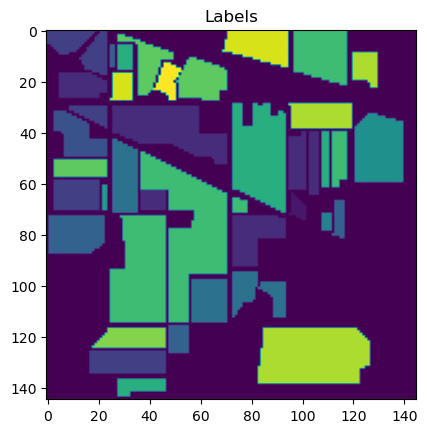

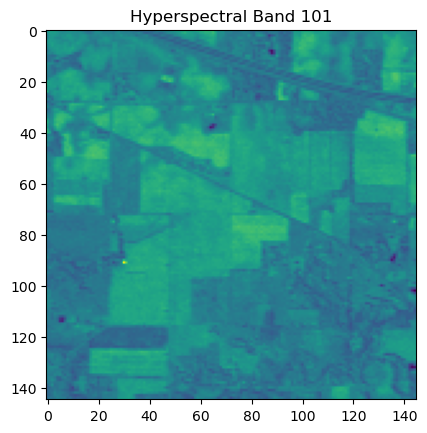

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(160, 5, 5, 200)
(80, 5, 5, 200)
(10009, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0802, PSNR: 10.6233


Epoch [1/50] Training Loss: 0.0654, PSNR: 11.4316
	[Val]   Batch [1/33] Loss: 0.0503, PSNR: 12.6528
	[Val]   Batch [10/33] Loss: 0.0496, PSNR: 12.3106
	[Val]   Batch [20/33] Loss: 0.0493, PSNR: 11.9040
	[Val]   Batch [30/33] Loss: 0.0479, PSNR: 12.2728
Epoch [1/50] Validation Loss: 0.0500, PSNR: 12.4708

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0498, PSNR: 12.6921


Epoch [2/50] Training Loss: 0.0401, PSNR: 13.5666
	[Val]   Batch [1/33] Loss: 0.0294, PSNR: 14.9873
	[Val]   Batch [10/33] Loss: 0.0289, PSNR: 14.6634
	[Val]   Batch [20/33] Loss: 0.0286, PSNR: 14.2668
	[Val]   Batch [30/33] Loss: 0.0280, PSNR: 14.6058
Epoch [2/50] Validation Loss: 0.0293, PSNR: 14.7905

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0296, PSNR: 15.0632


Epoch [3/50] Training Loss: 0.0235, PSNR: 15.8675
	[Val]   Batch [1/33] Loss: 0.0175, PSNR: 17.2224
	[Val]   Batch [10/33] Loss: 0.0171, PSNR: 16.9416
	[Val]   Batch [20/33] Loss: 0.0168, PSNR: 16.5759
	[Val]   Batch [30/33] Loss: 0.0164, PSNR: 16.9152
Epoch [3/50] Validation Loss: 0.0175, PSNR: 17.0251

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0168, PSNR: 17.5174


Epoch [4/50] Training Loss: 0.0144, PSNR: 18.0051
	[Val]   Batch [1/33] Loss: 0.0117, PSNR: 18.9644
	[Val]   Batch [10/33] Loss: 0.0113, PSNR: 18.7396
	[Val]   Batch [20/33] Loss: 0.0110, PSNR: 18.4103
	[Val]   Batch [30/33] Loss: 0.0108, PSNR: 18.7610
Epoch [4/50] Validation Loss: 0.0117, PSNR: 18.7747

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0120, PSNR: 18.1233


Epoch [5/50] Training Loss: 0.0097, PSNR: 19.6845
	[Val]   Batch [1/33] Loss: 0.0083, PSNR: 20.4955
	[Val]   Batch [10/33] Loss: 0.0078, PSNR: 20.3403
	[Val]   Batch [20/33] Loss: 0.0075, PSNR: 20.0561
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.4084
Epoch [5/50] Validation Loss: 0.0082, PSNR: 20.3106

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0076, PSNR: 21.1960


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0327
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6008
	[Val]   Batch [10/33] Loss: 0.0060, PSNR: 21.5093
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2655
	[Val]   Batch [30/33] Loss: 0.0056, PSNR: 21.6254
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4185

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0056, PSNR: 22.1701


Epoch [7/50] Training Loss: 0.0056, PSNR: 22.0583
	[Val]   Batch [1/33] Loss: 0.0051, PSNR: 22.5544
	[Val]   Batch [10/33] Loss: 0.0047, PSNR: 22.5418
	[Val]   Batch [20/33] Loss: 0.0045, PSNR: 22.3340
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.6995
Epoch [7/50] Validation Loss: 0.0051, PSNR: 22.3861

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0046, PSNR: 22.9661


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8624
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2121
	[Val]   Batch [10/33] Loss: 0.0040, PSNR: 23.2814
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1208
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.5171
Epoch [8/50] Validation Loss: 0.0044, PSNR: 23.0786

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0037, PSNR: 24.0736


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5916
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9812
	[Val]   Batch [10/33] Loss: 0.0032, PSNR: 24.1552
	[Val]   Batch [20/33] Loss: 0.0030, PSNR: 24.0315
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.4572
Epoch [9/50] Validation Loss: 0.0036, PSNR: 23.8941

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0034, PSNR: 24.1219


Epoch [10/50] Training Loss: 0.0035, PSNR: 24.2014
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.5143
	[Val]   Batch [10/33] Loss: 0.0028, PSNR: 24.7763
	[Val]   Batch [20/33] Loss: 0.0026, PSNR: 24.6829
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.1451
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.4756

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0031, PSNR: 24.5007


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.8086
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.0831
	[Val]   Batch [10/33] Loss: 0.0024, PSNR: 25.4482
	[Val]   Batch [20/33] Loss: 0.0022, PSNR: 25.3958
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.8705
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.1047

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 24.8828


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.2703
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.4526
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8590
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.8354
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.3437
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5072

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0028, PSNR: 24.7620


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.7166
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 25.9745
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.4389
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.4546
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9746
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.0573

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.2562


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1432
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.3912
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.8313
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.8718
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.4085
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4589

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.1317


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.4990
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.8507
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.2621
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.3275
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.8677
Epoch [15/50] Validation Loss: 0.0018, PSNR: 26.9106

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.1936


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.8471
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.3552
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7303
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8212
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.3703
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.3959

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.3165


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2438
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.7620
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0942
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.1862
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.7463
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7912

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.3057


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.5600
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2042
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.4778
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.5811
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.1776
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.2085

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.7428


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.8515
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.4408
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6558
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7778
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3908
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.4204

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.7674


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1899
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 29.0172
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.2295
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.3562
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9992
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.0024

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.4055


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4404
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.3714
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.5424
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.6951
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.3694
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.3462

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.3577


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7012
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6249
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7686
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9632
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6088
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5953

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.7760


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8501
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8628
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 29.9913
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2221
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9044
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.8477

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.3447


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0703
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8705
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9697
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2077
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9363
Epoch [24/50] Validation Loss: 0.0009, PSNR: 29.8660

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.0862


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2269
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3300
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4469
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7192
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3488
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3248

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.1553


Epoch [26/50] Training Loss: 0.0011, PSNR: 29.3165
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2500
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3727
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6360
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2736
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.2466

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6400


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5757
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5599
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7095
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0205
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7508
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.5969

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9163


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6626
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8075
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9320
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2590
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0436
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.8437
Early stopping triggered at epoch 28. No improvement for 3 epochs.


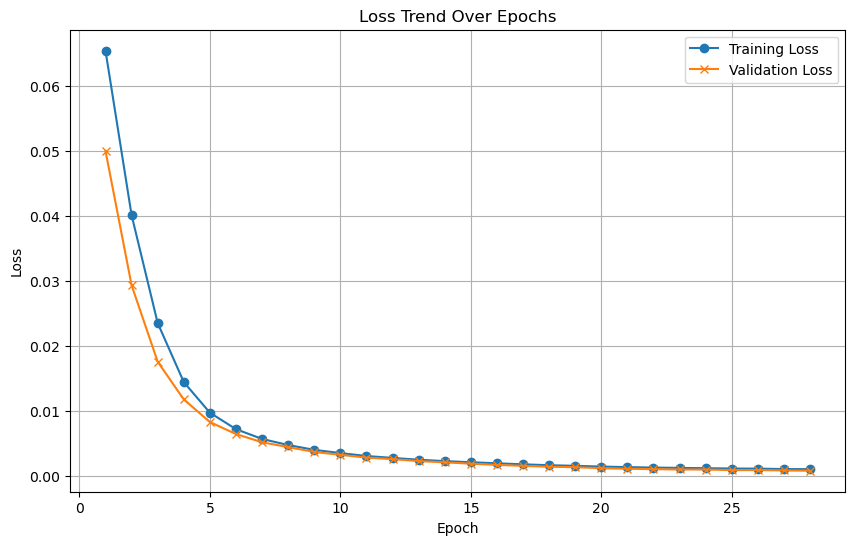

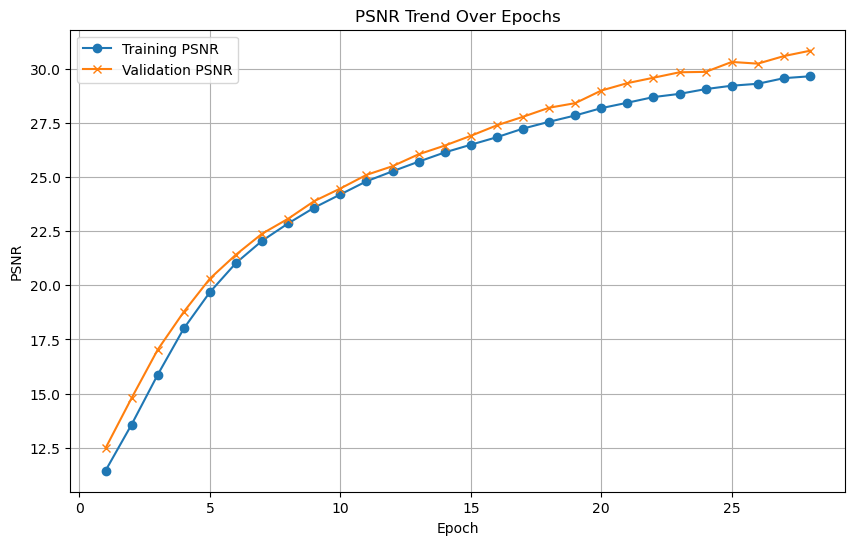

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8001
    Validation Batch [1/1], Loss: 2.7814
Validation Loss: 2.7814, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7814. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7658
    Validation Batch [1/1], Loss: 2.7813
Validation Loss: 2.7813, Validation Accuracy: 6.25%
Validation loss improved from 2.7814 to 2.7813. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7270
    Validation Batch [1/1], Loss: 2.7813
Validation Loss: 2.7813, Validation Accuracy: 6.25%
Validation loss improved from 2.7813 to 2.7813. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7145
    Validation Batch [1/1], Loss: 2.7813
Validation Loss: 2.7813, Validation Accuracy: 6.25%
Validation loss improved from 2.7813 to 2.7813. Saving model...

LOG: Epoch [5/1000] - 

Epoch [9/1000] completed, Average Training Loss: 2.6570
    Validation Batch [1/1], Loss: 2.7810
Validation Loss: 2.7810, Validation Accuracy: 6.25%
Validation loss improved from 2.7811 to 2.7810. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6345
    Validation Batch [1/1], Loss: 2.7809
Validation Loss: 2.7809, Validation Accuracy: 6.25%
Validation loss improved from 2.7810 to 2.7809. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6373
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from 2.7809 to 2.7808. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6164
    Validation Batch [1/1], Loss: 2.7807
Validation Loss: 2.7807, Validation Accuracy: 6.25%
Validation loss improved from 2.7808 to 2.7807. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/100

Epoch [18/1000] completed, Average Training Loss: 2.5632
    Validation Batch [1/1], Loss: 2.7796
Validation Loss: 2.7796, Validation Accuracy: 6.25%
Validation loss improved from 2.7797 to 2.7796. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5262
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss improved from 2.7796 to 2.7793. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5337
    Validation Batch [1/1], Loss: 2.7790
Validation Loss: 2.7790, Validation Accuracy: 6.25%
Validation loss improved from 2.7793 to 2.7790. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5284
    Validation Batch [1/1], Loss: 2.7785
Validation Loss: 2.7785, Validation Accuracy: 6.25%
Validation loss improved from 2.7790 to 2.7785. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/10

Epoch [37/1000] completed, Average Training Loss: 2.4009
    Validation Batch [1/1], Loss: 2.7360
Validation Loss: 2.7360, Validation Accuracy: 12.50%
Validation loss improved from 2.7430 to 2.7360. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.3758
    Validation Batch [1/1], Loss: 2.7280
Validation Loss: 2.7280, Validation Accuracy: 12.50%
Validation loss improved from 2.7360 to 2.7280. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.3783
    Validation Batch [1/1], Loss: 2.7200
Validation Loss: 2.7200, Validation Accuracy: 12.50%
Validation loss improved from 2.7280 to 2.7200. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3793
    Validation Batch [1/1], Loss: 2.7113
Validation Loss: 2.7113, Validation Accuracy: 12.50%
Validation loss improved from 2.7200 to 2.7113. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [4

Epoch [45/1000] completed, Average Training Loss: 2.3253
    Validation Batch [1/1], Loss: 2.6675
Validation Loss: 2.6675, Validation Accuracy: 8.75%
Validation loss improved from 2.6765 to 2.6675. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.3204
    Validation Batch [1/1], Loss: 2.6563
Validation Loss: 2.6563, Validation Accuracy: 8.75%
Validation loss improved from 2.6675 to 2.6563. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.3213
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 10.00%
Validation loss improved from 2.6563 to 2.6430. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.3089
    Validation Batch [1/1], Loss: 2.6349
Validation Loss: 2.6349, Validation Accuracy: 11.25%
Validation loss improved from 2.6430 to 2.6349. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/

    Validation Batch [1/1], Loss: 2.4133
Validation Loss: 2.4133, Validation Accuracy: 26.25%
Validation loss improved from 2.4255 to 2.4133. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.1730
    Validation Batch [1/1], Loss: 2.4152
Validation Loss: 2.4152, Validation Accuracy: 25.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.1897
    Validation Batch [1/1], Loss: 2.4102
Validation Loss: 2.4102, Validation Accuracy: 23.75%
Validation loss improved from 2.4133 to 2.4102. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1923
    Validation Batch [1/1], Loss: 2.3887
Validation Loss: 2.3887, Validation Accuracy: 23.75%
Validation loss improved from 2.4102 to 2.3887. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1560
    Validation Batch [1

Epoch [72/1000] completed, Average Training Loss: 2.1100
    Validation Batch [1/1], Loss: 2.3053
Validation Loss: 2.3053, Validation Accuracy: 26.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.1090
    Validation Batch [1/1], Loss: 2.3276
Validation Loss: 2.3276, Validation Accuracy: 26.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.0934
    Validation Batch [1/1], Loss: 2.3081
Validation Loss: 2.3081, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.1039
    Validation Batch [1/1], Loss: 2.2659
Validation Loss: 2.2659, Validation Accuracy: 28.75%
Validation loss improved from 2.3049 to 2.2659. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.0


LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9895
    Validation Batch [1/1], Loss: 2.1280
Validation Loss: 2.1280, Validation Accuracy: 35.00%
Validation loss improved from 2.1340 to 2.1280. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.9666
    Validation Batch [1/1], Loss: 2.1502
Validation Loss: 2.1502, Validation Accuracy: 30.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.9517
    Validation Batch [1/1], Loss: 2.1695
Validation Loss: 2.1695, Validation Accuracy: 26.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.9527
    Validation Batch [1/1], Loss: 2.1402
Validation Loss: 2.1402, Validation Accuracy: 30.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] comp

Epoch [99/1000] completed, Average Training Loss: 1.8925
    Validation Batch [1/1], Loss: 2.1567
Validation Loss: 2.1567, Validation Accuracy: 36.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8623
    Validation Batch [1/1], Loss: 2.1301
Validation Loss: 2.1301, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8701
    Validation Batch [1/1], Loss: 2.1094
Validation Loss: 2.1094, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8592
    Validation Batch [1/1], Loss: 2.0664
Validation Loss: 2.0664, Validation Accuracy: 45.00%
Validation loss improved from 2.0966 to 2.0664. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training L

Epoch [114/1000] completed, Average Training Loss: 1.7798
    Validation Batch [1/1], Loss: 1.9969
Validation Loss: 1.9969, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.7927
    Validation Batch [1/1], Loss: 1.9800
Validation Loss: 1.9800, Validation Accuracy: 48.75%
Validation loss improved from 1.9830 to 1.9800. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.7206
    Validation Batch [1/1], Loss: 1.9791
Validation Loss: 1.9791, Validation Accuracy: 50.00%
Validation loss improved from 1.9800 to 1.9791. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.7342
    Validation Batch [1/1], Loss: 1.9807
Validation Loss: 1.9807, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Av

Epoch [125/1000] completed, Average Training Loss: 1.6683
    Validation Batch [1/1], Loss: 1.9435
Validation Loss: 1.9435, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6559
    Validation Batch [1/1], Loss: 1.8945
Validation Loss: 1.8945, Validation Accuracy: 56.25%
Validation loss improved from 1.8961 to 1.8945. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6801
    Validation Batch [1/1], Loss: 1.9058
Validation Loss: 1.9058, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.6269
    Validation Batch [1/1], Loss: 1.9350
Validation Loss: 1.9350, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training 

Epoch [140/1000] completed, Average Training Loss: 1.5230
    Validation Batch [1/1], Loss: 1.8872
Validation Loss: 1.8872, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5288
    Validation Batch [1/1], Loss: 1.8249
Validation Loss: 1.8249, Validation Accuracy: 52.50%
Validation loss improved from 1.8385 to 1.8249. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5313
    Validation Batch [1/1], Loss: 1.7977
Validation Loss: 1.7977, Validation Accuracy: 58.75%
Validation loss improved from 1.8249 to 1.7977. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4741
    Validation Batch [1/1], Loss: 1.7917
Validation Loss: 1.7917, Validation Accuracy: 61.25%
Validation loss improved from 1.7977 to 1.7917. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000

    Validation Batch [1/1], Loss: 1.7530
Validation Loss: 1.7530, Validation Accuracy: 68.75%
Validation loss improved from 1.7579 to 1.7530. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4161
    Validation Batch [1/1], Loss: 1.7319
Validation Loss: 1.7319, Validation Accuracy: 67.50%
Validation loss improved from 1.7530 to 1.7319. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.4411
    Validation Batch [1/1], Loss: 1.7125
Validation Loss: 1.7125, Validation Accuracy: 70.00%
Validation loss improved from 1.7319 to 1.7125. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.4618
    Validation Batch [1/1], Loss: 1.7149
Validation Loss: 1.7149, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.4140
    Validation 

Epoch [167/1000] completed, Average Training Loss: 1.3061
    Validation Batch [1/1], Loss: 1.7200
Validation Loss: 1.7200, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2687
    Validation Batch [1/1], Loss: 1.6889
Validation Loss: 1.6889, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.2772
    Validation Batch [1/1], Loss: 1.6502
Validation Loss: 1.6502, Validation Accuracy: 65.00%
Validation loss improved from 1.6709 to 1.6502. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.2750
    Validation Batch [1/1], Loss: 1.6498
Validation Loss: 1.6498, Validation Accuracy: 61.25%
Validation loss improved from 1.6502 to 1.6498. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Av

Epoch [178/1000] completed, Average Training Loss: 1.1955
    Validation Batch [1/1], Loss: 1.5558
Validation Loss: 1.5558, Validation Accuracy: 66.25%
Validation loss improved from 1.5818 to 1.5558. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.1910
    Validation Batch [1/1], Loss: 1.5857
Validation Loss: 1.5857, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1884
    Validation Batch [1/1], Loss: 1.6241
Validation Loss: 1.6241, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1460
    Validation Batch [1/1], Loss: 1.5693
Validation Loss: 1.5693, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training 

Epoch [195/1000] completed, Average Training Loss: 1.0364
    Validation Batch [1/1], Loss: 1.5010
Validation Loss: 1.5010, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0454
    Validation Batch [1/1], Loss: 1.4732
Validation Loss: 1.4732, Validation Accuracy: 70.00%
Validation loss improved from 1.4805 to 1.4732. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.0039
    Validation Batch [1/1], Loss: 1.4445
Validation Loss: 1.4445, Validation Accuracy: 70.00%
Validation loss improved from 1.4732 to 1.4445. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.0313
    Validation Batch [1/1], Loss: 1.4399
Validation Loss: 1.4399, Validation Accuracy: 70.00%
Validation loss improved from 1.4445 to 1.4399. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000

Epoch [205/1000] completed, Average Training Loss: 0.9750
    Validation Batch [1/1], Loss: 1.4210
Validation Loss: 1.4210, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 1.0056
    Validation Batch [1/1], Loss: 1.4596
Validation Loss: 1.4596, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.9628
    Validation Batch [1/1], Loss: 1.4016
Validation Loss: 1.4016, Validation Accuracy: 68.75%
Validation loss improved from 1.4059 to 1.4016. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.9419
    Validation Batch [1/1], Loss: 1.3954
Validation Loss: 1.3954, Validation Accuracy: 73.75%
Validation loss improved from 1.4016 to 1.3954. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3411
Validation Loss: 1.3411, Validation Accuracy: 73.75%
Validation loss improved from 1.3616 to 1.3411. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.8738
    Validation Batch [1/1], Loss: 1.3823
Validation Loss: 1.3823, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.8305
    Validation Batch [1/1], Loss: 1.3438
Validation Loss: 1.3438, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.7969
    Validation Batch [1/1], Loss: 1.2885
Validation Loss: 1.2885, Validation Accuracy: 76.25%
Validation loss improved from 1.3411 to 1.2885. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.8521
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.3022
Validation Loss: 1.3022, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7653
    Validation Batch [1/1], Loss: 1.3217
Validation Loss: 1.3217, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7530
    Validation Batch [1/1], Loss: 1.2972
Validation Loss: 1.2972, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.7485
    Validation Batch [1/1], Loss: 1.2683
Validation Loss: 1.2683, Validation Accuracy: 75.00%
Validation loss improved from 1.2851 to 1.2683. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7423
    Validation Batch [1/1], Loss: 1.2793
Vali

Epoch [246/1000] completed, Average Training Loss: 0.6975
    Validation Batch [1/1], Loss: 1.3040
Validation Loss: 1.3040, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6838
    Validation Batch [1/1], Loss: 1.2774
Validation Loss: 1.2774, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.6575
    Validation Batch [1/1], Loss: 1.3449
Validation Loss: 1.3449, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.6385
    Validation Batch [1/1], Loss: 1.2475
Validation Loss: 1.2475, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.6327
  

Epoch [258/1000] completed, Average Training Loss: 0.6166
    Validation Batch [1/1], Loss: 1.2471
Validation Loss: 1.2471, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.6143
    Validation Batch [1/1], Loss: 1.2061
Validation Loss: 1.2061, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5748
    Validation Batch [1/1], Loss: 1.1674
Validation Loss: 1.1674, Validation Accuracy: 76.25%
Validation loss improved from 1.1972 to 1.1674. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5891
    Validation Batch [1/1], Loss: 1.1730
Validation Loss: 1.1730, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training 

Epoch [272/1000] completed, Average Training Loss: 0.5554
    Validation Batch [1/1], Loss: 1.1180
Validation Loss: 1.1180, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.5237
    Validation Batch [1/1], Loss: 1.1052
Validation Loss: 1.1052, Validation Accuracy: 75.00%
Validation loss improved from 1.1112 to 1.1052. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5204
    Validation Batch [1/1], Loss: 1.1103
Validation Loss: 1.1103, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.4834
    Validation Batch [1/1], Loss: 1.1125
Validation Loss: 1.1125, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training 

Epoch [287/1000] completed, Average Training Loss: 0.4513
    Validation Batch [1/1], Loss: 1.0711
Validation Loss: 1.0711, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.4568
    Validation Batch [1/1], Loss: 1.0803
Validation Loss: 1.0803, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4235
    Validation Batch [1/1], Loss: 1.0759
Validation Loss: 1.0759, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4553
    Validation Batch [1/1], Loss: 1.0985
Validation Loss: 1.0985, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4533
  

Epoch [300/1000] completed, Average Training Loss: 0.4277
    Validation Batch [1/1], Loss: 1.0787
Validation Loss: 1.0787, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.4240
    Validation Batch [1/1], Loss: 1.0365
Validation Loss: 1.0365, Validation Accuracy: 76.25%
Validation loss improved from 1.0578 to 1.0365. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.4350
    Validation Batch [1/1], Loss: 1.0280
Validation Loss: 1.0280, Validation Accuracy: 75.00%
Validation loss improved from 1.0365 to 1.0280. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4190
    Validation Batch [1/1], Loss: 1.1056
Validation Loss: 1.1056, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, A

Epoch [313/1000] completed, Average Training Loss: 0.3694
    Validation Batch [1/1], Loss: 1.0301
Validation Loss: 1.0301, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3659
    Validation Batch [1/1], Loss: 1.0161
Validation Loss: 1.0161, Validation Accuracy: 77.50%
Validation loss improved from 1.0280 to 1.0161. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3504
    Validation Batch [1/1], Loss: 1.0503
Validation Loss: 1.0503, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3538
    Validation Batch [1/1], Loss: 1.0307
Validation Loss: 1.0307, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training

    Validation Batch [1/1], Loss: 1.0453
Validation Loss: 1.0453, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3235
    Validation Batch [1/1], Loss: 1.0184
Validation Loss: 1.0184, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3284
    Validation Batch [1/1], Loss: 0.9881
Validation Loss: 0.9881, Validation Accuracy: 71.25%
Validation loss improved from 1.0038 to 0.9881. Saving model...

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.3104
    Validation Batch [1/1], Loss: 0.9817
Validation Loss: 0.9817, Validation Accuracy: 75.00%
Validation loss improved from 0.9881 to 0.9817. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3082
    Validation Batch [1/1], Lo

Epoch [339/1000] completed, Average Training Loss: 0.2789
    Validation Batch [1/1], Loss: 0.9766
Validation Loss: 0.9766, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2878
    Validation Batch [1/1], Loss: 1.0239
Validation Loss: 1.0239, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3126
    Validation Batch [1/1], Loss: 1.0186
Validation Loss: 1.0186, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.3183
    Validation Batch [1/1], Loss: 1.0886
Validation Loss: 1.0886, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2911

    Validation Batch [1/1], Loss: 0.9654
Validation Loss: 0.9654, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.2540
    Validation Batch [1/1], Loss: 1.0096
Validation Loss: 1.0096, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2822
    Validation Batch [1/1], Loss: 0.9852
Validation Loss: 0.9852, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2496
    Validation Batch [1/1], Loss: 0.9811
Validation Loss: 0.9811, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2597
    Validation Batch [1/1], Loss: 1.0096
Validation Loss: 1.

Epoch [364/1000] completed, Average Training Loss: 0.2273
    Validation Batch [1/1], Loss: 0.9319
Validation Loss: 0.9319, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2411
    Validation Batch [1/1], Loss: 0.9416
Validation Loss: 0.9416, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2209
    Validation Batch [1/1], Loss: 0.9799
Validation Loss: 0.9799, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2519
    Validation Batch [1/1], Loss: 0.9701
Validation Loss: 0.9701, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2689
  

Epoch [376/1000] completed, Average Training Loss: 0.2306
    Validation Batch [1/1], Loss: 0.9217
Validation Loss: 0.9217, Validation Accuracy: 75.00%
Validation loss improved from 0.9304 to 0.9217. Saving model...

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2147
    Validation Batch [1/1], Loss: 0.9347
Validation Loss: 0.9347, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2187
    Validation Batch [1/1], Loss: 0.9581
Validation Loss: 0.9581, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2208
    Validation Batch [1/1], Loss: 0.9787
Validation Loss: 0.9787, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training 

Epoch [389/1000] completed, Average Training Loss: 0.2370
    Validation Batch [1/1], Loss: 0.9396
Validation Loss: 0.9396, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.2027
    Validation Batch [1/1], Loss: 0.9337
Validation Loss: 0.9337, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1904
    Validation Batch [1/1], Loss: 0.9248
Validation Loss: 0.9248, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.2020
    Validation Batch [1/1], Loss: 0.9848
Validation Loss: 0.9848, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.207

Epoch [401/1000] completed, Average Training Loss: 0.1720
    Validation Batch [1/1], Loss: 0.8789
Validation Loss: 0.8789, Validation Accuracy: 78.75%
Validation loss improved from 0.9217 to 0.8789. Saving model...

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1737
    Validation Batch [1/1], Loss: 0.8972
Validation Loss: 0.8972, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1755
    Validation Batch [1/1], Loss: 0.9548
Validation Loss: 0.9548, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1696
    Validation Batch [1/1], Loss: 1.1043
Validation Loss: 1.1043, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.9564
Validation Loss: 0.9564, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 0.9812
Validation Loss: 0.9812, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1591
    Validation Batch [1/1], Loss: 1.0320
Validation Loss: 1.0320, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1798
    Validation Batch [1/1], Loss: 0.8997
Validation Loss: 0.8997, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1705
    Validation Batch [1/1], Loss: 0.9416
Validation Loss

    Validation Batch [1/1], Loss: 0.9315
Validation Loss: 0.9315, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1509
    Validation Batch [1/1], Loss: 0.9497
Validation Loss: 0.9497, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1519
    Validation Batch [1/1], Loss: 0.9089
Validation Loss: 0.9089, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1627
    Validation Batch [1/1], Loss: 0.9447
Validation Loss: 0.9447, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1500
    Validation Batch [1/1], Loss: 0.9308
Validation Loss

    Validation Batch [1/1], Loss: 0.8879
Validation Loss: 0.8879, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1372
    Validation Batch [1/1], Loss: 0.9015
Validation Loss: 0.9015, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1491
    Validation Batch [1/1], Loss: 0.9140
Validation Loss: 0.9140, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1241
    Validation Batch [1/1], Loss: 0.9258
Validation Loss: 0.9258, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1523
    Validation Batch [1/1], Loss: 0.9050
Validation Loss

    Validation Batch [1/1], Loss: 0.9342
Validation Loss: 0.9342, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.9517
Validation Loss: 0.9517, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1146
    Validation Batch [1/1], Loss: 0.9703
Validation Loss: 0.9703, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1239
    Validation Batch [1/1], Loss: 0.9359
Validation Loss: 0.9359, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.9095
Validation Loss

Epoch [468/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.9085
Validation Loss: 0.9085, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1237
    Validation Batch [1/1], Loss: 0.8650
Validation Loss: 0.8650, Validation Accuracy: 77.50%
Validation loss improved from 0.8749 to 0.8650. Saving model...

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1305
    Validation Batch [1/1], Loss: 0.8425
Validation Loss: 0.8425, Validation Accuracy: 80.00%
Validation loss improved from 0.8650 to 0.8425. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1132
    Validation Batch [1/1], Loss: 0.8320
Validation Loss: 0.8320, Validation Accuracy: 78.75%
Validation loss improved from 0.8425 to 0.8320. Saving model...

LOG: Epoch [472/1000] - Training
Epoch [472/1000

Epoch [480/1000] completed, Average Training Loss: 0.1205
    Validation Batch [1/1], Loss: 0.9357
Validation Loss: 0.9357, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 1.0342
Validation Loss: 1.0342, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0918
    Validation Batch [1/1], Loss: 1.0843
Validation Loss: 1.0843, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.1009
    Validation Batch [1/1], Loss: 1.0425
Validation Loss: 1.0425, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0999

    Validation Batch [1/1], Loss: 0.8990
Validation Loss: 0.8990, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1061
    Validation Batch [1/1], Loss: 0.8898
Validation Loss: 0.8898, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0873
    Validation Batch [1/1], Loss: 0.8899
Validation Loss: 0.8899, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0967
    Validation Batch [1/1], Loss: 0.8510
Validation Loss: 0.8510, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.1108
    Validation Batch [1/1], Loss: 0.8597
Validation Loss

Epoch [505/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.8895
Validation Loss: 0.8895, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.1283
    Validation Batch [1/1], Loss: 0.9319
Validation Loss: 0.9319, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.9326
Validation Loss: 0.9326, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.1013
    Validation Batch [1/1], Loss: 0.9077
Validation Loss: 0.9077, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.091

    Validation Batch [1/1], Loss: 0.8530
Validation Loss: 0.8530, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 0.8466
Validation Loss: 0.8466, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.1059
    Validation Batch [1/1], Loss: 0.9191
Validation Loss: 0.9191, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.9941
Validation Loss: 0.9941, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0777
    Validation Batch [1/1], Loss: 0.9529
Validation Loss

Epoch [533/1000] completed, Average Training Loss: 0.0934
    Validation Batch [1/1], Loss: 0.9804
Validation Loss: 0.9804, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.9570
Validation Loss: 0.9570, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.9755
Validation Loss: 0.9755, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0863
    Validation Batch [1/1], Loss: 0.9487
Validation Loss: 0.9487, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.078

Epoch [544/1000] completed, Average Training Loss: 0.0916
    Validation Batch [1/1], Loss: 0.9014
Validation Loss: 0.9014, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0908
    Validation Batch [1/1], Loss: 0.8590
Validation Loss: 0.8590, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0972
    Validation Batch [1/1], Loss: 0.8500
Validation Loss: 0.8500, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 0.8622
Validation Loss: 0.8622, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.088

Epoch [558/1000] completed, Average Training Loss: 0.0817
    Validation Batch [1/1], Loss: 0.9286
Validation Loss: 0.9286, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0885
    Validation Batch [1/1], Loss: 0.8850
Validation Loss: 0.8850, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 0.8889
Validation Loss: 0.8889, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0839
    Validation Batch [1/1], Loss: 0.9042
Validation Loss: 0.9042, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.073

    Validation Batch [1/1], Loss: 0.9175
Validation Loss: 0.9175, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 571. No improvement for 100 epochs.
Loading the best model weights...


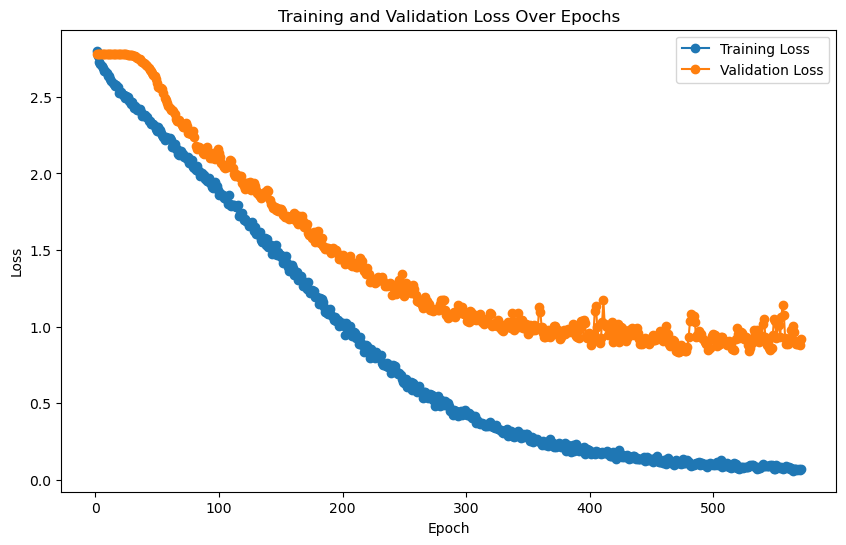

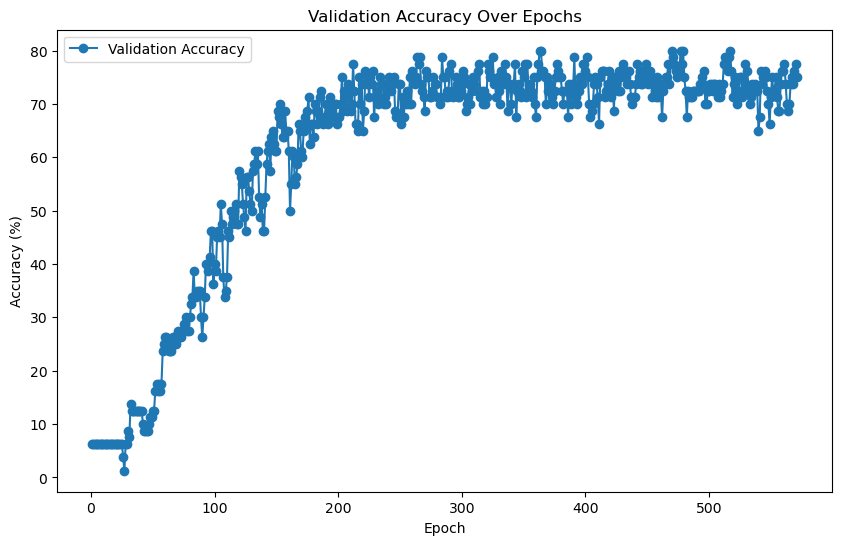


Evaluating on the test set...
    Test Batch [1/40], Loss: 2.6548



Final Test Loss: 1.4263, Test Accuracy: 60.20%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10009, 64), Test labels shape: (10009,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 57.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.29      0.40      0.33         5
           2       0.00      0.00      0.00         5
           3       0.75      0.60      0.67         5
           4       0.67      0.80      0.73         5
           5       1.00      0.40      0.57         5
           6       0.67      0.80      0.73         5
           7       0.57      0.80      0.67         5
           8       1.00      1.

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10009, 64)
Test labels shape: (10009,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8072  |  Val Loss: 2.7559
Validation loss improved from inf to 2.7559.
[Epoch 2/1000] Train Loss: 2.6914  |  Val Loss: 2.6856
Validation loss improved from 2.7559 to 2.6856.
[Epoch 3/1000] Train Loss: 2.6266  |  Val Loss: 2.6330
Validation loss improved from 2.6856 to 2.6330.
[Epoch 4/1000] Train Loss: 2.5738  |  Val Loss: 2.5836
Validation loss improved from 2.6330 to 2.5836.
[Epoch 5/1000] Train Loss: 2.5185  |  Val Loss: 2.5393
Validation loss improved from 2.5836 to 2.5393.
[Epoch 6/1000] Train Loss: 2.4706  |  Val Loss: 2.4991
Validation loss improved from 2.5393 to 2.4991.
[Epoch 7/1000] Train Loss: 2.4277  |  Val Loss: 2.4600
Validation loss improved from 2.4991 to 2.4600.
[Epoch 8/1000] Train Loss: 2.3830  |  Val Loss: 2.4203
Validation loss improved from 2.4600 to 2.4203.
[Epoch 9/1000] Train Loss: 2.3403  |  Val Loss: 2.3809
Validation loss improved from 2.4203 to 2.3809.
[Epoch 10/1000] Train Loss: 2.2984  |  Val Loss: 2.3446
Validation loss impr

[Epoch 14/1000] Train Loss: 2.1306  |  Val Loss: 2.1821
Validation loss improved from 2.2228 to 2.1821.
[Epoch 15/1000] Train Loss: 2.0897  |  Val Loss: 2.1499
Validation loss improved from 2.1821 to 2.1499.
[Epoch 16/1000] Train Loss: 2.0498  |  Val Loss: 2.1058
Validation loss improved from 2.1499 to 2.1058.
[Epoch 17/1000] Train Loss: 2.0046  |  Val Loss: 2.0685
Validation loss improved from 2.1058 to 2.0685.
[Epoch 18/1000] Train Loss: 1.9640  |  Val Loss: 2.0352
Validation loss improved from 2.0685 to 2.0352.
[Epoch 19/1000] Train Loss: 1.9198  |  Val Loss: 1.9978
Validation loss improved from 2.0352 to 1.9978.
[Epoch 20/1000] Train Loss: 1.8831  |  Val Loss: 1.9646
Validation loss improved from 1.9978 to 1.9646.
[Epoch 21/1000] Train Loss: 1.8430  |  Val Loss: 1.9267
Validation loss improved from 1.9646 to 1.9267.
[Epoch 22/1000] Train Loss: 1.8072  |  Val Loss: 1.8783
Validation loss improved from 1.9267 to 1.8783.
[Epoch 23/1000] Train Loss: 1.7618  |  Val Loss: 1.8438
Validati

[Epoch 24/1000] Train Loss: 1.7224  |  Val Loss: 1.8162
Validation loss improved from 1.8438 to 1.8162.
[Epoch 25/1000] Train Loss: 1.6768  |  Val Loss: 1.7968
Validation loss improved from 1.8162 to 1.7968.
[Epoch 26/1000] Train Loss: 1.6447  |  Val Loss: 1.7695
Validation loss improved from 1.7968 to 1.7695.
[Epoch 27/1000] Train Loss: 1.6057  |  Val Loss: 1.7186
Validation loss improved from 1.7695 to 1.7186.
[Epoch 28/1000] Train Loss: 1.5614  |  Val Loss: 1.6860
Validation loss improved from 1.7186 to 1.6860.
[Epoch 29/1000] Train Loss: 1.5279  |  Val Loss: 1.6573
Validation loss improved from 1.6860 to 1.6573.
[Epoch 30/1000] Train Loss: 1.4932  |  Val Loss: 1.6243
Validation loss improved from 1.6573 to 1.6243.


[Epoch 31/1000] Train Loss: 1.4660  |  Val Loss: 1.5988
Validation loss improved from 1.6243 to 1.5988.
[Epoch 32/1000] Train Loss: 1.4296  |  Val Loss: 1.5845
Validation loss improved from 1.5988 to 1.5845.
[Epoch 33/1000] Train Loss: 1.3992  |  Val Loss: 1.5547
Validation loss improved from 1.5845 to 1.5547.
[Epoch 34/1000] Train Loss: 1.3705  |  Val Loss: 1.5351
Validation loss improved from 1.5547 to 1.5351.
[Epoch 35/1000] Train Loss: 1.3410  |  Val Loss: 1.5142
Validation loss improved from 1.5351 to 1.5142.
[Epoch 36/1000] Train Loss: 1.3129  |  Val Loss: 1.5119
Validation loss improved from 1.5142 to 1.5119.
[Epoch 37/1000] Train Loss: 1.2857  |  Val Loss: 1.4836
Validation loss improved from 1.5119 to 1.4836.
[Epoch 38/1000] Train Loss: 1.2556  |  Val Loss: 1.4585
Validation loss improved from 1.4836 to 1.4585.
[Epoch 39/1000] Train Loss: 1.2398  |  Val Loss: 1.4451
Validation loss improved from 1.4585 to 1.4451.
[Epoch 40/1000] Train Loss: 1.2073  |  Val Loss: 1.4524
!! Valid

[Epoch 43/1000] Train Loss: 1.1504  |  Val Loss: 1.4375
Validation loss improved from 1.4408 to 1.4375.
[Epoch 44/1000] Train Loss: 1.1333  |  Val Loss: 1.4477
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 1.1023  |  Val Loss: 1.4439
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 1.1010  |  Val Loss: 1.4317
Validation loss improved from 1.4375 to 1.4317.
[Epoch 47/1000] Train Loss: 1.0759  |  Val Loss: 1.4370
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 1.0689  |  Val Loss: 1.4212
Validation loss improved from 1.4317 to 1.4212.
[Epoch 49/1000] Train Loss: 1.0490  |  Val Loss: 1.4323
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 1.0337  |  Val Loss: 1.4259
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 1.0254  |  Val Loss: 1.4402
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 52/1000] Train Loss: 

[Epoch 53/1000] Train Loss: 0.9954  |  Val Loss: 1.3895
Validation loss improved from 1.4100 to 1.3895.
[Epoch 54/1000] Train Loss: 0.9800  |  Val Loss: 1.3997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.9695  |  Val Loss: 1.4336
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 0.9559  |  Val Loss: 1.3869
Validation loss improved from 1.3895 to 1.3869.
[Epoch 57/1000] Train Loss: 0.9356  |  Val Loss: 1.3916
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.9317  |  Val Loss: 1.3913
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 59/1000] Train Loss: 0.9124  |  Val Loss: 1.4074
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 60/1000] Train Loss: 0.9020  |  Val Loss: 1.4094
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 61/1000] Train Loss: 0.8907  |  Val Loss: 1.4139
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 62/1000] Train Loss: 0.8831  |  Val Loss: 1.4269
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 63/1000] Train Loss: 0.8647  |  Val Loss: 1.3978
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 64/1000] Train Loss: 0.8733  |  Val Loss: 1.3762
Validation loss improved from 1.3869 to 1.3762.
[Epoch 65/1000] Train Loss: 0.8558  |  Val Loss: 1.3996
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.8523  |  Val Loss: 1.3939
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.8434  |  Val Loss: 1.4115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 68/1000] Train Loss: 0.8311  |  Val Loss: 1.4332
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 69/1000] 

[Epoch 73/1000] Train Loss: 0.7900  |  Val Loss: 1.4342
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 74/1000] Train Loss: 0.7805  |  Val Loss: 1.4623
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 75/1000] Train Loss: 0.7723  |  Val Loss: 1.4294
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 76/1000] Train Loss: 0.7650  |  Val Loss: 1.4015
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 77/1000] Train Loss: 0.7494  |  Val Loss: 1.4381
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 78/1000] Train Loss: 0.7472  |  Val Loss: 1.4675
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 79/1000] Train Loss: 0.7432  |  Val Loss: 1.4382
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 80/1000] Train Loss: 0.7245  |  Val Loss: 1.4042
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 81/1000] Train Loss: 0.7277  |  Val Loss: 1.3992
!! Validation loss did NOT improve !! Patience: 17/100
[E

[Epoch 83/1000] Train Loss: 0.7129  |  Val Loss: 1.4258
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 84/1000] Train Loss: 0.6982  |  Val Loss: 1.3867
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 85/1000] Train Loss: 0.7032  |  Val Loss: 1.3844
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 86/1000] Train Loss: 0.6866  |  Val Loss: 1.4059
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 87/1000] Train Loss: 0.6780  |  Val Loss: 1.4262
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 88/1000] Train Loss: 0.6758  |  Val Loss: 1.4679
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 89/1000] Train Loss: 0.6696  |  Val Loss: 1.4571
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 90/1000] Train Loss: 0.6634  |  Val Loss: 1.4305
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 91/1000] Train Loss: 0.6489  |  Val Loss: 1.4203
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 92/1000] Train Loss: 0.6489  |  Val Loss: 1.4107
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 93/1000] Train Loss: 0.6353  |  Val Loss: 1.4387
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 94/1000] Train Loss: 0.6407  |  Val Loss: 1.4502
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 95/1000] Train Loss: 0.6348  |  Val Loss: 1.4464
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 96/1000] Train Loss: 0.6239  |  Val Loss: 1.4018
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 97/1000] Train Loss: 0.6282  |  Val Loss: 1.4190
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 98/1000] Train Loss: 0.6133  |  Val Loss: 1.4816
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 99/1000] Train Loss: 0.6219  |  Val Loss: 1.4682
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 100/1000] Train Loss: 0.6034  |  Val Loss: 1.4291
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 103/1000] Train Loss: 0.5983  |  Val Loss: 1.4713
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 104/1000] Train Loss: 0.5885  |  Val Loss: 1.4515
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 105/1000] Train Loss: 0.5827  |  Val Loss: 1.4467
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 106/1000] Train Loss: 0.5748  |  Val Loss: 1.4702
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 107/1000] Train Loss: 0.5672  |  Val Loss: 1.4419
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 108/1000] Train Loss: 0.5631  |  Val Loss: 1.4094
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 109/1000] Train Loss: 0.5738  |  Val Loss: 1.3912
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 110/1000] Train Loss: 0.5591  |  Val Loss: 1.4617
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 111/1000] Train Loss: 0.5503  |  Val Loss: 1.4467
!! Validation loss did NOT improve !! Patience:

[Epoch 112/1000] Train Loss: 0.5477  |  Val Loss: 1.4122
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 113/1000] Train Loss: 0.5385  |  Val Loss: 1.4335
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 114/1000] Train Loss: 0.5392  |  Val Loss: 1.4838
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 115/1000] Train Loss: 0.5319  |  Val Loss: 1.4961
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 116/1000] Train Loss: 0.5351  |  Val Loss: 1.4557
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 117/1000] Train Loss: 0.5273  |  Val Loss: 1.5035
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 118/1000] Train Loss: 0.5215  |  Val Loss: 1.4956
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 119/1000] Train Loss: 0.5188  |  Val Loss: 1.4796
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 120/1000] Train Loss: 0.5189  |  Val Loss: 1.4418
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 121/1000] Train Loss: 0.5065  |  Val Loss: 1.4619
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 122/1000] Train Loss: 0.5128  |  Val Loss: 1.4886
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 123/1000] Train Loss: 0.5035  |  Val Loss: 1.4900
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 124/1000] Train Loss: 0.5077  |  Val Loss: 1.4786
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 125/1000] Train Loss: 0.4917  |  Val Loss: 1.5284
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 126/1000] Train Loss: 0.4903  |  Val Loss: 1.4868
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 127/1000] Train Loss: 0.4837  |  Val Loss: 1.4386
!! Validation loss did NOT improve !! Patience:

[Epoch 128/1000] Train Loss: 0.4845  |  Val Loss: 1.4528
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 129/1000] Train Loss: 0.4884  |  Val Loss: 1.5422
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 130/1000] Train Loss: 0.4837  |  Val Loss: 1.4836
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 131/1000] Train Loss: 0.4708  |  Val Loss: 1.4554
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 132/1000] Train Loss: 0.4696  |  Val Loss: 1.5177
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 133/1000] Train Loss: 0.4654  |  Val Loss: 1.5526
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 134/1000] Train Loss: 0.4663  |  Val Loss: 1.5108
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 135/1000] Train Loss: 0.4560  |  Val Loss: 1.4906
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 136/1000] Train Loss: 0.4551  |  Val Loss: 1.4990
!! Validation loss did NOT improve !! Patience:

[Epoch 139/1000] Train Loss: 0.4464  |  Val Loss: 1.4902
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 140/1000] Train Loss: 0.4461  |  Val Loss: 1.5235
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 141/1000] Train Loss: 0.4383  |  Val Loss: 1.5294
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 142/1000] Train Loss: 0.4317  |  Val Loss: 1.5198
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 143/1000] Train Loss: 0.4342  |  Val Loss: 1.5415
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 144/1000] Train Loss: 0.4255  |  Val Loss: 1.5382
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 145/1000] Train Loss: 0.4225  |  Val Loss: 1.5285
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 146/1000] Train Loss: 0.4258  |  Val Loss: 1.5625
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 147/1000] Train Loss: 0.4154  |  Val Loss: 1.5943
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 148/1000] Train Loss: 0.4267  |  Val Loss: 1.5470
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 149/1000] Train Loss: 0.4074  |  Val Loss: 1.5480
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 150/1000] Train Loss: 0.4215  |  Val Loss: 1.6085
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 151/1000] Train Loss: 0.4057  |  Val Loss: 1.6515
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 152/1000] Train Loss: 0.4413  |  Val Loss: 1.5354
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 153/1000] Train Loss: 0.4065  |  Val Loss: 1.5757
!! Validation loss did NOT improve !! Patience: 89/100


[Epoch 154/1000] Train Loss: 0.4224  |  Val Loss: 1.5869
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 155/1000] Train Loss: 0.3960  |  Val Loss: 1.6310
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 156/1000] Train Loss: 0.3982  |  Val Loss: 1.6234
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 157/1000] Train Loss: 0.3866  |  Val Loss: 1.5807
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 158/1000] Train Loss: 0.3842  |  Val Loss: 1.5929
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 159/1000] Train Loss: 0.3820  |  Val Loss: 1.6125
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 160/1000] Train Loss: 0.3771  |  Val Loss: 1.6241
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 161/1000] Train Loss: 0.3740  |  Val Loss: 1.6051
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 162/1000] Train Loss: 0.3749  |  Val Loss: 1.5712
!! Validation loss did NOT improve !! Patience:

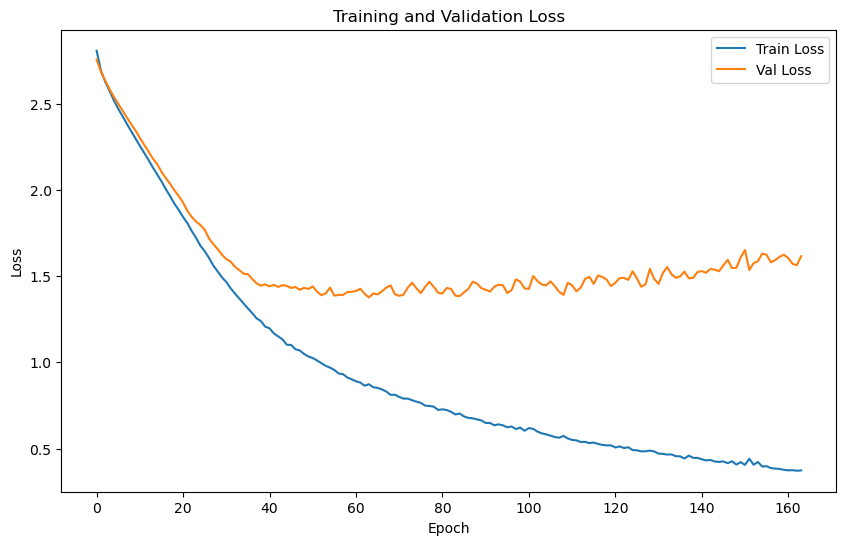

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9210 | Test Accuracy: 43.32%


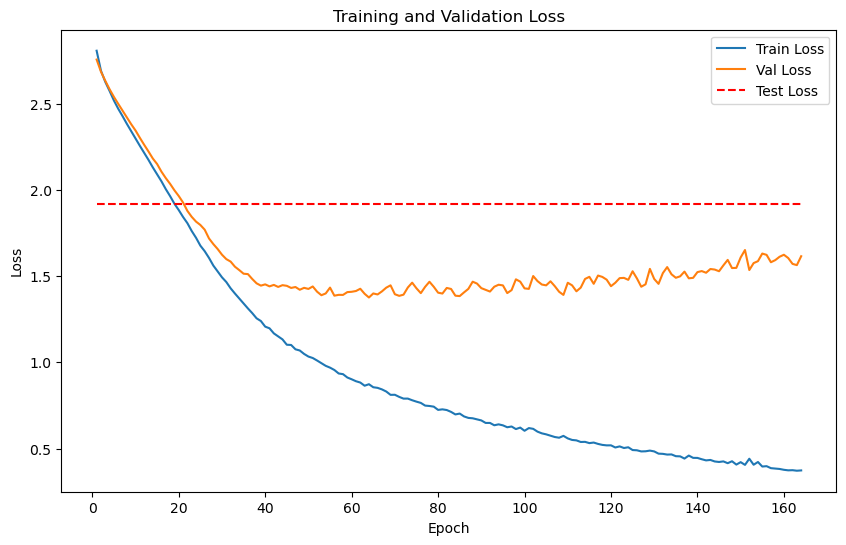

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.3265
Epoch [1/2000], Avg Train Loss: 9.3265
Epoch [1/2000], Avg Val Loss: 5.4997
Validation loss improved from inf to 5.4997. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.3033
Epoch [2/2000], Avg Train Loss: 9.3033
Epoch [2/2000], Avg Val Loss: 5.4411
Validation loss improved from 5.4997 to 5.4411. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.2955
Epoch [3/2000], Avg Train Loss: 9.2955
Epoch [3/2000], Avg Val Loss: 5.3842
Validation loss improved from 5.4411 to 5.3842. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.0947
Epoch [4/2000], Avg Train Loss: 9.0947
Epoch [4/2000], Avg Val Loss: 5.3286
Validation loss improved from 5.3842 to 5.3286. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 9.1715
Epoch [5/2000], Avg Train Loss: 9.1715
Epoch [5/2000], Avg Val Loss: 5.2740
Validation loss improved from 5.3286 to 5.2740. Saving mode

    Batch [1/1], Train Loss: 8.3209
Epoch [15/2000], Avg Train Loss: 8.3209
Epoch [15/2000], Avg Val Loss: 4.7954
Validation loss improved from 4.8380 to 4.7954. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.2679
Epoch [16/2000], Avg Train Loss: 8.2679
Epoch [16/2000], Avg Val Loss: 4.7540
Validation loss improved from 4.7954 to 4.7540. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 8.0933
Epoch [17/2000], Avg Train Loss: 8.0933
Epoch [17/2000], Avg Val Loss: 4.7135
Validation loss improved from 4.7540 to 4.7135. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.9082
Epoch [18/2000], Avg Train Loss: 7.9082
Epoch [18/2000], Avg Val Loss: 4.6741
Validation loss improved from 4.7135 to 4.6741. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 8.2150
Epoch [19/2000], Avg Train Loss: 8.2150
Epoch [19/2000], Avg Val Loss: 4.6356
Validation loss improved from 4.6741 to 4.

Epoch [26/2000], Avg Val Loss: 4.3972
Validation loss improved from 4.4281 to 4.3972. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.5096
Epoch [27/2000], Avg Train Loss: 7.5096
Epoch [27/2000], Avg Val Loss: 4.3671
Validation loss improved from 4.3972 to 4.3671. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.3919
Epoch [28/2000], Avg Train Loss: 7.3919
Epoch [28/2000], Avg Val Loss: 4.3381
Validation loss improved from 4.3671 to 4.3381. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.3691
Epoch [29/2000], Avg Train Loss: 7.3691
Epoch [29/2000], Avg Val Loss: 4.3102
Validation loss improved from 4.3381 to 4.3102. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.2122
Epoch [30/2000], Avg Train Loss: 7.2122
Epoch [30/2000], Avg Val Loss: 4.2830
Validation loss improved from 4.3102 to 4.2830. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.7643
Epoch [37/2000], Avg Train Loss: 6.7643
Epoch [37/2000], Avg Val Loss: 4.1173
Validation loss improved from 4.1384 to 4.1173. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.7606
Epoch [38/2000], Avg Train Loss: 6.7606
Epoch [38/2000], Avg Val Loss: 4.0968
Validation loss improved from 4.1173 to 4.0968. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.7116
Epoch [39/2000], Avg Train Loss: 6.7116
Epoch [39/2000], Avg Val Loss: 4.0771
Validation loss improved from 4.0968 to 4.0771. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.5584
Epoch [40/2000], Avg Train Loss: 6.5584
Epoch [40/2000], Avg Val Loss: 4.0580
Validation loss improved from 4.0771 to 4.0580. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.6967
Epoch [41/2000], Avg Train Loss: 6.6967
Epoch [41/2000], Avg Val Loss: 4.0397
Validation loss improved from 4.0580 to 4.

Epoch [54/2000], Avg Val Loss: 3.8541
Validation loss improved from 3.8652 to 3.8541. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 6.0375
Epoch [55/2000], Avg Train Loss: 6.0375
Epoch [55/2000], Avg Val Loss: 3.8434
Validation loss improved from 3.8541 to 3.8434. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0370
Epoch [56/2000], Avg Train Loss: 6.0370
Epoch [56/2000], Avg Val Loss: 3.8332
Validation loss improved from 3.8434 to 3.8332. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.9898
Epoch [57/2000], Avg Train Loss: 5.9898
Epoch [57/2000], Avg Val Loss: 3.8234
Validation loss improved from 3.8332 to 3.8234. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.8544
Epoch [58/2000], Avg Train Loss: 5.8544
Epoch [58/2000], Avg Val Loss: 3.8140
Validation loss improved from 3.8234 to 3.8140. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.6244
Epoch [67/2000], Avg Train Loss: 5.6244
Epoch [67/2000], Avg Val Loss: 3.7432
Validation loss improved from 3.7499 to 3.7432. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.5593
Epoch [68/2000], Avg Train Loss: 5.5593
Epoch [68/2000], Avg Val Loss: 3.7369
Validation loss improved from 3.7432 to 3.7369. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.6269
Epoch [69/2000], Avg Train Loss: 5.6269
Epoch [69/2000], Avg Val Loss: 3.7308
Validation loss improved from 3.7369 to 3.7308. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.5099
Epoch [70/2000], Avg Train Loss: 5.5099
Epoch [70/2000], Avg Val Loss: 3.7249
Validation loss improved from 3.7308 to 3.7249. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.4723
Epoch [71/2000], Avg Train Loss: 5.4723
Epoch [71/2000], Avg Val Loss: 3.7192
Validation loss improved from 3.7249 to 3.

    Batch [1/1], Train Loss: 5.3800
Epoch [79/2000], Avg Train Loss: 5.3800
Epoch [79/2000], Avg Val Loss: 3.6810
Validation loss improved from 3.6852 to 3.6810. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.3503
Epoch [80/2000], Avg Train Loss: 5.3503
Epoch [80/2000], Avg Val Loss: 3.6770
Validation loss improved from 3.6810 to 3.6770. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.3540
Epoch [81/2000], Avg Train Loss: 5.3540
Epoch [81/2000], Avg Val Loss: 3.6731
Validation loss improved from 3.6770 to 3.6731. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.2992
Epoch [82/2000], Avg Train Loss: 5.2992
Epoch [82/2000], Avg Val Loss: 3.6693
Validation loss improved from 3.6731 to 3.6693. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.2918
Epoch [83/2000], Avg Train Loss: 5.2918
Epoch [83/2000], Avg Val Loss: 3.6657
Validation loss improved from 3.6693 to 3.

    Batch [1/1], Train Loss: 5.0284
Epoch [95/2000], Avg Train Loss: 5.0284
Epoch [95/2000], Avg Val Loss: 3.6297
Validation loss improved from 3.6322 to 3.6297. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.1873
Epoch [96/2000], Avg Train Loss: 5.1873
Epoch [96/2000], Avg Val Loss: 3.6273
Validation loss improved from 3.6297 to 3.6273. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.1631
Epoch [97/2000], Avg Train Loss: 5.1631
Epoch [97/2000], Avg Val Loss: 3.6250
Validation loss improved from 3.6273 to 3.6250. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.0872
Epoch [98/2000], Avg Train Loss: 5.0872
Epoch [98/2000], Avg Val Loss: 3.6227
Validation loss improved from 3.6250 to 3.6227. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.1079
Epoch [99/2000], Avg Train Loss: 5.1079
Epoch [99/2000], Avg Val Loss: 3.6205
Validation loss improved from 3.6227 to 3.

    Batch [1/1], Train Loss: 4.9486
Epoch [107/2000], Avg Train Loss: 4.9486
Epoch [107/2000], Avg Val Loss: 3.6048
Validation loss improved from 3.6067 to 3.6048. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.0131
Epoch [108/2000], Avg Train Loss: 5.0131
Epoch [108/2000], Avg Val Loss: 3.6030
Validation loss improved from 3.6048 to 3.6030. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9630
Epoch [109/2000], Avg Train Loss: 4.9630
Epoch [109/2000], Avg Val Loss: 3.6013
Validation loss improved from 3.6030 to 3.6013. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.0260
Epoch [110/2000], Avg Train Loss: 5.0260
Epoch [110/2000], Avg Val Loss: 3.5996
Validation loss improved from 3.6013 to 3.5996. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.8825
Epoch [111/2000], Avg Train Loss: 4.8825
Epoch [111/2000], Avg Val Loss: 3.5979
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9463
Epoch [116/2000], Avg Train Loss: 4.9463
Epoch [116/2000], Avg Val Loss: 3.5899
Validation loss improved from 3.5914 to 3.5899. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.8575
Epoch [117/2000], Avg Train Loss: 4.8575
Epoch [117/2000], Avg Val Loss: 3.5884
Validation loss improved from 3.5899 to 3.5884. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.0171
Epoch [118/2000], Avg Train Loss: 5.0171
Epoch [118/2000], Avg Val Loss: 3.5869
Validation loss improved from 3.5884 to 3.5869. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.8277
Epoch [119/2000], Avg Train Loss: 4.8277
Epoch [119/2000], Avg Val Loss: 3.5854
Validation loss improved from 3.5869 to 3.5854. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.9336
Epoch [120/2000], Avg Train Loss: 4.9336
Epoch [120/2000], Avg Val Loss: 3.5840
Validation loss improved fro

Epoch [139/2000], Avg Val Loss: 3.5583
Validation loss improved from 3.5596 to 3.5583. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.7463
Epoch [140/2000], Avg Train Loss: 4.7463
Epoch [140/2000], Avg Val Loss: 3.5570
Validation loss improved from 3.5583 to 3.5570. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.7614
Epoch [141/2000], Avg Train Loss: 4.7614
Epoch [141/2000], Avg Val Loss: 3.5557
Validation loss improved from 3.5570 to 3.5557. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.7271
Epoch [142/2000], Avg Train Loss: 4.7271
Epoch [142/2000], Avg Val Loss: 3.5544
Validation loss improved from 3.5557 to 3.5544. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.8653
Epoch [143/2000], Avg Train Loss: 4.8653
Epoch [143/2000], Avg Val Loss: 3.5531
Validation loss improved from 3.5544 to 3.5531. Saving model...

LOG: Epoch [144/2000] - Training
    Bat

Epoch [149/2000], Avg Val Loss: 3.5457
Validation loss improved from 3.5469 to 3.5457. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.7582
Epoch [150/2000], Avg Train Loss: 4.7582
Epoch [150/2000], Avg Val Loss: 3.5445
Validation loss improved from 3.5457 to 3.5445. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.7657
Epoch [151/2000], Avg Train Loss: 4.7657
Epoch [151/2000], Avg Val Loss: 3.5433
Validation loss improved from 3.5445 to 3.5433. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.7302
Epoch [152/2000], Avg Train Loss: 4.7302
Epoch [152/2000], Avg Val Loss: 3.5421
Validation loss improved from 3.5433 to 3.5421. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.6871
Epoch [153/2000], Avg Train Loss: 4.6871
Epoch [153/2000], Avg Val Loss: 3.5409
Validation loss improved from 3.5421 to 3.5409. Saving model...

LOG: Epoch [154/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7326
Epoch [159/2000], Avg Train Loss: 4.7326
Epoch [159/2000], Avg Val Loss: 3.5338
Validation loss improved from 3.5349 to 3.5338. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.6912
Epoch [160/2000], Avg Train Loss: 4.6912
Epoch [160/2000], Avg Val Loss: 3.5327
Validation loss improved from 3.5338 to 3.5327. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.7507
Epoch [161/2000], Avg Train Loss: 4.7507
Epoch [161/2000], Avg Val Loss: 3.5316
Validation loss improved from 3.5327 to 3.5316. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6943
Epoch [162/2000], Avg Train Loss: 4.6943
Epoch [162/2000], Avg Val Loss: 3.5304
Validation loss improved from 3.5316 to 3.5304. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.6716
Epoch [163/2000], Avg Train Loss: 4.6716
Epoch [163/2000], Avg Val Loss: 3.5293
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6362
Epoch [184/2000], Avg Train Loss: 4.6362
Epoch [184/2000], Avg Val Loss: 3.5045
Validation loss improved from 3.5057 to 3.5045. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.5959
Epoch [185/2000], Avg Train Loss: 4.5959
Epoch [185/2000], Avg Val Loss: 3.5034
Validation loss improved from 3.5045 to 3.5034. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 4.5967
Epoch [186/2000], Avg Train Loss: 4.5967
Epoch [186/2000], Avg Val Loss: 3.5023
Validation loss improved from 3.5034 to 3.5023. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.6175
Epoch [187/2000], Avg Train Loss: 4.6175
Epoch [187/2000], Avg Val Loss: 3.5011
Validation loss improved from 3.5023 to 3.5011. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.6110
Epoch [188/2000], Avg Train Loss: 4.6110
Epoch [188/2000], Avg Val Loss: 3.5000
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5809
Epoch [194/2000], Avg Train Loss: 4.5809
Epoch [194/2000], Avg Val Loss: 3.4934
Validation loss improved from 3.4945 to 3.4934. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.6015
Epoch [195/2000], Avg Train Loss: 4.6015
Epoch [195/2000], Avg Val Loss: 3.4923
Validation loss improved from 3.4934 to 3.4923. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.5524
Epoch [196/2000], Avg Train Loss: 4.5524
Epoch [196/2000], Avg Val Loss: 3.4912
Validation loss improved from 3.4923 to 3.4912. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.6107
Epoch [197/2000], Avg Train Loss: 4.6107
Epoch [197/2000], Avg Val Loss: 3.4900
Validation loss improved from 3.4912 to 3.4900. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.5926
Epoch [198/2000], Avg Train Loss: 4.5926
Epoch [198/2000], Avg Val Loss: 3.4888
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5877
Epoch [204/2000], Avg Train Loss: 4.5877
Epoch [204/2000], Avg Val Loss: 3.4821
Validation loss improved from 3.4832 to 3.4821. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.4987
Epoch [205/2000], Avg Train Loss: 4.4987
Epoch [205/2000], Avg Val Loss: 3.4810
Validation loss improved from 3.4821 to 3.4810. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 4.5410
Epoch [206/2000], Avg Train Loss: 4.5410
Epoch [206/2000], Avg Val Loss: 3.4799
Validation loss improved from 3.4810 to 3.4799. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.5352
Epoch [207/2000], Avg Train Loss: 4.5352
Epoch [207/2000], Avg Val Loss: 3.4788
Validation loss improved from 3.4799 to 3.4788. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 4.4677
Epoch [208/2000], Avg Train Loss: 4.4677
Epoch [208/2000], Avg Val Loss: 3.4778
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5050
Epoch [225/2000], Avg Train Loss: 4.5050
Epoch [225/2000], Avg Val Loss: 3.4587
Validation loss improved from 3.4598 to 3.4587. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.5495
Epoch [226/2000], Avg Train Loss: 4.5495
Epoch [226/2000], Avg Val Loss: 3.4576
Validation loss improved from 3.4587 to 3.4576. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.5261
Epoch [227/2000], Avg Train Loss: 4.5261
Epoch [227/2000], Avg Val Loss: 3.4564
Validation loss improved from 3.4576 to 3.4564. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.5109
Epoch [228/2000], Avg Train Loss: 4.5109
Epoch [228/2000], Avg Val Loss: 3.4553
Validation loss improved from 3.4564 to 3.4553. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.4813
Epoch [229/2000], Avg Train Loss: 4.4813
Epoch [229/2000], Avg Val Loss: 3.4542
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5044
Epoch [237/2000], Avg Train Loss: 4.5044
Epoch [237/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4465 to 3.4455. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.5060
Epoch [238/2000], Avg Train Loss: 4.5060
Epoch [238/2000], Avg Val Loss: 3.4444
Validation loss improved from 3.4455 to 3.4444. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.4506
Epoch [239/2000], Avg Train Loss: 4.4506
Epoch [239/2000], Avg Val Loss: 3.4433
Validation loss improved from 3.4444 to 3.4433. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.4851
Epoch [240/2000], Avg Train Loss: 4.4851
Epoch [240/2000], Avg Val Loss: 3.4423
Validation loss improved from 3.4433 to 3.4423. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 4.5197
Epoch [241/2000], Avg Train Loss: 4.5197
Epoch [241/2000], Avg Val Loss: 3.4412
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4399
Epoch [245/2000], Avg Train Loss: 4.4399
Epoch [245/2000], Avg Val Loss: 3.4370
Validation loss improved from 3.4381 to 3.4370. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.4938
Epoch [246/2000], Avg Train Loss: 4.4938
Epoch [246/2000], Avg Val Loss: 3.4360
Validation loss improved from 3.4370 to 3.4360. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 4.4956
Epoch [247/2000], Avg Train Loss: 4.4956
Epoch [247/2000], Avg Val Loss: 3.4349
Validation loss improved from 3.4360 to 3.4349. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.4777
Epoch [248/2000], Avg Train Loss: 4.4777
Epoch [248/2000], Avg Val Loss: 3.4339
Validation loss improved from 3.4349 to 3.4339. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 4.4486
Epoch [249/2000], Avg Train Loss: 4.4486
Epoch [249/2000], Avg Val Loss: 3.4328
Validation loss improved fro

Epoch [263/2000], Avg Val Loss: 3.4183
Validation loss improved from 3.4193 to 3.4183. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.3957
Epoch [264/2000], Avg Train Loss: 4.3957
Epoch [264/2000], Avg Val Loss: 3.4173
Validation loss improved from 3.4183 to 3.4173. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.3997
Epoch [265/2000], Avg Train Loss: 4.3997
Epoch [265/2000], Avg Val Loss: 3.4163
Validation loss improved from 3.4173 to 3.4163. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.4206
Epoch [266/2000], Avg Train Loss: 4.4206
Epoch [266/2000], Avg Val Loss: 3.4153
Validation loss improved from 3.4163 to 3.4153. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.4061
Epoch [267/2000], Avg Train Loss: 4.4061
Epoch [267/2000], Avg Val Loss: 3.4143
Validation loss improved from 3.4153 to 3.4143. Saving model...

LOG: Epoch [268/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3770
Epoch [272/2000], Avg Train Loss: 4.3770
Epoch [272/2000], Avg Val Loss: 3.4095
Validation loss improved from 3.4104 to 3.4095. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.4129
Epoch [273/2000], Avg Train Loss: 4.4129
Epoch [273/2000], Avg Val Loss: 3.4085
Validation loss improved from 3.4095 to 3.4085. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.4036
Epoch [274/2000], Avg Train Loss: 4.4036
Epoch [274/2000], Avg Val Loss: 3.4075
Validation loss improved from 3.4085 to 3.4075. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.4367
Epoch [275/2000], Avg Train Loss: 4.4367
Epoch [275/2000], Avg Val Loss: 3.4065
Validation loss improved from 3.4075 to 3.4065. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.3881
Epoch [276/2000], Avg Train Loss: 4.3881
Epoch [276/2000], Avg Val Loss: 3.4056
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4109
Epoch [283/2000], Avg Train Loss: 4.4109
Epoch [283/2000], Avg Val Loss: 3.3986
Validation loss improved from 3.3996 to 3.3986. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.3711
Epoch [284/2000], Avg Train Loss: 4.3711
Epoch [284/2000], Avg Val Loss: 3.3976
Validation loss improved from 3.3986 to 3.3976. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.4570
Epoch [285/2000], Avg Train Loss: 4.4570
Epoch [285/2000], Avg Val Loss: 3.3966
Validation loss improved from 3.3976 to 3.3966. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.3635
Epoch [286/2000], Avg Train Loss: 4.3635
Epoch [286/2000], Avg Val Loss: 3.3956
Validation loss improved from 3.3966 to 3.3956. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.4287
Epoch [287/2000], Avg Train Loss: 4.4287
Epoch [287/2000], Avg Val Loss: 3.3947
Validation loss improved fro

Epoch [304/2000], Avg Val Loss: 3.3786
Validation loss improved from 3.3794 to 3.3786. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.3439
Epoch [305/2000], Avg Train Loss: 4.3439
Epoch [305/2000], Avg Val Loss: 3.3777
Validation loss improved from 3.3786 to 3.3777. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.4036
Epoch [306/2000], Avg Train Loss: 4.4036
Epoch [306/2000], Avg Val Loss: 3.3768
Validation loss improved from 3.3777 to 3.3768. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.3343
Epoch [307/2000], Avg Train Loss: 4.3343
Epoch [307/2000], Avg Val Loss: 3.3759
Validation loss improved from 3.3768 to 3.3759. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.4120
Epoch [308/2000], Avg Train Loss: 4.4120
Epoch [308/2000], Avg Val Loss: 3.3750
Validation loss improved from 3.3759 to 3.3750. Saving model...

LOG: Epoch [309/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3580
Epoch [314/2000], Avg Train Loss: 4.3580
Epoch [314/2000], Avg Val Loss: 3.3696
Validation loss improved from 3.3705 to 3.3696. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.3165
Epoch [315/2000], Avg Train Loss: 4.3165
Epoch [315/2000], Avg Val Loss: 3.3687
Validation loss improved from 3.3696 to 3.3687. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.3041
Epoch [316/2000], Avg Train Loss: 4.3041
Epoch [316/2000], Avg Val Loss: 3.3678
Validation loss improved from 3.3687 to 3.3678. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 4.2870
Epoch [317/2000], Avg Train Loss: 4.2870
Epoch [317/2000], Avg Val Loss: 3.3669
Validation loss improved from 3.3678 to 3.3669. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 4.3372
Epoch [318/2000], Avg Train Loss: 4.3372
Epoch [318/2000], Avg Val Loss: 3.3659
Validation loss improved fro

Epoch [326/2000], Avg Val Loss: 3.3587
Validation loss improved from 3.3596 to 3.3587. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.3689
Epoch [327/2000], Avg Train Loss: 4.3689
Epoch [327/2000], Avg Val Loss: 3.3577
Validation loss improved from 3.3587 to 3.3577. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.3091
Epoch [328/2000], Avg Train Loss: 4.3091
Epoch [328/2000], Avg Val Loss: 3.3569
Validation loss improved from 3.3577 to 3.3569. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.2980
Epoch [329/2000], Avg Train Loss: 4.2980
Epoch [329/2000], Avg Val Loss: 3.3560
Validation loss improved from 3.3569 to 3.3560. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.3184
Epoch [330/2000], Avg Train Loss: 4.3184
Epoch [330/2000], Avg Val Loss: 3.3551
Validation loss improved from 3.3560 to 3.3551. Saving model...

LOG: Epoch [331/2000] - Training
    Bat

Epoch [346/2000], Avg Val Loss: 3.3413
Validation loss improved from 3.3421 to 3.3413. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.3121
Epoch [347/2000], Avg Train Loss: 4.3121
Epoch [347/2000], Avg Val Loss: 3.3405
Validation loss improved from 3.3413 to 3.3405. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.2821
Epoch [348/2000], Avg Train Loss: 4.2821
Epoch [348/2000], Avg Val Loss: 3.3397
Validation loss improved from 3.3405 to 3.3397. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.3022
Epoch [349/2000], Avg Train Loss: 4.3022
Epoch [349/2000], Avg Val Loss: 3.3389
Validation loss improved from 3.3397 to 3.3389. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.2749
Epoch [350/2000], Avg Train Loss: 4.2749
Epoch [350/2000], Avg Val Loss: 3.3381
Validation loss improved from 3.3389 to 3.3381. Saving model...

LOG: Epoch [351/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2859
Epoch [353/2000], Avg Train Loss: 4.2859
Epoch [353/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3365 to 3.3357. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 4.2851
Epoch [354/2000], Avg Train Loss: 4.2851
Epoch [354/2000], Avg Val Loss: 3.3350
Validation loss improved from 3.3357 to 3.3350. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.2874
Epoch [355/2000], Avg Train Loss: 4.2874
Epoch [355/2000], Avg Val Loss: 3.3342
Validation loss improved from 3.3350 to 3.3342. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.3014
Epoch [356/2000], Avg Train Loss: 4.3014
Epoch [356/2000], Avg Val Loss: 3.3334
Validation loss improved from 3.3342 to 3.3334. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.2732
Epoch [357/2000], Avg Train Loss: 4.2732
Epoch [357/2000], Avg Val Loss: 3.3326
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2692
Epoch [369/2000], Avg Train Loss: 4.2692
Epoch [369/2000], Avg Val Loss: 3.3230
Validation loss improved from 3.3238 to 3.3230. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 4.2156
Epoch [370/2000], Avg Train Loss: 4.2156
Epoch [370/2000], Avg Val Loss: 3.3222
Validation loss improved from 3.3230 to 3.3222. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 4.2696
Epoch [371/2000], Avg Train Loss: 4.2696
Epoch [371/2000], Avg Val Loss: 3.3214
Validation loss improved from 3.3222 to 3.3214. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.2544
Epoch [372/2000], Avg Train Loss: 4.2544
Epoch [372/2000], Avg Val Loss: 3.3206
Validation loss improved from 3.3214 to 3.3206. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.2266
Epoch [373/2000], Avg Train Loss: 4.2266
Epoch [373/2000], Avg Val Loss: 3.3198
Validation loss improved fro

Epoch [390/2000], Avg Val Loss: 3.3069
Validation loss improved from 3.3076 to 3.3069. Saving model...

LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 4.1940
Epoch [391/2000], Avg Train Loss: 4.1940
Epoch [391/2000], Avg Val Loss: 3.3061
Validation loss improved from 3.3069 to 3.3061. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.1915
Epoch [392/2000], Avg Train Loss: 4.1915
Epoch [392/2000], Avg Val Loss: 3.3054
Validation loss improved from 3.3061 to 3.3054. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.2848
Epoch [393/2000], Avg Train Loss: 4.2848
Epoch [393/2000], Avg Val Loss: 3.3046
Validation loss improved from 3.3054 to 3.3046. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.2935
Epoch [394/2000], Avg Train Loss: 4.2935
Epoch [394/2000], Avg Val Loss: 3.3039
Validation loss improved from 3.3046 to 3.3039. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.2138
Epoch [395/2000], Avg Train Loss: 4.2138
Epoch [395/2000], Avg Val Loss: 3.3032
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2437
Epoch [411/2000], Avg Train Loss: 4.2437
Epoch [411/2000], Avg Val Loss: 3.2923
Validation loss improved from 3.2930 to 3.2923. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.2306
Epoch [412/2000], Avg Train Loss: 4.2306
Epoch [412/2000], Avg Val Loss: 3.2917
Validation loss improved from 3.2923 to 3.2917. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.2034
Epoch [413/2000], Avg Train Loss: 4.2034
Epoch [413/2000], Avg Val Loss: 3.2911
Validation loss improved from 3.2917 to 3.2911. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.2005
Epoch [414/2000], Avg Train Loss: 4.2005
Epoch [414/2000], Avg Val Loss: 3.2905
Validation loss improved from 3.2911 to 3.2905. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.2136
Epoch [415/2000], Avg Train Loss: 4.2136
Epoch [415/2000], Avg Val Loss: 3.2899
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2282
Epoch [430/2000], Avg Train Loss: 4.2282
Epoch [430/2000], Avg Val Loss: 3.2799
Validation loss improved from 3.2806 to 3.2799. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.1636
Epoch [431/2000], Avg Train Loss: 4.1636
Epoch [431/2000], Avg Val Loss: 3.2793
Validation loss improved from 3.2799 to 3.2793. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.1082
Epoch [432/2000], Avg Train Loss: 4.1082
Epoch [432/2000], Avg Val Loss: 3.2787
Validation loss improved from 3.2793 to 3.2787. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.2076
Epoch [433/2000], Avg Train Loss: 4.2076
Epoch [433/2000], Avg Val Loss: 3.2780
Validation loss improved from 3.2787 to 3.2780. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.1682
Epoch [434/2000], Avg Train Loss: 4.1682
Epoch [434/2000], Avg Val Loss: 3.2774
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1364
Epoch [450/2000], Avg Train Loss: 4.1364
Epoch [450/2000], Avg Val Loss: 3.2687
Validation loss improved from 3.2692 to 3.2687. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.2072
Epoch [451/2000], Avg Train Loss: 4.2072
Epoch [451/2000], Avg Val Loss: 3.2681
Validation loss improved from 3.2687 to 3.2681. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.1521
Epoch [452/2000], Avg Train Loss: 4.1521
Epoch [452/2000], Avg Val Loss: 3.2676
Validation loss improved from 3.2681 to 3.2676. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.1811
Epoch [453/2000], Avg Train Loss: 4.1811
Epoch [453/2000], Avg Val Loss: 3.2671
Validation loss improved from 3.2676 to 3.2671. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.1700
Epoch [454/2000], Avg Train Loss: 4.1700
Epoch [454/2000], Avg Val Loss: 3.2666
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1394
Epoch [473/2000], Avg Train Loss: 4.1394
Epoch [473/2000], Avg Val Loss: 3.2565
Validation loss improved from 3.2570 to 3.2565. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.1473
Epoch [474/2000], Avg Train Loss: 4.1473
Epoch [474/2000], Avg Val Loss: 3.2560
Validation loss improved from 3.2565 to 3.2560. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.1021
Epoch [475/2000], Avg Train Loss: 4.1021
Epoch [475/2000], Avg Val Loss: 3.2555
Validation loss improved from 3.2560 to 3.2555. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.1423
Epoch [476/2000], Avg Train Loss: 4.1423
Epoch [476/2000], Avg Val Loss: 3.2550
Validation loss improved from 3.2555 to 3.2550. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.1215
Epoch [477/2000], Avg Train Loss: 4.1215
Epoch [477/2000], Avg Val Loss: 3.2545
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0999
Epoch [491/2000], Avg Train Loss: 4.0999
Epoch [491/2000], Avg Val Loss: 3.2477
Validation loss improved from 3.2482 to 3.2477. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.1321
Epoch [492/2000], Avg Train Loss: 4.1321
Epoch [492/2000], Avg Val Loss: 3.2472
Validation loss improved from 3.2477 to 3.2472. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.1780
Epoch [493/2000], Avg Train Loss: 4.1780
Epoch [493/2000], Avg Val Loss: 3.2467
Validation loss improved from 3.2472 to 3.2467. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.1018
Epoch [494/2000], Avg Train Loss: 4.1018
Epoch [494/2000], Avg Val Loss: 3.2462
Validation loss improved from 3.2467 to 3.2462. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.1149
Epoch [495/2000], Avg Train Loss: 4.1149
Epoch [495/2000], Avg Val Loss: 3.2457
Validation loss improved fro

Epoch [512/2000], Avg Val Loss: 3.2389
Validation loss improved from 3.2393 to 3.2389. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.1113
Epoch [513/2000], Avg Train Loss: 4.1113
Epoch [513/2000], Avg Val Loss: 3.2385
Validation loss improved from 3.2389 to 3.2385. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.1015
Epoch [514/2000], Avg Train Loss: 4.1015
Epoch [514/2000], Avg Val Loss: 3.2381
Validation loss improved from 3.2385 to 3.2381. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.0780
Epoch [515/2000], Avg Train Loss: 4.0780
Epoch [515/2000], Avg Val Loss: 3.2377
Validation loss improved from 3.2381 to 3.2377. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.0995
Epoch [516/2000], Avg Train Loss: 4.0995
Epoch [516/2000], Avg Val Loss: 3.2372
Validation loss improved from 3.2377 to 3.2372. Saving model...

LOG: Epoch [517/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0952
Epoch [535/2000], Avg Train Loss: 4.0952
Epoch [535/2000], Avg Val Loss: 3.2285
Validation loss improved from 3.2290 to 3.2285. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.1204
Epoch [536/2000], Avg Train Loss: 4.1204
Epoch [536/2000], Avg Val Loss: 3.2281
Validation loss improved from 3.2285 to 3.2281. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.1276
Epoch [537/2000], Avg Train Loss: 4.1276
Epoch [537/2000], Avg Val Loss: 3.2276
Validation loss improved from 3.2281 to 3.2276. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.0797
Epoch [538/2000], Avg Train Loss: 4.0797
Epoch [538/2000], Avg Val Loss: 3.2272
Validation loss improved from 3.2276 to 3.2272. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.0461
Epoch [539/2000], Avg Train Loss: 4.0461
Epoch [539/2000], Avg Val Loss: 3.2267
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0242
Epoch [555/2000], Avg Train Loss: 4.0242
Epoch [555/2000], Avg Val Loss: 3.2190
Validation loss improved from 3.2196 to 3.2190. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.0342
Epoch [556/2000], Avg Train Loss: 4.0342
Epoch [556/2000], Avg Val Loss: 3.2186
Validation loss improved from 3.2190 to 3.2186. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.0173
Epoch [557/2000], Avg Train Loss: 4.0173
Epoch [557/2000], Avg Val Loss: 3.2181
Validation loss improved from 3.2186 to 3.2181. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 4.1119
Epoch [558/2000], Avg Train Loss: 4.1119
Epoch [558/2000], Avg Val Loss: 3.2176
Validation loss improved from 3.2181 to 3.2176. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.0594
Epoch [559/2000], Avg Train Loss: 4.0594
Epoch [559/2000], Avg Val Loss: 3.2172
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0122
Epoch [574/2000], Avg Train Loss: 4.0122
Epoch [574/2000], Avg Val Loss: 3.2109
Validation loss improved from 3.2112 to 3.2109. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.0364
Epoch [575/2000], Avg Train Loss: 4.0364
Epoch [575/2000], Avg Val Loss: 3.2105
Validation loss improved from 3.2109 to 3.2105. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.9994
Epoch [576/2000], Avg Train Loss: 3.9994
Epoch [576/2000], Avg Val Loss: 3.2101
Validation loss improved from 3.2105 to 3.2101. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.0697
Epoch [577/2000], Avg Train Loss: 4.0697
Epoch [577/2000], Avg Val Loss: 3.2098
Validation loss improved from 3.2101 to 3.2098. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.0418
Epoch [578/2000], Avg Train Loss: 4.0418
Epoch [578/2000], Avg Val Loss: 3.2094
Validation loss improved fro

Epoch [598/2000], Avg Val Loss: 3.2021
Validation loss improved from 3.2024 to 3.2021. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.0466
Epoch [599/2000], Avg Train Loss: 4.0466
Epoch [599/2000], Avg Val Loss: 3.2017
Validation loss improved from 3.2021 to 3.2017. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.0690
Epoch [600/2000], Avg Train Loss: 4.0690
Epoch [600/2000], Avg Val Loss: 3.2014
Validation loss improved from 3.2017 to 3.2014. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.0577
Epoch [601/2000], Avg Train Loss: 4.0577
Epoch [601/2000], Avg Val Loss: 3.2010
Validation loss improved from 3.2014 to 3.2010. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.9992
Epoch [602/2000], Avg Train Loss: 3.9992
Epoch [602/2000], Avg Val Loss: 3.2006
Validation loss improved from 3.2010 to 3.2006. Saving model...

LOG: Epoch [603/2000] - Training
    Bat

Epoch [618/2000], Avg Val Loss: 3.1952
Validation loss improved from 3.1955 to 3.1952. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.0168
Epoch [619/2000], Avg Train Loss: 4.0168
Epoch [619/2000], Avg Val Loss: 3.1949
Validation loss improved from 3.1952 to 3.1949. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.0442
Epoch [620/2000], Avg Train Loss: 4.0442
Epoch [620/2000], Avg Val Loss: 3.1946
Validation loss improved from 3.1949 to 3.1946. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.0331
Epoch [621/2000], Avg Train Loss: 4.0331
Epoch [621/2000], Avg Val Loss: 3.1943
Validation loss improved from 3.1946 to 3.1943. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 4.0326
Epoch [622/2000], Avg Train Loss: 4.0326
Epoch [622/2000], Avg Val Loss: 3.1940
Validation loss improved from 3.1943 to 3.1940. Saving model...

LOG: Epoch [623/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0112
Epoch [641/2000], Avg Train Loss: 4.0112
Epoch [641/2000], Avg Val Loss: 3.1864
Validation loss improved from 3.1867 to 3.1864. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.9926
Epoch [642/2000], Avg Train Loss: 3.9926
Epoch [642/2000], Avg Val Loss: 3.1860
Validation loss improved from 3.1864 to 3.1860. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 3.9963
Epoch [643/2000], Avg Train Loss: 3.9963
Epoch [643/2000], Avg Val Loss: 3.1856
Validation loss improved from 3.1860 to 3.1856. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.0015
Epoch [644/2000], Avg Train Loss: 4.0015
Epoch [644/2000], Avg Val Loss: 3.1853
Validation loss improved from 3.1856 to 3.1853. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 3.9953
Epoch [645/2000], Avg Train Loss: 3.9953
Epoch [645/2000], Avg Val Loss: 3.1849
Validation loss improved fro

Epoch [658/2000], Avg Val Loss: 3.1800
Validation loss improved from 3.1804 to 3.1800. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.9946
Epoch [659/2000], Avg Train Loss: 3.9946
Epoch [659/2000], Avg Val Loss: 3.1797
Validation loss improved from 3.1800 to 3.1797. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.9772
Epoch [660/2000], Avg Train Loss: 3.9772
Epoch [660/2000], Avg Val Loss: 3.1793
Validation loss improved from 3.1797 to 3.1793. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.9523
Epoch [661/2000], Avg Train Loss: 3.9523
Epoch [661/2000], Avg Val Loss: 3.1789
Validation loss improved from 3.1793 to 3.1789. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.9668
Epoch [662/2000], Avg Train Loss: 3.9668
Epoch [662/2000], Avg Val Loss: 3.1785
Validation loss improved from 3.1789 to 3.1785. Saving model...

LOG: Epoch [663/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9686
Epoch [684/2000], Avg Train Loss: 3.9686
Epoch [684/2000], Avg Val Loss: 3.1716
Validation loss improved from 3.1719 to 3.1716. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.9906
Epoch [685/2000], Avg Train Loss: 3.9906
Epoch [685/2000], Avg Val Loss: 3.1713
Validation loss improved from 3.1716 to 3.1713. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.9776
Epoch [686/2000], Avg Train Loss: 3.9776
Epoch [686/2000], Avg Val Loss: 3.1710
Validation loss improved from 3.1713 to 3.1710. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 3.9494
Epoch [687/2000], Avg Train Loss: 3.9494
Epoch [687/2000], Avg Val Loss: 3.1707
Validation loss improved from 3.1710 to 3.1707. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 3.9495
Epoch [688/2000], Avg Train Loss: 3.9495
Epoch [688/2000], Avg Val Loss: 3.1704
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9435
Epoch [699/2000], Avg Train Loss: 3.9435
Epoch [699/2000], Avg Val Loss: 3.1672
Validation loss improved from 3.1675 to 3.1672. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.9838
Epoch [700/2000], Avg Train Loss: 3.9838
Epoch [700/2000], Avg Val Loss: 3.1668
Validation loss improved from 3.1672 to 3.1668. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.9118
Epoch [701/2000], Avg Train Loss: 3.9118
Epoch [701/2000], Avg Val Loss: 3.1665
Validation loss improved from 3.1668 to 3.1665. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.9501
Epoch [702/2000], Avg Train Loss: 3.9501
Epoch [702/2000], Avg Val Loss: 3.1661
Validation loss improved from 3.1665 to 3.1661. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.9680
Epoch [703/2000], Avg Train Loss: 3.9680
Epoch [703/2000], Avg Val Loss: 3.1657
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9570
Epoch [728/2000], Avg Train Loss: 3.9570
Epoch [728/2000], Avg Val Loss: 3.1574
Validation loss improved from 3.1578 to 3.1574. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.9371
Epoch [729/2000], Avg Train Loss: 3.9371
Epoch [729/2000], Avg Val Loss: 3.1569
Validation loss improved from 3.1574 to 3.1569. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.9463
Epoch [730/2000], Avg Train Loss: 3.9463
Epoch [730/2000], Avg Val Loss: 3.1564
Validation loss improved from 3.1569 to 3.1564. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.9931
Epoch [731/2000], Avg Train Loss: 3.9931
Epoch [731/2000], Avg Val Loss: 3.1559
Validation loss improved from 3.1564 to 3.1559. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 3.9422
Epoch [732/2000], Avg Train Loss: 3.9422
Epoch [732/2000], Avg Val Loss: 3.1554
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9148
Epoch [742/2000], Avg Train Loss: 3.9148
Epoch [742/2000], Avg Val Loss: 3.1515
Validation loss improved from 3.1520 to 3.1515. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.9114
Epoch [743/2000], Avg Train Loss: 3.9114
Epoch [743/2000], Avg Val Loss: 3.1511
Validation loss improved from 3.1515 to 3.1511. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.8886
Epoch [744/2000], Avg Train Loss: 3.8886
Epoch [744/2000], Avg Val Loss: 3.1508
Validation loss improved from 3.1511 to 3.1508. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.8916
Epoch [745/2000], Avg Train Loss: 3.8916
Epoch [745/2000], Avg Val Loss: 3.1506
Validation loss improved from 3.1508 to 3.1506. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.9261
Epoch [746/2000], Avg Train Loss: 3.9261
Epoch [746/2000], Avg Val Loss: 3.1503
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8971
Epoch [768/2000], Avg Train Loss: 3.8971
Epoch [768/2000], Avg Val Loss: 3.1465
Validation loss improved from 3.1468 to 3.1465. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.8529
Epoch [769/2000], Avg Train Loss: 3.8529
Epoch [769/2000], Avg Val Loss: 3.1462
Validation loss improved from 3.1465 to 3.1462. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.9289
Epoch [770/2000], Avg Train Loss: 3.9289
Epoch [770/2000], Avg Val Loss: 3.1458
Validation loss improved from 3.1462 to 3.1458. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.9118
Epoch [771/2000], Avg Train Loss: 3.9118
Epoch [771/2000], Avg Val Loss: 3.1454
Validation loss improved from 3.1458 to 3.1454. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.9247
Epoch [772/2000], Avg Train Loss: 3.9247
Epoch [772/2000], Avg Val Loss: 3.1450
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9145
Epoch [788/2000], Avg Train Loss: 3.9145
Epoch [788/2000], Avg Val Loss: 3.1378
Validation loss improved from 3.1382 to 3.1378. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.8822
Epoch [789/2000], Avg Train Loss: 3.8822
Epoch [789/2000], Avg Val Loss: 3.1373
Validation loss improved from 3.1378 to 3.1373. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.8884
Epoch [790/2000], Avg Train Loss: 3.8884
Epoch [790/2000], Avg Val Loss: 3.1369
Validation loss improved from 3.1373 to 3.1369. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.8723
Epoch [791/2000], Avg Train Loss: 3.8723
Epoch [791/2000], Avg Val Loss: 3.1365
Validation loss improved from 3.1369 to 3.1365. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.8991
Epoch [792/2000], Avg Train Loss: 3.8991
Epoch [792/2000], Avg Val Loss: 3.1361
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9272
Epoch [812/2000], Avg Train Loss: 3.9272
Epoch [812/2000], Avg Val Loss: 3.1309
Validation loss improved from 3.1312 to 3.1309. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.8611
Epoch [813/2000], Avg Train Loss: 3.8611
Epoch [813/2000], Avg Val Loss: 3.1306
Validation loss improved from 3.1309 to 3.1306. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.8535
Epoch [814/2000], Avg Train Loss: 3.8535
Epoch [814/2000], Avg Val Loss: 3.1303
Validation loss improved from 3.1306 to 3.1303. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.9180
Epoch [815/2000], Avg Train Loss: 3.9180
Epoch [815/2000], Avg Val Loss: 3.1300
Validation loss improved from 3.1303 to 3.1300. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8677
Epoch [816/2000], Avg Train Loss: 3.8677
Epoch [816/2000], Avg Val Loss: 3.1297
Validation loss improved fro

Epoch [829/2000], Avg Train Loss: 3.8923
Epoch [829/2000], Avg Val Loss: 3.1271
Validation loss improved from 3.1272 to 3.1271. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.8621
Epoch [830/2000], Avg Train Loss: 3.8621
Epoch [830/2000], Avg Val Loss: 3.1270
Validation loss improved from 3.1271 to 3.1270. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.8616
Epoch [831/2000], Avg Train Loss: 3.8616
Epoch [831/2000], Avg Val Loss: 3.1270
Validation loss improved from 3.1270 to 3.1270. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.9052
Epoch [832/2000], Avg Train Loss: 3.9052
Epoch [832/2000], Avg Val Loss: 3.1270
Validation loss improved from 3.1270 to 3.1270. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.8501
Epoch [833/2000], Avg Train Loss: 3.8501
Epoch [833/2000], Avg Val Loss: 3.1269
Validation loss improved from 3.1270 to 3.1269. Saving model...


    Batch [1/1], Train Loss: 3.8967
Epoch [848/2000], Avg Train Loss: 3.8967
Epoch [848/2000], Avg Val Loss: 3.1257
Validation loss improved from 3.1258 to 3.1257. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.8290
Epoch [849/2000], Avg Train Loss: 3.8290
Epoch [849/2000], Avg Val Loss: 3.1257
Validation loss improved from 3.1257 to 3.1257. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.8516
Epoch [850/2000], Avg Train Loss: 3.8516
Epoch [850/2000], Avg Val Loss: 3.1257
Validation loss improved from 3.1257 to 3.1257. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.8527
Epoch [851/2000], Avg Train Loss: 3.8527
Epoch [851/2000], Avg Val Loss: 3.1256
Validation loss improved from 3.1257 to 3.1256. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.8480
Epoch [852/2000], Avg Train Loss: 3.8480
Epoch [852/2000], Avg Val Loss: 3.1254
Validation loss improved fro

Epoch [864/2000], Avg Val Loss: 3.1223
Validation loss improved from 3.1225 to 3.1223. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.8539
Epoch [865/2000], Avg Train Loss: 3.8539
Epoch [865/2000], Avg Val Loss: 3.1221
Validation loss improved from 3.1223 to 3.1221. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.8580
Epoch [866/2000], Avg Train Loss: 3.8580
Epoch [866/2000], Avg Val Loss: 3.1219
Validation loss improved from 3.1221 to 3.1219. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 3.8562
Epoch [867/2000], Avg Train Loss: 3.8562
Epoch [867/2000], Avg Val Loss: 3.1218
Validation loss improved from 3.1219 to 3.1218. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.8930
Epoch [868/2000], Avg Train Loss: 3.8930
Epoch [868/2000], Avg Val Loss: 3.1217
Validation loss improved from 3.1218 to 3.1217. Saving model...

LOG: Epoch [869/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8391
Epoch [888/2000], Avg Train Loss: 3.8391
Epoch [888/2000], Avg Val Loss: 3.1187
Validation loss improved from 3.1189 to 3.1187. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.8385
Epoch [889/2000], Avg Train Loss: 3.8385
Epoch [889/2000], Avg Val Loss: 3.1184
Validation loss improved from 3.1187 to 3.1184. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.8982
Epoch [890/2000], Avg Train Loss: 3.8982
Epoch [890/2000], Avg Val Loss: 3.1183
Validation loss improved from 3.1184 to 3.1183. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.9046
Epoch [891/2000], Avg Train Loss: 3.9046
Epoch [891/2000], Avg Val Loss: 3.1182
Validation loss improved from 3.1183 to 3.1182. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.8302
Epoch [892/2000], Avg Train Loss: 3.8302
Epoch [892/2000], Avg Val Loss: 3.1180
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8671
Epoch [908/2000], Avg Train Loss: 3.8671
Epoch [908/2000], Avg Val Loss: 3.1154
Validation loss improved from 3.1154 to 3.1154. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 3.7993
Epoch [909/2000], Avg Train Loss: 3.7993
Epoch [909/2000], Avg Val Loss: 3.1154
Validation loss improved from 3.1154 to 3.1154. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 3.7915
Epoch [910/2000], Avg Train Loss: 3.7915
Epoch [910/2000], Avg Val Loss: 3.1154
Validation loss did not improve. Patience: 1/100

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 3.8914
Epoch [911/2000], Avg Train Loss: 3.8914
Epoch [911/2000], Avg Val Loss: 3.1154
Validation loss did not improve. Patience: 2/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 3.8498
Epoch [912/2000], Avg Train Loss: 3.8498
Epoch [912/2000], Avg Val Loss: 3.1153
Validation loss improved from 3.1154 to 3.1153. Saving mod

    Batch [1/1], Train Loss: 3.8445
Epoch [932/2000], Avg Train Loss: 3.8445
Epoch [932/2000], Avg Val Loss: 3.1120
Validation loss improved from 3.1123 to 3.1120. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.7944
Epoch [933/2000], Avg Train Loss: 3.7944
Epoch [933/2000], Avg Val Loss: 3.1118
Validation loss improved from 3.1120 to 3.1118. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.7940
Epoch [934/2000], Avg Train Loss: 3.7940
Epoch [934/2000], Avg Val Loss: 3.1116
Validation loss improved from 3.1118 to 3.1116. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.8337
Epoch [935/2000], Avg Train Loss: 3.8337
Epoch [935/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1116 to 3.1115. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.8490
Epoch [936/2000], Avg Train Loss: 3.8490
Epoch [936/2000], Avg Val Loss: 3.1113
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8120
Epoch [950/2000], Avg Train Loss: 3.8120
Epoch [950/2000], Avg Val Loss: 3.1080
Validation loss improved from 3.1081 to 3.1080. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.8112
Epoch [951/2000], Avg Train Loss: 3.8112
Epoch [951/2000], Avg Val Loss: 3.1079
Validation loss improved from 3.1080 to 3.1079. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.8071
Epoch [952/2000], Avg Train Loss: 3.8071
Epoch [952/2000], Avg Val Loss: 3.1077
Validation loss improved from 3.1079 to 3.1077. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 3.8014
Epoch [953/2000], Avg Train Loss: 3.8014
Epoch [953/2000], Avg Val Loss: 3.1075
Validation loss improved from 3.1077 to 3.1075. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 3.7588
Epoch [954/2000], Avg Train Loss: 3.7588
Epoch [954/2000], Avg Val Loss: 3.1072
Validation loss improved fro

Epoch [973/2000], Avg Val Loss: 3.1023
Validation loss improved from 3.1025 to 3.1023. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 3.7584
Epoch [974/2000], Avg Train Loss: 3.7584
Epoch [974/2000], Avg Val Loss: 3.1020
Validation loss improved from 3.1023 to 3.1020. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 3.8535
Epoch [975/2000], Avg Train Loss: 3.8535
Epoch [975/2000], Avg Val Loss: 3.1017
Validation loss improved from 3.1020 to 3.1017. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.7883
Epoch [976/2000], Avg Train Loss: 3.7883
Epoch [976/2000], Avg Val Loss: 3.1014
Validation loss improved from 3.1017 to 3.1014. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.8129
Epoch [977/2000], Avg Train Loss: 3.8129
Epoch [977/2000], Avg Val Loss: 3.1011
Validation loss improved from 3.1014 to 3.1011. Saving model...

LOG: Epoch [978/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7885
Epoch [992/2000], Avg Train Loss: 3.7885
Epoch [992/2000], Avg Val Loss: 3.0992
Validation loss improved from 3.0994 to 3.0992. Saving model...

LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 3.8019
Epoch [993/2000], Avg Train Loss: 3.8019
Epoch [993/2000], Avg Val Loss: 3.0991
Validation loss improved from 3.0992 to 3.0991. Saving model...

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 3.7864
Epoch [994/2000], Avg Train Loss: 3.7864
Epoch [994/2000], Avg Val Loss: 3.0989
Validation loss improved from 3.0991 to 3.0989. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.7668
Epoch [995/2000], Avg Train Loss: 3.7668
Epoch [995/2000], Avg Val Loss: 3.0988
Validation loss improved from 3.0989 to 3.0988. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.7864
Epoch [996/2000], Avg Train Loss: 3.7864
Epoch [996/2000], Avg Val Loss: 3.0986
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7898
Epoch [1014/2000], Avg Train Loss: 3.7898
Epoch [1014/2000], Avg Val Loss: 3.0964
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.8464
Epoch [1015/2000], Avg Train Loss: 3.8464
Epoch [1015/2000], Avg Val Loss: 3.0965
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.7780
Epoch [1016/2000], Avg Train Loss: 3.7780
Epoch [1016/2000], Avg Val Loss: 3.0966
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.7550
Epoch [1017/2000], Avg Train Loss: 3.7550
Epoch [1017/2000], Avg Val Loss: 3.0967
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.7783
Epoch [1018/2000], Avg Train Loss: 3.7783
Epoch [1018/2000], Avg Val Loss: 3.0966
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1019/2000] -

    Batch [1/1], Train Loss: 3.7609
Epoch [1036/2000], Avg Train Loss: 3.7609
Epoch [1036/2000], Avg Val Loss: 3.0951
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 3.7285
Epoch [1037/2000], Avg Train Loss: 3.7285
Epoch [1037/2000], Avg Val Loss: 3.0950
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 3.7717
Epoch [1038/2000], Avg Train Loss: 3.7717
Epoch [1038/2000], Avg Val Loss: 3.0949
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 3.7922
Epoch [1039/2000], Avg Train Loss: 3.7922
Epoch [1039/2000], Avg Val Loss: 3.0950
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 3.8009
Epoch [1040/2000], Avg Train Loss: 3.8009
Epoch [1040/2000], Avg Val Loss: 3.0951
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1041/2000] -

    Batch [1/1], Train Loss: 3.7340
Epoch [1052/2000], Avg Train Loss: 3.7340
Epoch [1052/2000], Avg Val Loss: 3.0943
Validation loss improved from 3.0943 to 3.0943. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 3.7736
Epoch [1053/2000], Avg Train Loss: 3.7736
Epoch [1053/2000], Avg Val Loss: 3.0942
Validation loss improved from 3.0943 to 3.0942. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.7505
Epoch [1054/2000], Avg Train Loss: 3.7505
Epoch [1054/2000], Avg Val Loss: 3.0940
Validation loss improved from 3.0942 to 3.0940. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 3.7580
Epoch [1055/2000], Avg Train Loss: 3.7580
Epoch [1055/2000], Avg Val Loss: 3.0936
Validation loss improved from 3.0940 to 3.0936. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.7919
Epoch [1056/2000], Avg Train Loss: 3.7919
Epoch [1056/2000], Avg Val Loss: 3.0930
Validation los

Epoch [1071/2000], Avg Val Loss: 3.0904
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 3.7429
Epoch [1072/2000], Avg Train Loss: 3.7429
Epoch [1072/2000], Avg Val Loss: 3.0903
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 3.7605
Epoch [1073/2000], Avg Train Loss: 3.7605
Epoch [1073/2000], Avg Val Loss: 3.0903
Validation loss improved from 3.0903 to 3.0903. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 3.7175
Epoch [1074/2000], Avg Train Loss: 3.7175
Epoch [1074/2000], Avg Val Loss: 3.0901
Validation loss improved from 3.0903 to 3.0901. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.7713
Epoch [1075/2000], Avg Train Loss: 3.7713
Epoch [1075/2000], Avg Val Loss: 3.0898
Validation loss improved from 3.0901 to 3.0898. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.7790
Epoch [1093/2000], Avg Train Loss: 3.7790
Epoch [1093/2000], Avg Val Loss: 3.0807
Validation loss improved from 3.0812 to 3.0807. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.8210
Epoch [1094/2000], Avg Train Loss: 3.8210
Epoch [1094/2000], Avg Val Loss: 3.0801
Validation loss improved from 3.0807 to 3.0801. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.7322
Epoch [1095/2000], Avg Train Loss: 3.7322
Epoch [1095/2000], Avg Val Loss: 3.0797
Validation loss improved from 3.0801 to 3.0797. Saving model...

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 3.7253
Epoch [1096/2000], Avg Train Loss: 3.7253
Epoch [1096/2000], Avg Val Loss: 3.0792
Validation loss improved from 3.0797 to 3.0792. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 3.7094
Epoch [1097/2000], Avg Train Loss: 3.7094
Epoch [1097/2000], Avg Val Loss: 3.0787
Validation los

    Batch [1/1], Train Loss: 3.7421
Epoch [1114/2000], Avg Train Loss: 3.7421
Epoch [1114/2000], Avg Val Loss: 3.0753
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.7693
Epoch [1115/2000], Avg Train Loss: 3.7693
Epoch [1115/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 3.7684
Epoch [1116/2000], Avg Train Loss: 3.7684
Epoch [1116/2000], Avg Val Loss: 3.0751
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 3.7288
Epoch [1117/2000], Avg Train Loss: 3.7288
Epoch [1117/2000], Avg Val Loss: 3.0751
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 3.7229
Epoch [1118/2000], Avg Train Loss: 3.7229
Epoch [1118/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1119/2000] -

    Batch [1/1], Train Loss: 3.7200
Epoch [1135/2000], Avg Train Loss: 3.7200
Epoch [1135/2000], Avg Val Loss: 3.0790
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [1136/2000], Avg Train Loss: 3.7437
Epoch [1136/2000], Avg Val Loss: 3.0790
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 3.7033
Epoch [1137/2000], Avg Train Loss: 3.7033
Epoch [1137/2000], Avg Val Loss: 3.0791
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 3.7047
Epoch [1138/2000], Avg Train Loss: 3.7047
Epoch [1138/2000], Avg Val Loss: 3.0790
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 3.7672
Epoch [1139/2000], Avg Train Loss: 3.7672
Epoch [1139/2000], Avg Val Loss: 3.0790
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1140/20

    Batch [1/1], Train Loss: 3.7134
Epoch [1153/2000], Avg Train Loss: 3.7134
Epoch [1153/2000], Avg Val Loss: 3.0735
Validation loss improved from 3.0740 to 3.0735. Saving model...

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.7215
Epoch [1154/2000], Avg Train Loss: 3.7215
Epoch [1154/2000], Avg Val Loss: 3.0731
Validation loss improved from 3.0735 to 3.0731. Saving model...

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 3.7483
Epoch [1155/2000], Avg Train Loss: 3.7483
Epoch [1155/2000], Avg Val Loss: 3.0727
Validation loss improved from 3.0731 to 3.0727. Saving model...

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 3.6953
Epoch [1156/2000], Avg Train Loss: 3.6953
Epoch [1156/2000], Avg Val Loss: 3.0723
Validation loss improved from 3.0727 to 3.0723. Saving model...

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 3.7186
Epoch [1157/2000], Avg Train Loss: 3.7186
Epoch [1157/2000], Avg Val Loss: 3.0721
Validation los

    Batch [1/1], Train Loss: 3.7062
Epoch [1178/2000], Avg Train Loss: 3.7062
Epoch [1178/2000], Avg Val Loss: 3.0693
Validation loss improved from 3.0696 to 3.0693. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.7250
Epoch [1179/2000], Avg Train Loss: 3.7250
Epoch [1179/2000], Avg Val Loss: 3.0689
Validation loss improved from 3.0693 to 3.0689. Saving model...

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 3.7047
Epoch [1180/2000], Avg Train Loss: 3.7047
Epoch [1180/2000], Avg Val Loss: 3.0685
Validation loss improved from 3.0689 to 3.0685. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.6726
Epoch [1181/2000], Avg Train Loss: 3.6726
Epoch [1181/2000], Avg Val Loss: 3.0680
Validation loss improved from 3.0685 to 3.0680. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.7143
Epoch [1182/2000], Avg Train Loss: 3.7143
Epoch [1182/2000], Avg Val Loss: 3.0676
Validation los

Epoch [1196/2000], Avg Val Loss: 3.0659
Validation loss improved from 3.0659 to 3.0659. Saving model...

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.6841
Epoch [1197/2000], Avg Train Loss: 3.6841
Epoch [1197/2000], Avg Val Loss: 3.0660
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.6887
Epoch [1198/2000], Avg Train Loss: 3.6887
Epoch [1198/2000], Avg Val Loss: 3.0659
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 3.7643
Epoch [1199/2000], Avg Train Loss: 3.7643
Epoch [1199/2000], Avg Val Loss: 3.0660
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 3.7281
Epoch [1200/2000], Avg Train Loss: 3.7281
Epoch [1200/2000], Avg Val Loss: 3.0660
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 3.6788
Epoch [1201/2000]

    Batch [1/1], Train Loss: 3.6513
Epoch [1219/2000], Avg Train Loss: 3.6513
Epoch [1219/2000], Avg Val Loss: 3.0611
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 3.7004
Epoch [1220/2000], Avg Train Loss: 3.7004
Epoch [1220/2000], Avg Val Loss: 3.0612
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 3.6611
Epoch [1221/2000], Avg Train Loss: 3.6611
Epoch [1221/2000], Avg Val Loss: 3.0614
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 3.6548
Epoch [1222/2000], Avg Train Loss: 3.6548
Epoch [1222/2000], Avg Val Loss: 3.0616
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 3.6544
Epoch [1223/2000], Avg Train Loss: 3.6544
Epoch [1223/2000], Avg Val Loss: 3.0617
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1224/2000] -

Epoch [1237/2000], Avg Val Loss: 3.0591
Validation loss improved from 3.0592 to 3.0591. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 3.6274
Epoch [1238/2000], Avg Train Loss: 3.6274
Epoch [1238/2000], Avg Val Loss: 3.0592
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.7650
Epoch [1239/2000], Avg Train Loss: 3.7650
Epoch [1239/2000], Avg Val Loss: 3.0593
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 3.6787
Epoch [1240/2000], Avg Train Loss: 3.6787
Epoch [1240/2000], Avg Val Loss: 3.0595
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 3.6732
Epoch [1241/2000], Avg Train Loss: 3.6732
Epoch [1241/2000], Avg Val Loss: 3.0597
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 3.7179
Epoch [1242/2000]

    Batch [1/1], Train Loss: 3.7246
Epoch [1260/2000], Avg Train Loss: 3.7246
Epoch [1260/2000], Avg Val Loss: 3.0586
Validation loss improved from 3.0588 to 3.0586. Saving model...

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 3.6337
Epoch [1261/2000], Avg Train Loss: 3.6337
Epoch [1261/2000], Avg Val Loss: 3.0585
Validation loss improved from 3.0586 to 3.0585. Saving model...

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.7034
Epoch [1262/2000], Avg Train Loss: 3.7034
Epoch [1262/2000], Avg Val Loss: 3.0583
Validation loss improved from 3.0585 to 3.0583. Saving model...

LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 3.6664
Epoch [1263/2000], Avg Train Loss: 3.6664
Epoch [1263/2000], Avg Val Loss: 3.0582
Validation loss improved from 3.0583 to 3.0582. Saving model...

LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 3.6380
Epoch [1264/2000], Avg Train Loss: 3.6380
Epoch [1264/2000], Avg Val Loss: 3.0582
Validation los

    Batch [1/1], Train Loss: 3.6243
Epoch [1274/2000], Avg Train Loss: 3.6243
Epoch [1274/2000], Avg Val Loss: 3.0560
Validation loss improved from 3.0562 to 3.0560. Saving model...

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 3.6429
Epoch [1275/2000], Avg Train Loss: 3.6429
Epoch [1275/2000], Avg Val Loss: 3.0557
Validation loss improved from 3.0560 to 3.0557. Saving model...

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 3.7183
Epoch [1276/2000], Avg Train Loss: 3.7183
Epoch [1276/2000], Avg Val Loss: 3.0554
Validation loss improved from 3.0557 to 3.0554. Saving model...

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 3.6847
Epoch [1277/2000], Avg Train Loss: 3.6847
Epoch [1277/2000], Avg Val Loss: 3.0550
Validation loss improved from 3.0554 to 3.0550. Saving model...

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 3.6733
Epoch [1278/2000], Avg Train Loss: 3.6733
Epoch [1278/2000], Avg Val Loss: 3.0547
Validation los

Epoch [1303/2000], Avg Val Loss: 3.0493
Validation loss improved from 3.0496 to 3.0493. Saving model...

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 3.6431
Epoch [1304/2000], Avg Train Loss: 3.6431
Epoch [1304/2000], Avg Val Loss: 3.0490
Validation loss improved from 3.0493 to 3.0490. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 3.6461
Epoch [1305/2000], Avg Train Loss: 3.6461
Epoch [1305/2000], Avg Val Loss: 3.0486
Validation loss improved from 3.0490 to 3.0486. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 3.6133
Epoch [1306/2000], Avg Train Loss: 3.6133
Epoch [1306/2000], Avg Val Loss: 3.0484
Validation loss improved from 3.0486 to 3.0484. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 3.6529
Epoch [1307/2000], Avg Train Loss: 3.6529
Epoch [1307/2000], Avg Val Loss: 3.0482
Validation loss improved from 3.0484 to 3.0482. Saving model...

LOG: Epoch [1308/2000] - Tr

Epoch [1318/2000], Avg Val Loss: 3.0467
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 3.6328
Epoch [1319/2000], Avg Train Loss: 3.6328
Epoch [1319/2000], Avg Val Loss: 3.0468
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 3.6210
Epoch [1320/2000], Avg Train Loss: 3.6210
Epoch [1320/2000], Avg Val Loss: 3.0470
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 3.6984
Epoch [1321/2000], Avg Train Loss: 3.6984
Epoch [1321/2000], Avg Val Loss: 3.0473
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 3.6651
Epoch [1322/2000], Avg Train Loss: 3.6651
Epoch [1322/2000], Avg Val Loss: 3.0476
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 3.6706
Epoch [1323/2000], Avg Train Los

Epoch [1350/2000], Avg Val Loss: 3.0502
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 3.6317
Epoch [1351/2000], Avg Train Loss: 3.6317
Epoch [1351/2000], Avg Val Loss: 3.0499
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 3.5962
Epoch [1352/2000], Avg Train Loss: 3.5962
Epoch [1352/2000], Avg Val Loss: 3.0498
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 3.6621
Epoch [1353/2000], Avg Train Loss: 3.6621
Epoch [1353/2000], Avg Val Loss: 3.0494
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 3.6133
Epoch [1354/2000], Avg Train Loss: 3.6133
Epoch [1354/2000], Avg Val Loss: 3.0491
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1355/2000] - Training
    Batch [1/1], Train Loss: 3.6192
Epoch [1355/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6336
Epoch [1360/2000], Avg Train Loss: 3.6336
Epoch [1360/2000], Avg Val Loss: 3.0485
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 3.6044
Epoch [1361/2000], Avg Train Loss: 3.6044
Epoch [1361/2000], Avg Val Loss: 3.0484
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 3.6638
Epoch [1362/2000], Avg Train Loss: 3.6638
Epoch [1362/2000], Avg Val Loss: 3.0484
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.5755
Epoch [1363/2000], Avg Train Loss: 3.5755
Epoch [1363/2000], Avg Val Loss: 3.0482
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.5745
Epoch [1364/2000], Avg Train Loss: 3.5745
Epoch [1364/2000], Avg Val Loss: 3.0480
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1365/20

    Batch [1/1], Train Loss: 3.6382
Epoch [1393/2000], Avg Train Loss: 3.6382
Epoch [1393/2000], Avg Val Loss: 3.0429
Validation loss improved from 3.0435 to 3.0429. Saving model...

LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 3.5768
Epoch [1394/2000], Avg Train Loss: 3.5768
Epoch [1394/2000], Avg Val Loss: 3.0424
Validation loss improved from 3.0429 to 3.0424. Saving model...

LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 3.6069
Epoch [1395/2000], Avg Train Loss: 3.6069
Epoch [1395/2000], Avg Val Loss: 3.0421
Validation loss improved from 3.0424 to 3.0421. Saving model...

LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 3.6140
Epoch [1396/2000], Avg Train Loss: 3.6140
Epoch [1396/2000], Avg Val Loss: 3.0420
Validation loss improved from 3.0421 to 3.0420. Saving model...

LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 3.5786
Epoch [1397/2000], Avg Train Loss: 3.5786
Epoch [1397/2000], Avg Val Loss: 3.0418
Validation los

Epoch [1405/2000], Avg Val Loss: 3.0412
Validation loss improved from 3.0412 to 3.0412. Saving model...

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 3.5804
Epoch [1406/2000], Avg Train Loss: 3.5804
Epoch [1406/2000], Avg Val Loss: 3.0412
Validation loss improved from 3.0412 to 3.0412. Saving model...

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 3.6677
Epoch [1407/2000], Avg Train Loss: 3.6677
Epoch [1407/2000], Avg Val Loss: 3.0411
Validation loss improved from 3.0412 to 3.0411. Saving model...

LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 3.5859
Epoch [1408/2000], Avg Train Loss: 3.5859
Epoch [1408/2000], Avg Val Loss: 3.0411
Validation loss improved from 3.0411 to 3.0411. Saving model...

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 3.5899
Epoch [1409/2000], Avg Train Loss: 3.5899
Epoch [1409/2000], Avg Val Loss: 3.0412
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1410/2000] - Training
    Batc

    Batch [1/1], Train Loss: 3.5633
Epoch [1434/2000], Avg Train Loss: 3.5633
Epoch [1434/2000], Avg Val Loss: 3.0442
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 3.5962
Epoch [1435/2000], Avg Train Loss: 3.5962
Epoch [1435/2000], Avg Val Loss: 3.0444
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 3.5939
Epoch [1436/2000], Avg Train Loss: 3.5939
Epoch [1436/2000], Avg Val Loss: 3.0445
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 3.5634
Epoch [1437/2000], Avg Train Loss: 3.5634
Epoch [1437/2000], Avg Val Loss: 3.0443
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 3.5918
Epoch [1438/2000], Avg Train Loss: 3.5918
Epoch [1438/2000], Avg Val Loss: 3.0442
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1439/20

    Batch [1/1], Train Loss: 3.5807
Epoch [1442/2000], Avg Train Loss: 3.5807
Epoch [1442/2000], Avg Val Loss: 3.0443
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 3.5522
Epoch [1443/2000], Avg Train Loss: 3.5522
Epoch [1443/2000], Avg Val Loss: 3.0444
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 3.5986
Epoch [1444/2000], Avg Train Loss: 3.5986
Epoch [1444/2000], Avg Val Loss: 3.0445
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 3.5852
Epoch [1445/2000], Avg Train Loss: 3.5852
Epoch [1445/2000], Avg Val Loss: 3.0445
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 3.6227
Epoch [1446/2000], Avg Train Loss: 3.6227
Epoch [1446/2000], Avg Val Loss: 3.0442
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1447/20

Epoch [1471/2000], Avg Val Loss: 3.0396
Validation loss improved from 3.0397 to 3.0396. Saving model...

LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 3.5926
Epoch [1472/2000], Avg Train Loss: 3.5926
Epoch [1472/2000], Avg Val Loss: 3.0394
Validation loss improved from 3.0396 to 3.0394. Saving model...

LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 3.5669
Epoch [1473/2000], Avg Train Loss: 3.5669
Epoch [1473/2000], Avg Val Loss: 3.0392
Validation loss improved from 3.0394 to 3.0392. Saving model...

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 3.6096
Epoch [1474/2000], Avg Train Loss: 3.6096
Epoch [1474/2000], Avg Val Loss: 3.0388
Validation loss improved from 3.0392 to 3.0388. Saving model...

LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 3.5827
Epoch [1475/2000], Avg Train Loss: 3.5827
Epoch [1475/2000], Avg Val Loss: 3.0385
Validation loss improved from 3.0388 to 3.0385. Saving model...

LOG: Epoch [1476/2000] - Tr

    Batch [1/1], Train Loss: 3.5793
Epoch [1480/2000], Avg Train Loss: 3.5793
Epoch [1480/2000], Avg Val Loss: 3.0360
Validation loss improved from 3.0366 to 3.0360. Saving model...

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 3.5668
Epoch [1481/2000], Avg Train Loss: 3.5668
Epoch [1481/2000], Avg Val Loss: 3.0353
Validation loss improved from 3.0360 to 3.0353. Saving model...

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 3.5912
Epoch [1482/2000], Avg Train Loss: 3.5912
Epoch [1482/2000], Avg Val Loss: 3.0349
Validation loss improved from 3.0353 to 3.0349. Saving model...

LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 3.5725
Epoch [1483/2000], Avg Train Loss: 3.5725
Epoch [1483/2000], Avg Val Loss: 3.0346
Validation loss improved from 3.0349 to 3.0346. Saving model...

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 3.5981
Epoch [1484/2000], Avg Train Loss: 3.5981
Epoch [1484/2000], Avg Val Loss: 3.0345
Validation los

    Batch [1/1], Train Loss: 3.5457
Epoch [1510/2000], Avg Train Loss: 3.5457
Epoch [1510/2000], Avg Val Loss: 3.0413
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 3.5234
Epoch [1511/2000], Avg Train Loss: 3.5234
Epoch [1511/2000], Avg Val Loss: 3.0414
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 3.5975
Epoch [1512/2000], Avg Train Loss: 3.5975
Epoch [1512/2000], Avg Val Loss: 3.0413
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 3.6117
Epoch [1513/2000], Avg Train Loss: 3.6117
Epoch [1513/2000], Avg Val Loss: 3.0411
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 3.6165
Epoch [1514/2000], Avg Train Loss: 3.6165
Epoch [1514/2000], Avg Val Loss: 3.0408
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1515/20

    Batch [1/1], Train Loss: 3.5286
Epoch [1525/2000], Avg Train Loss: 3.5286
Epoch [1525/2000], Avg Val Loss: 3.0354
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 3.5650
Epoch [1526/2000], Avg Train Loss: 3.5650
Epoch [1526/2000], Avg Val Loss: 3.0349
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 3.5923
Epoch [1527/2000], Avg Train Loss: 3.5923
Epoch [1527/2000], Avg Val Loss: 3.0345
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 3.5111
Epoch [1528/2000], Avg Train Loss: 3.5111
Epoch [1528/2000], Avg Val Loss: 3.0342
Validation loss improved from 3.0344 to 3.0342. Saving model...

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 3.5337
Epoch [1529/2000], Avg Train Loss: 3.5337
Epoch [1529/2000], Avg Val Loss: 3.0340
Validation loss improved from 3.0342 to 3.0340. Saving m

    Batch [1/1], Train Loss: 3.4704
Epoch [1551/2000], Avg Train Loss: 3.4704
Epoch [1551/2000], Avg Val Loss: 3.0347
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 3.5142
Epoch [1552/2000], Avg Train Loss: 3.5142
Epoch [1552/2000], Avg Val Loss: 3.0345
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 3.5330
Epoch [1553/2000], Avg Train Loss: 3.5330
Epoch [1553/2000], Avg Val Loss: 3.0343
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 3.5206
Epoch [1554/2000], Avg Train Loss: 3.5206
Epoch [1554/2000], Avg Val Loss: 3.0343
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1555/2000] - Training
    Batch [1/1], Train Loss: 3.5672
Epoch [1555/2000], Avg Train Loss: 3.5672
Epoch [1555/2000], Avg Val Loss: 3.0344
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1556/20

    Batch [1/1], Train Loss: 3.4898
Epoch [1572/2000], Avg Train Loss: 3.4898
Epoch [1572/2000], Avg Val Loss: 3.0281
Validation loss improved from 3.0285 to 3.0281. Saving model...

LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 3.5486
Epoch [1573/2000], Avg Train Loss: 3.5486
Epoch [1573/2000], Avg Val Loss: 3.0277
Validation loss improved from 3.0281 to 3.0277. Saving model...

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 3.5487
Epoch [1574/2000], Avg Train Loss: 3.5487
Epoch [1574/2000], Avg Val Loss: 3.0272
Validation loss improved from 3.0277 to 3.0272. Saving model...

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 3.5700
Epoch [1575/2000], Avg Train Loss: 3.5700
Epoch [1575/2000], Avg Val Loss: 3.0268
Validation loss improved from 3.0272 to 3.0268. Saving model...

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 3.5288
Epoch [1576/2000], Avg Train Loss: 3.5288
Epoch [1576/2000], Avg Val Loss: 3.0263
Validation los

    Batch [1/1], Train Loss: 3.5351
Epoch [1597/2000], Avg Train Loss: 3.5351
Epoch [1597/2000], Avg Val Loss: 3.0238
Validation loss improved from 3.0239 to 3.0238. Saving model...

LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 3.5521
Epoch [1598/2000], Avg Train Loss: 3.5521
Epoch [1598/2000], Avg Val Loss: 3.0238
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 3.5259
Epoch [1599/2000], Avg Train Loss: 3.5259
Epoch [1599/2000], Avg Val Loss: 3.0237
Validation loss improved from 3.0238 to 3.0237. Saving model...

LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 3.5716
Epoch [1600/2000], Avg Train Loss: 3.5716
Epoch [1600/2000], Avg Val Loss: 3.0234
Validation loss improved from 3.0237 to 3.0234. Saving model...

LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 3.5661
Epoch [1601/2000], Avg Train Loss: 3.5661
Epoch [1601/2000], Avg Val Loss: 3.0232
Validation loss improved from

    Batch [1/1], Train Loss: 3.5103
Epoch [1616/2000], Avg Train Loss: 3.5103
Epoch [1616/2000], Avg Val Loss: 3.0245
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 3.5018
Epoch [1617/2000], Avg Train Loss: 3.5018
Epoch [1617/2000], Avg Val Loss: 3.0249
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 3.4886
Epoch [1618/2000], Avg Train Loss: 3.4886
Epoch [1618/2000], Avg Val Loss: 3.0254
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 3.4983
Epoch [1619/2000], Avg Train Loss: 3.4983
Epoch [1619/2000], Avg Val Loss: 3.0258
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 3.6037
Epoch [1620/2000], Avg Train Loss: 3.6037
Epoch [1620/2000], Avg Val Loss: 3.0260
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1621/2000]

    Batch [1/1], Train Loss: 3.5082
Epoch [1639/2000], Avg Train Loss: 3.5082
Epoch [1639/2000], Avg Val Loss: 3.0298
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 3.5394
Epoch [1640/2000], Avg Train Loss: 3.5394
Epoch [1640/2000], Avg Val Loss: 3.0296
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 3.5088
Epoch [1641/2000], Avg Train Loss: 3.5088
Epoch [1641/2000], Avg Val Loss: 3.0290
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.5600
Epoch [1642/2000], Avg Train Loss: 3.5600
Epoch [1642/2000], Avg Val Loss: 3.0285
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.5336
Epoch [1643/2000], Avg Train Loss: 3.5336
Epoch [1643/2000], Avg Val Loss: 3.0280
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1644/20

Epoch [1654/2000], Avg Val Loss: 3.0208
Validation loss improved from 3.0211 to 3.0208. Saving model...

LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 3.5090
Epoch [1655/2000], Avg Train Loss: 3.5090
Epoch [1655/2000], Avg Val Loss: 3.0209
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 3.5202
Epoch [1656/2000], Avg Train Loss: 3.5202
Epoch [1656/2000], Avg Val Loss: 3.0206
Validation loss improved from 3.0208 to 3.0206. Saving model...

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 3.5055
Epoch [1657/2000], Avg Train Loss: 3.5055
Epoch [1657/2000], Avg Val Loss: 3.0203
Validation loss improved from 3.0206 to 3.0203. Saving model...

LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 3.5085
Epoch [1658/2000], Avg Train Loss: 3.5085
Epoch [1658/2000], Avg Val Loss: 3.0200
Validation loss improved from 3.0203 to 3.0200. Saving model...

LOG: Epoch [1659/2000] - Training
    Batc

    Batch [1/1], Train Loss: 3.5116
Epoch [1681/2000], Avg Train Loss: 3.5116
Epoch [1681/2000], Avg Val Loss: 3.0201
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 3.4970
Epoch [1682/2000], Avg Train Loss: 3.4970
Epoch [1682/2000], Avg Val Loss: 3.0197
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1683/2000] - Training
    Batch [1/1], Train Loss: 3.4497
Epoch [1683/2000], Avg Train Loss: 3.4497
Epoch [1683/2000], Avg Val Loss: 3.0196
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 3.5137
Epoch [1684/2000], Avg Train Loss: 3.5137
Epoch [1684/2000], Avg Val Loss: 3.0196
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1685/2000] - Training
    Batch [1/1], Train Loss: 3.5158
Epoch [1685/2000], Avg Train Loss: 3.5158
Epoch [1685/2000], Avg Val Loss: 3.0196
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1686/20

    Batch [1/1], Train Loss: 3.5150
Epoch [1696/2000], Avg Train Loss: 3.5150
Epoch [1696/2000], Avg Val Loss: 3.0211
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 3.4677
Epoch [1697/2000], Avg Train Loss: 3.4677
Epoch [1697/2000], Avg Val Loss: 3.0212
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 3.5486
Epoch [1698/2000], Avg Train Loss: 3.5486
Epoch [1698/2000], Avg Val Loss: 3.0214
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 3.4769
Epoch [1699/2000], Avg Train Loss: 3.4769
Epoch [1699/2000], Avg Val Loss: 3.0216
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 3.5113
Epoch [1700/2000], Avg Train Loss: 3.5113
Epoch [1700/2000], Avg Val Loss: 3.0220
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1701/20

Epoch [1725/2000], Avg Val Loss: 3.0259
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 3.4568
Epoch [1726/2000], Avg Train Loss: 3.4568
Epoch [1726/2000], Avg Val Loss: 3.0258
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1727/2000] - Training
    Batch [1/1], Train Loss: 3.4967
Epoch [1727/2000], Avg Train Loss: 3.4967
Epoch [1727/2000], Avg Val Loss: 3.0257
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 3.5255
Epoch [1728/2000], Avg Train Loss: 3.5255
Epoch [1728/2000], Avg Val Loss: 3.0258
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 3.4834
Epoch [1729/2000], Avg Train Loss: 3.4834
Epoch [1729/2000], Avg Val Loss: 3.0260
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 3.4559
Epoch [1730/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5339
Epoch [1740/2000], Avg Train Loss: 3.5339
Epoch [1740/2000], Avg Val Loss: 3.0274
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 3.5041
Epoch [1741/2000], Avg Train Loss: 3.5041
Epoch [1741/2000], Avg Val Loss: 3.0278
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 3.4944
Epoch [1742/2000], Avg Train Loss: 3.4944
Epoch [1742/2000], Avg Val Loss: 3.0281
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 3.5314
Epoch [1743/2000], Avg Train Loss: 3.5314
Epoch [1743/2000], Avg Val Loss: 3.0285
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 3.4877
Epoch [1744/2000], Avg Train Loss: 3.4877
Epoch [1744/2000], Avg Val Loss: 3.0291
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1745/20

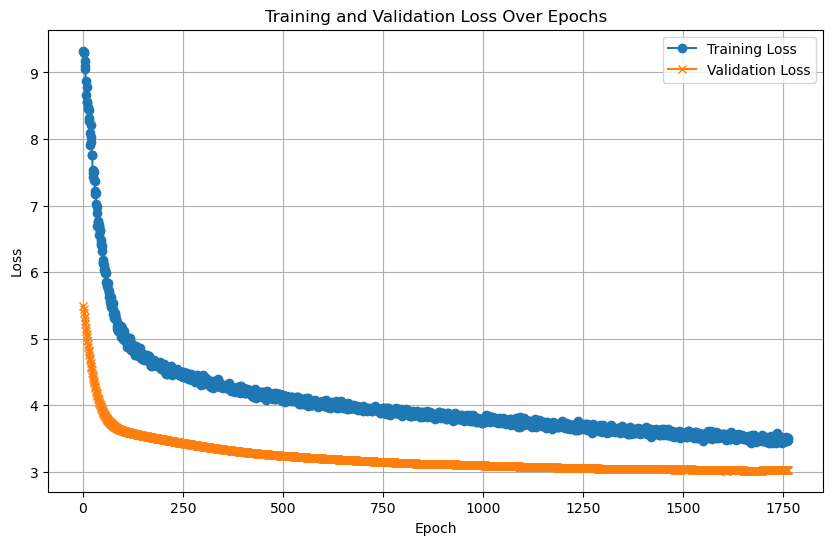

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.9996
Test Batch [20/40], Loss: 4.7681
Test Batch [30/40], Loss: 5.6320
Test Batch [40/40], Loss: 5.3282

Test Loss: 5.0324


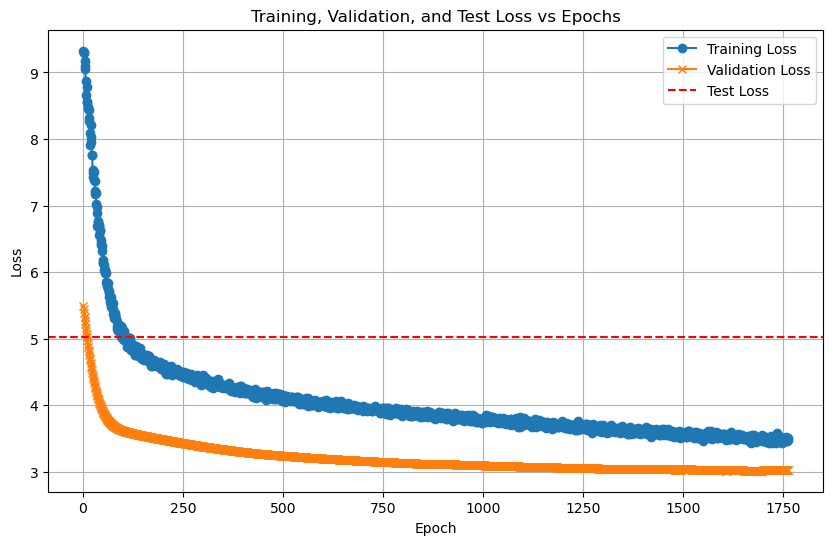

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 66.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         5
           3       0.83      1.00      0.91         5
           4       0.67      0.80      0.73         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5
           9       0.57      0.80      0.67         5
          10       0.00      0.00      0.00         5
          11       0.50      0.80      0.62         5
          12       0.56      1.00      0.71         5
          13       0.7

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8483  |  Val Loss: 3.0195
Validation loss improved from inf to 3.0195.
[Epoch 2/1000] Train Loss: 2.8218  |  Val Loss: 2.9926
Validation loss improved from 3.0195 to 2.9926.
[Epoch 3/1000] Train Loss: 2.8002  |  Val Loss: 2.9693
Validation loss improved from 2.9926 to 2.9693.
[Epoch 4/1000] Train Loss: 2.7818  |  Val Loss: 2.9479
Validation loss improved from 2.9693 to 2.9479.
[Epoch 5/1000] Train Loss: 2.7632  |  Val Loss: 2.9281
Validation loss improved from 2.9479 to 2.9281.
[Epoch 6/1000] Train Loss: 2.7465  |  Val Loss: 2.9091
Validation loss improved from 2.9281 to 2.9091.
[Epoch 7/1000] Train Loss: 2.7288  |  Val Loss: 2.8901
Validation loss improved from 2.9091 to 2.8901.


[Epoch 8/1000] Train Loss: 2.7134  |  Val Loss: 2.8727
Validation loss improved from 2.8901 to 2.8727.
[Epoch 9/1000] Train Loss: 2.6983  |  Val Loss: 2.8564
Validation loss improved from 2.8727 to 2.8564.
[Epoch 10/1000] Train Loss: 2.6844  |  Val Loss: 2.8421
Validation loss improved from 2.8564 to 2.8421.
[Epoch 11/1000] Train Loss: 2.6716  |  Val Loss: 2.8294
Validation loss improved from 2.8421 to 2.8294.
[Epoch 12/1000] Train Loss: 2.6602  |  Val Loss: 2.8174
Validation loss improved from 2.8294 to 2.8174.
[Epoch 13/1000] Train Loss: 2.6501  |  Val Loss: 2.8068
Validation loss improved from 2.8174 to 2.8068.
[Epoch 14/1000] Train Loss: 2.6405  |  Val Loss: 2.7977
Validation loss improved from 2.8068 to 2.7977.
[Epoch 15/1000] Train Loss: 2.6312  |  Val Loss: 2.7884
Validation loss improved from 2.7977 to 2.7884.
[Epoch 16/1000] Train Loss: 2.6227  |  Val Loss: 2.7791
Validation loss improved from 2.7884 to 2.7791.
[Epoch 17/1000] Train Loss: 2.6146  |  Val Loss: 2.7700
Validation

[Epoch 26/1000] Train Loss: 2.5515  |  Val Loss: 2.6972
Validation loss improved from 2.7051 to 2.6972.


[Epoch 27/1000] Train Loss: 2.5452  |  Val Loss: 2.6887
Validation loss improved from 2.6972 to 2.6887.
[Epoch 28/1000] Train Loss: 2.5385  |  Val Loss: 2.6807
Validation loss improved from 2.6887 to 2.6807.
[Epoch 29/1000] Train Loss: 2.5321  |  Val Loss: 2.6718
Validation loss improved from 2.6807 to 2.6718.
[Epoch 30/1000] Train Loss: 2.5252  |  Val Loss: 2.6637
Validation loss improved from 2.6718 to 2.6637.
[Epoch 31/1000] Train Loss: 2.5183  |  Val Loss: 2.6559
Validation loss improved from 2.6637 to 2.6559.
[Epoch 32/1000] Train Loss: 2.5114  |  Val Loss: 2.6480
Validation loss improved from 2.6559 to 2.6480.
[Epoch 33/1000] Train Loss: 2.5044  |  Val Loss: 2.6403
Validation loss improved from 2.6480 to 2.6403.
[Epoch 34/1000] Train Loss: 2.4973  |  Val Loss: 2.6327
Validation loss improved from 2.6403 to 2.6327.
[Epoch 35/1000] Train Loss: 2.4907  |  Val Loss: 2.6245
Validation loss improved from 2.6327 to 2.6245.
[Epoch 36/1000] Train Loss: 2.4844  |  Val Loss: 2.6164
Validati

[Epoch 37/1000] Train Loss: 2.4780  |  Val Loss: 2.6074
Validation loss improved from 2.6164 to 2.6074.
[Epoch 38/1000] Train Loss: 2.4717  |  Val Loss: 2.5987
Validation loss improved from 2.6074 to 2.5987.
[Epoch 39/1000] Train Loss: 2.4647  |  Val Loss: 2.5908
Validation loss improved from 2.5987 to 2.5908.
[Epoch 40/1000] Train Loss: 2.4584  |  Val Loss: 2.5832
Validation loss improved from 2.5908 to 2.5832.
[Epoch 41/1000] Train Loss: 2.4520  |  Val Loss: 2.5752
Validation loss improved from 2.5832 to 2.5752.
[Epoch 42/1000] Train Loss: 2.4452  |  Val Loss: 2.5670
Validation loss improved from 2.5752 to 2.5670.
[Epoch 43/1000] Train Loss: 2.4384  |  Val Loss: 2.5597
Validation loss improved from 2.5670 to 2.5597.
[Epoch 44/1000] Train Loss: 2.4320  |  Val Loss: 2.5521
Validation loss improved from 2.5597 to 2.5521.
[Epoch 45/1000] Train Loss: 2.4255  |  Val Loss: 2.5449
Validation loss improved from 2.5521 to 2.5449.
[Epoch 46/1000] Train Loss: 2.4191  |  Val Loss: 2.5377
Validati

[Epoch 53/1000] Train Loss: 2.3733  |  Val Loss: 2.4785
Validation loss improved from 2.4871 to 2.4785.
[Epoch 54/1000] Train Loss: 2.3666  |  Val Loss: 2.4701
Validation loss improved from 2.4785 to 2.4701.
[Epoch 55/1000] Train Loss: 2.3605  |  Val Loss: 2.4608
Validation loss improved from 2.4701 to 2.4608.
[Epoch 56/1000] Train Loss: 2.3537  |  Val Loss: 2.4526
Validation loss improved from 2.4608 to 2.4526.
[Epoch 57/1000] Train Loss: 2.3469  |  Val Loss: 2.4445
Validation loss improved from 2.4526 to 2.4445.
[Epoch 58/1000] Train Loss: 2.3405  |  Val Loss: 2.4361
Validation loss improved from 2.4445 to 2.4361.
[Epoch 59/1000] Train Loss: 2.3343  |  Val Loss: 2.4284
Validation loss improved from 2.4361 to 2.4284.
[Epoch 60/1000] Train Loss: 2.3274  |  Val Loss: 2.4207
Validation loss improved from 2.4284 to 2.4207.
[Epoch 61/1000] Train Loss: 2.3210  |  Val Loss: 2.4126
Validation loss improved from 2.4207 to 2.4126.


[Epoch 62/1000] Train Loss: 2.3143  |  Val Loss: 2.4047
Validation loss improved from 2.4126 to 2.4047.
[Epoch 63/1000] Train Loss: 2.3077  |  Val Loss: 2.3963
Validation loss improved from 2.4047 to 2.3963.
[Epoch 64/1000] Train Loss: 2.3014  |  Val Loss: 2.3879
Validation loss improved from 2.3963 to 2.3879.
[Epoch 65/1000] Train Loss: 2.2944  |  Val Loss: 2.3812
Validation loss improved from 2.3879 to 2.3812.
[Epoch 66/1000] Train Loss: 2.2882  |  Val Loss: 2.3741
Validation loss improved from 2.3812 to 2.3741.
[Epoch 67/1000] Train Loss: 2.2812  |  Val Loss: 2.3673
Validation loss improved from 2.3741 to 2.3673.
[Epoch 68/1000] Train Loss: 2.2744  |  Val Loss: 2.3597
Validation loss improved from 2.3673 to 2.3597.
[Epoch 69/1000] Train Loss: 2.2679  |  Val Loss: 2.3517
Validation loss improved from 2.3597 to 2.3517.
[Epoch 70/1000] Train Loss: 2.2608  |  Val Loss: 2.3440
Validation loss improved from 2.3517 to 2.3440.
[Epoch 71/1000] Train Loss: 2.2545  |  Val Loss: 2.3375
Validati

[Epoch 83/1000] Train Loss: 2.1727  |  Val Loss: 2.2574
Validation loss improved from 2.2637 to 2.2574.
[Epoch 84/1000] Train Loss: 2.1660  |  Val Loss: 2.2498
Validation loss improved from 2.2574 to 2.2498.
[Epoch 85/1000] Train Loss: 2.1590  |  Val Loss: 2.2440
Validation loss improved from 2.2498 to 2.2440.
[Epoch 86/1000] Train Loss: 2.1521  |  Val Loss: 2.2390
Validation loss improved from 2.2440 to 2.2390.
[Epoch 87/1000] Train Loss: 2.1453  |  Val Loss: 2.2330
Validation loss improved from 2.2390 to 2.2330.
[Epoch 88/1000] Train Loss: 2.1381  |  Val Loss: 2.2267
Validation loss improved from 2.2330 to 2.2267.
[Epoch 89/1000] Train Loss: 2.1313  |  Val Loss: 2.2198
Validation loss improved from 2.2267 to 2.2198.
[Epoch 90/1000] Train Loss: 2.1243  |  Val Loss: 2.2127
Validation loss improved from 2.2198 to 2.2127.


[Epoch 91/1000] Train Loss: 2.1170  |  Val Loss: 2.2059
Validation loss improved from 2.2127 to 2.2059.
[Epoch 92/1000] Train Loss: 2.1097  |  Val Loss: 2.1992
Validation loss improved from 2.2059 to 2.1992.
[Epoch 93/1000] Train Loss: 2.1026  |  Val Loss: 2.1905
Validation loss improved from 2.1992 to 2.1905.
[Epoch 94/1000] Train Loss: 2.0956  |  Val Loss: 2.1832
Validation loss improved from 2.1905 to 2.1832.
[Epoch 95/1000] Train Loss: 2.0885  |  Val Loss: 2.1767
Validation loss improved from 2.1832 to 2.1767.
[Epoch 96/1000] Train Loss: 2.0812  |  Val Loss: 2.1704
Validation loss improved from 2.1767 to 2.1704.
[Epoch 97/1000] Train Loss: 2.0738  |  Val Loss: 2.1634
Validation loss improved from 2.1704 to 2.1634.
[Epoch 98/1000] Train Loss: 2.0664  |  Val Loss: 2.1566
Validation loss improved from 2.1634 to 2.1566.
[Epoch 99/1000] Train Loss: 2.0592  |  Val Loss: 2.1499
Validation loss improved from 2.1566 to 2.1499.
[Epoch 100/1000] Train Loss: 2.0517  |  Val Loss: 2.1433
Validat

[Epoch 113/1000] Train Loss: 1.9477  |  Val Loss: 2.0579
Validation loss improved from 2.0624 to 2.0579.
[Epoch 114/1000] Train Loss: 1.9395  |  Val Loss: 2.0521
Validation loss improved from 2.0579 to 2.0521.
[Epoch 115/1000] Train Loss: 1.9309  |  Val Loss: 2.0469
Validation loss improved from 2.0521 to 2.0469.
[Epoch 116/1000] Train Loss: 1.9229  |  Val Loss: 2.0414
Validation loss improved from 2.0469 to 2.0414.
[Epoch 117/1000] Train Loss: 1.9154  |  Val Loss: 2.0358
Validation loss improved from 2.0414 to 2.0358.
[Epoch 118/1000] Train Loss: 1.9070  |  Val Loss: 2.0306
Validation loss improved from 2.0358 to 2.0306.
[Epoch 119/1000] Train Loss: 1.8988  |  Val Loss: 2.0242
Validation loss improved from 2.0306 to 2.0242.
[Epoch 120/1000] Train Loss: 1.8905  |  Val Loss: 2.0181
Validation loss improved from 2.0242 to 2.0181.


[Epoch 121/1000] Train Loss: 1.8827  |  Val Loss: 2.0118
Validation loss improved from 2.0181 to 2.0118.
[Epoch 122/1000] Train Loss: 1.8742  |  Val Loss: 2.0051
Validation loss improved from 2.0118 to 2.0051.
[Epoch 123/1000] Train Loss: 1.8657  |  Val Loss: 1.9988
Validation loss improved from 2.0051 to 1.9988.
[Epoch 124/1000] Train Loss: 1.8577  |  Val Loss: 1.9917
Validation loss improved from 1.9988 to 1.9917.
[Epoch 125/1000] Train Loss: 1.8493  |  Val Loss: 1.9839
Validation loss improved from 1.9917 to 1.9839.
[Epoch 126/1000] Train Loss: 1.8407  |  Val Loss: 1.9772
Validation loss improved from 1.9839 to 1.9772.
[Epoch 127/1000] Train Loss: 1.8325  |  Val Loss: 1.9686
Validation loss improved from 1.9772 to 1.9686.
[Epoch 128/1000] Train Loss: 1.8243  |  Val Loss: 1.9618
Validation loss improved from 1.9686 to 1.9618.
[Epoch 129/1000] Train Loss: 1.8157  |  Val Loss: 1.9553
Validation loss improved from 1.9618 to 1.9553.
[Epoch 130/1000] Train Loss: 1.8076  |  Val Loss: 1.950

[Epoch 142/1000] Train Loss: 1.7068  |  Val Loss: 1.8619
Validation loss improved from 1.8672 to 1.8619.
[Epoch 143/1000] Train Loss: 1.6976  |  Val Loss: 1.8570
Validation loss improved from 1.8619 to 1.8570.
[Epoch 144/1000] Train Loss: 1.6896  |  Val Loss: 1.8533
Validation loss improved from 1.8570 to 1.8533.
[Epoch 145/1000] Train Loss: 1.6809  |  Val Loss: 1.8475
Validation loss improved from 1.8533 to 1.8475.
[Epoch 146/1000] Train Loss: 1.6726  |  Val Loss: 1.8383
Validation loss improved from 1.8475 to 1.8383.
[Epoch 147/1000] Train Loss: 1.6641  |  Val Loss: 1.8299
Validation loss improved from 1.8383 to 1.8299.
[Epoch 148/1000] Train Loss: 1.6563  |  Val Loss: 1.8214
Validation loss improved from 1.8299 to 1.8214.
[Epoch 149/1000] Train Loss: 1.6477  |  Val Loss: 1.8142
Validation loss improved from 1.8214 to 1.8142.
[Epoch 150/1000] Train Loss: 1.6401  |  Val Loss: 1.8098
Validation loss improved from 1.8142 to 1.8098.
[Epoch 151/1000] Train Loss: 1.6315  |  Val Loss: 1.803

[Epoch 153/1000] Train Loss: 1.6149  |  Val Loss: 1.7881
Validation loss improved from 1.7959 to 1.7881.
[Epoch 154/1000] Train Loss: 1.6066  |  Val Loss: 1.7815
Validation loss improved from 1.7881 to 1.7815.
[Epoch 155/1000] Train Loss: 1.5981  |  Val Loss: 1.7754
Validation loss improved from 1.7815 to 1.7754.
[Epoch 156/1000] Train Loss: 1.5897  |  Val Loss: 1.7701
Validation loss improved from 1.7754 to 1.7701.
[Epoch 157/1000] Train Loss: 1.5817  |  Val Loss: 1.7629
Validation loss improved from 1.7701 to 1.7629.
[Epoch 158/1000] Train Loss: 1.5727  |  Val Loss: 1.7568
Validation loss improved from 1.7629 to 1.7568.
[Epoch 159/1000] Train Loss: 1.5653  |  Val Loss: 1.7502
Validation loss improved from 1.7568 to 1.7502.
[Epoch 160/1000] Train Loss: 1.5563  |  Val Loss: 1.7421
Validation loss improved from 1.7502 to 1.7421.
[Epoch 161/1000] Train Loss: 1.5487  |  Val Loss: 1.7358
Validation loss improved from 1.7421 to 1.7358.
[Epoch 162/1000] Train Loss: 1.5402  |  Val Loss: 1.726

[Epoch 171/1000] Train Loss: 1.4701  |  Val Loss: 1.6745
Validation loss improved from 1.6801 to 1.6745.
[Epoch 172/1000] Train Loss: 1.4625  |  Val Loss: 1.6684
Validation loss improved from 1.6745 to 1.6684.
[Epoch 173/1000] Train Loss: 1.4549  |  Val Loss: 1.6627
Validation loss improved from 1.6684 to 1.6627.
[Epoch 174/1000] Train Loss: 1.4475  |  Val Loss: 1.6581
Validation loss improved from 1.6627 to 1.6581.
[Epoch 175/1000] Train Loss: 1.4400  |  Val Loss: 1.6510
Validation loss improved from 1.6581 to 1.6510.
[Epoch 176/1000] Train Loss: 1.4325  |  Val Loss: 1.6454
Validation loss improved from 1.6510 to 1.6454.
[Epoch 177/1000] Train Loss: 1.4247  |  Val Loss: 1.6364
Validation loss improved from 1.6454 to 1.6364.
[Epoch 178/1000] Train Loss: 1.4175  |  Val Loss: 1.6273
Validation loss improved from 1.6364 to 1.6273.
[Epoch 179/1000] Train Loss: 1.4096  |  Val Loss: 1.6198
Validation loss improved from 1.6273 to 1.6198.
[Epoch 180/1000] Train Loss: 1.4024  |  Val Loss: 1.614

[Epoch 181/1000] Train Loss: 1.3954  |  Val Loss: 1.6099
Validation loss improved from 1.6147 to 1.6099.
[Epoch 182/1000] Train Loss: 1.3882  |  Val Loss: 1.6038
Validation loss improved from 1.6099 to 1.6038.
[Epoch 183/1000] Train Loss: 1.3813  |  Val Loss: 1.6010
Validation loss improved from 1.6038 to 1.6010.
[Epoch 184/1000] Train Loss: 1.3742  |  Val Loss: 1.5978
Validation loss improved from 1.6010 to 1.5978.
[Epoch 185/1000] Train Loss: 1.3670  |  Val Loss: 1.5939
Validation loss improved from 1.5978 to 1.5939.
[Epoch 186/1000] Train Loss: 1.3601  |  Val Loss: 1.5923
Validation loss improved from 1.5939 to 1.5923.
[Epoch 187/1000] Train Loss: 1.3523  |  Val Loss: 1.5895
Validation loss improved from 1.5923 to 1.5895.
[Epoch 188/1000] Train Loss: 1.3450  |  Val Loss: 1.5864
Validation loss improved from 1.5895 to 1.5864.
[Epoch 189/1000] Train Loss: 1.3379  |  Val Loss: 1.5822
Validation loss improved from 1.5864 to 1.5822.
[Epoch 190/1000] Train Loss: 1.3325  |  Val Loss: 1.578

[Epoch 198/1000] Train Loss: 1.2776  |  Val Loss: 1.5328
Validation loss improved from 1.5360 to 1.5328.
[Epoch 199/1000] Train Loss: 1.2710  |  Val Loss: 1.5269
Validation loss improved from 1.5328 to 1.5269.
[Epoch 200/1000] Train Loss: 1.2649  |  Val Loss: 1.5251
Validation loss improved from 1.5269 to 1.5251.
[Epoch 201/1000] Train Loss: 1.2584  |  Val Loss: 1.5185
Validation loss improved from 1.5251 to 1.5185.
[Epoch 202/1000] Train Loss: 1.2518  |  Val Loss: 1.5148
Validation loss improved from 1.5185 to 1.5148.
[Epoch 203/1000] Train Loss: 1.2462  |  Val Loss: 1.5120
Validation loss improved from 1.5148 to 1.5120.
[Epoch 204/1000] Train Loss: 1.2392  |  Val Loss: 1.5108
Validation loss improved from 1.5120 to 1.5108.
[Epoch 205/1000] Train Loss: 1.2335  |  Val Loss: 1.5108
Validation loss improved from 1.5108 to 1.5108.
[Epoch 206/1000] Train Loss: 1.2270  |  Val Loss: 1.5088
Validation loss improved from 1.5108 to 1.5088.
[Epoch 207/1000] Train Loss: 1.2212  |  Val Loss: 1.504

[Epoch 208/1000] Train Loss: 1.2150  |  Val Loss: 1.5034
Validation loss improved from 1.5048 to 1.5034.
[Epoch 209/1000] Train Loss: 1.2085  |  Val Loss: 1.4993
Validation loss improved from 1.5034 to 1.4993.
[Epoch 210/1000] Train Loss: 1.2029  |  Val Loss: 1.4930
Validation loss improved from 1.4993 to 1.4930.
[Epoch 211/1000] Train Loss: 1.1964  |  Val Loss: 1.4899
Validation loss improved from 1.4930 to 1.4899.
[Epoch 212/1000] Train Loss: 1.1903  |  Val Loss: 1.4832
Validation loss improved from 1.4899 to 1.4832.
[Epoch 213/1000] Train Loss: 1.1849  |  Val Loss: 1.4744
Validation loss improved from 1.4832 to 1.4744.
[Epoch 214/1000] Train Loss: 1.1786  |  Val Loss: 1.4695
Validation loss improved from 1.4744 to 1.4695.
[Epoch 215/1000] Train Loss: 1.1729  |  Val Loss: 1.4631
Validation loss improved from 1.4695 to 1.4631.
[Epoch 216/1000] Train Loss: 1.1670  |  Val Loss: 1.4574
Validation loss improved from 1.4631 to 1.4574.
[Epoch 217/1000] Train Loss: 1.1613  |  Val Loss: 1.449

[Epoch 226/1000] Train Loss: 1.1116  |  Val Loss: 1.4398
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 227/1000] Train Loss: 1.1066  |  Val Loss: 1.4390
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 228/1000] Train Loss: 1.1007  |  Val Loss: 1.4353
Validation loss improved from 1.4362 to 1.4353.
[Epoch 229/1000] Train Loss: 1.0955  |  Val Loss: 1.4308
Validation loss improved from 1.4353 to 1.4308.
[Epoch 230/1000] Train Loss: 1.0902  |  Val Loss: 1.4216
Validation loss improved from 1.4308 to 1.4216.
[Epoch 231/1000] Train Loss: 1.0849  |  Val Loss: 1.4124
Validation loss improved from 1.4216 to 1.4124.
[Epoch 232/1000] Train Loss: 1.0792  |  Val Loss: 1.4034
Validation loss improved from 1.4124 to 1.4034.
[Epoch 233/1000] Train Loss: 1.0741  |  Val Loss: 1.3920
Validation loss improved from 1.4034 to 1.3920.
[Epoch 234/1000] Train Loss: 1.0692  |  Val Loss: 1.3832
Validation loss improved from 1.3920 to 1.3832.
[Epoch 235/1000] Train Loss: 1.0649  |  Val

[Epoch 239/1000] Train Loss: 1.0437  |  Val Loss: 1.3882
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 240/1000] Train Loss: 1.0387  |  Val Loss: 1.3863
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 241/1000] Train Loss: 1.0331  |  Val Loss: 1.3819
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 242/1000] Train Loss: 1.0284  |  Val Loss: 1.3749
Validation loss improved from 1.3781 to 1.3749.
[Epoch 243/1000] Train Loss: 1.0237  |  Val Loss: 1.3690
Validation loss improved from 1.3749 to 1.3690.
[Epoch 244/1000] Train Loss: 1.0184  |  Val Loss: 1.3662
Validation loss improved from 1.3690 to 1.3662.
[Epoch 245/1000] Train Loss: 1.0133  |  Val Loss: 1.3644
Validation loss improved from 1.3662 to 1.3644.
[Epoch 246/1000] Train Loss: 1.0082  |  Val Loss: 1.3609
Validation loss improved from 1.3644 to 1.3609.
[Epoch 247/1000] Train Loss: 1.0035  |  Val Loss: 1.3571
Validation loss improved from 1.3609 to 1.3571.
[Epoch 248/1000] Train Loss: 0.9992  

[Epoch 256/1000] Train Loss: 0.9631  |  Val Loss: 1.3268
Validation loss improved from 1.3349 to 1.3268.
[Epoch 257/1000] Train Loss: 0.9582  |  Val Loss: 1.3217
Validation loss improved from 1.3268 to 1.3217.
[Epoch 258/1000] Train Loss: 0.9539  |  Val Loss: 1.3188
Validation loss improved from 1.3217 to 1.3188.
[Epoch 259/1000] Train Loss: 0.9502  |  Val Loss: 1.3167
Validation loss improved from 1.3188 to 1.3167.
[Epoch 260/1000] Train Loss: 0.9457  |  Val Loss: 1.3139
Validation loss improved from 1.3167 to 1.3139.
[Epoch 261/1000] Train Loss: 0.9412  |  Val Loss: 1.3123
Validation loss improved from 1.3139 to 1.3123.
[Epoch 262/1000] Train Loss: 0.9380  |  Val Loss: 1.3117
Validation loss improved from 1.3123 to 1.3117.
[Epoch 263/1000] Train Loss: 0.9332  |  Val Loss: 1.3053
Validation loss improved from 1.3117 to 1.3053.
[Epoch 264/1000] Train Loss: 0.9292  |  Val Loss: 1.3063
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 0.9254  |  Val Loss:

[Epoch 269/1000] Train Loss: 0.9095  |  Val Loss: 1.2870
Validation loss improved from 1.2911 to 1.2870.
[Epoch 270/1000] Train Loss: 0.9051  |  Val Loss: 1.2870
Validation loss improved from 1.2870 to 1.2870.
[Epoch 271/1000] Train Loss: 0.9010  |  Val Loss: 1.2884
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 0.8973  |  Val Loss: 1.2903
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 273/1000] Train Loss: 0.8937  |  Val Loss: 1.2904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 274/1000] Train Loss: 0.8896  |  Val Loss: 1.2867
Validation loss improved from 1.2870 to 1.2867.
[Epoch 275/1000] Train Loss: 0.8858  |  Val Loss: 1.2794
Validation loss improved from 1.2867 to 1.2794.
[Epoch 276/1000] Train Loss: 0.8825  |  Val Loss: 1.2725
Validation loss improved from 1.2794 to 1.2725.
[Epoch 277/1000] Train Loss: 0.8781  |  Val Loss: 1.2718
Validation loss improved from 1.2725 to 1.2718.
[Epoch 278/1000] Train Loss: 0.8738  

[Epoch 287/1000] Train Loss: 0.8387  |  Val Loss: 1.2384
Validation loss improved from 1.2397 to 1.2384.
[Epoch 288/1000] Train Loss: 0.8348  |  Val Loss: 1.2425
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 0.8316  |  Val Loss: 1.2455
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 290/1000] Train Loss: 0.8280  |  Val Loss: 1.2424
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 291/1000] Train Loss: 0.8246  |  Val Loss: 1.2375
Validation loss improved from 1.2384 to 1.2375.
[Epoch 292/1000] Train Loss: 0.8209  |  Val Loss: 1.2327
Validation loss improved from 1.2375 to 1.2327.
[Epoch 293/1000] Train Loss: 0.8186  |  Val Loss: 1.2251
Validation loss improved from 1.2327 to 1.2251.
[Epoch 294/1000] Train Loss: 0.8162  |  Val Loss: 1.2243
Validation loss improved from 1.2251 to 1.2243.
[Epoch 295/1000] Train Loss: 0.8127  |  Val Loss: 1.2218
Validation loss improved from 1.2243 to 1.2218.
[Epoch 296/1000] Train Loss: 0.8091  

[Epoch 302/1000] Train Loss: 0.7913  |  Val Loss: 1.2235
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 303/1000] Train Loss: 0.7881  |  Val Loss: 1.2176
Validation loss improved from 1.2199 to 1.2176.
[Epoch 304/1000] Train Loss: 0.7860  |  Val Loss: 1.2102
Validation loss improved from 1.2176 to 1.2102.
[Epoch 305/1000] Train Loss: 0.7827  |  Val Loss: 1.2041
Validation loss improved from 1.2102 to 1.2041.
[Epoch 306/1000] Train Loss: 0.7800  |  Val Loss: 1.1984
Validation loss improved from 1.2041 to 1.1984.
[Epoch 307/1000] Train Loss: 0.7772  |  Val Loss: 1.1948
Validation loss improved from 1.1984 to 1.1948.
[Epoch 308/1000] Train Loss: 0.7736  |  Val Loss: 1.1943
Validation loss improved from 1.1948 to 1.1943.
[Epoch 309/1000] Train Loss: 0.7710  |  Val Loss: 1.1930
Validation loss improved from 1.1943 to 1.1930.
[Epoch 310/1000] Train Loss: 0.7683  |  Val Loss: 1.1968
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 311/1000] Train Loss: 0.7666  |  Val

[Epoch 315/1000] Train Loss: 0.7551  |  Val Loss: 1.1922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 316/1000] Train Loss: 0.7527  |  Val Loss: 1.1965
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 317/1000] Train Loss: 0.7505  |  Val Loss: 1.1978
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 318/1000] Train Loss: 0.7483  |  Val Loss: 1.1932
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 319/1000] Train Loss: 0.7458  |  Val Loss: 1.1906
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 320/1000] Train Loss: 0.7431  |  Val Loss: 1.1861
Validation loss improved from 1.1889 to 1.1861.
[Epoch 321/1000] Train Loss: 0.7415  |  Val Loss: 1.1796
Validation loss improved from 1.1861 to 1.1796.
[Epoch 322/1000] Train Loss: 0.7389  |  Val Loss: 1.1681
Validation loss improved from 1.1796 to 1.1681.
[Epoch 323/1000] Train Loss: 0.7372  |  Val Loss: 1.1625
Validation loss improved from 1.1681 to 1.1625.
[Epoch 324/1000] Train Lo

[Epoch 328/1000] Train Loss: 0.7256  |  Val Loss: 1.1832
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 329/1000] Train Loss: 0.7223  |  Val Loss: 1.1800
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 330/1000] Train Loss: 0.7202  |  Val Loss: 1.1746
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 331/1000] Train Loss: 0.7179  |  Val Loss: 1.1706
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 332/1000] Train Loss: 0.7161  |  Val Loss: 1.1623
Validation loss improved from 1.1625 to 1.1623.
[Epoch 333/1000] Train Loss: 0.7143  |  Val Loss: 1.1568
Validation loss improved from 1.1623 to 1.1568.
[Epoch 334/1000] Train Loss: 0.7116  |  Val Loss: 1.1589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 335/1000] Train Loss: 0.7097  |  Val Loss: 1.1609
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 336/1000] Train Loss: 0.7078  |  Val Loss: 1.1630
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 337/10

[Epoch 342/1000] Train Loss: 0.6954  |  Val Loss: 1.1551
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/1000] Train Loss: 0.6933  |  Val Loss: 1.1535
Validation loss improved from 1.1543 to 1.1535.
[Epoch 344/1000] Train Loss: 0.6917  |  Val Loss: 1.1542
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 345/1000] Train Loss: 0.6898  |  Val Loss: 1.1508
Validation loss improved from 1.1535 to 1.1508.
[Epoch 346/1000] Train Loss: 0.6880  |  Val Loss: 1.1510
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 347/1000] Train Loss: 0.6859  |  Val Loss: 1.1484
Validation loss improved from 1.1508 to 1.1484.
[Epoch 348/1000] Train Loss: 0.6841  |  Val Loss: 1.1482
Validation loss improved from 1.1484 to 1.1482.
[Epoch 349/1000] Train Loss: 0.6821  |  Val Loss: 1.1475
Validation loss improved from 1.1482 to 1.1475.
[Epoch 350/1000] Train Loss: 0.6800  |  Val Loss: 1.1514
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 351/1000] Train Loss: 0.

[Epoch 358/1000] Train Loss: 0.6669  |  Val Loss: 1.1289
Validation loss improved from 1.1341 to 1.1289.
[Epoch 359/1000] Train Loss: 0.6661  |  Val Loss: 1.1249
Validation loss improved from 1.1289 to 1.1249.
[Epoch 360/1000] Train Loss: 0.6648  |  Val Loss: 1.1287
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 361/1000] Train Loss: 0.6622  |  Val Loss: 1.1337
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 362/1000] Train Loss: 0.6604  |  Val Loss: 1.1381
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 363/1000] Train Loss: 0.6584  |  Val Loss: 1.1412
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 364/1000] Train Loss: 0.6570  |  Val Loss: 1.1467
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 365/1000] Train Loss: 0.6554  |  Val Loss: 1.1488
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 366/1000] Train Loss: 0.6538  |  Val Loss: 1.1474
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 367/10

[Epoch 372/1000] Train Loss: 0.6460  |  Val Loss: 1.1488
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 373/1000] Train Loss: 0.6433  |  Val Loss: 1.1447
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 374/1000] Train Loss: 0.6416  |  Val Loss: 1.1368
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 375/1000] Train Loss: 0.6406  |  Val Loss: 1.1326
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 376/1000] Train Loss: 0.6386  |  Val Loss: 1.1359
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 377/1000] Train Loss: 0.6382  |  Val Loss: 1.1395
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 378/1000] Train Loss: 0.6364  |  Val Loss: 1.1403
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 379/1000] Train Loss: 0.6347  |  Val Loss: 1.1366
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 380/1000] Train Loss: 0.6337  |  Val Loss: 1.1371
!! Validation loss did NOT improve !! Patience:

[Epoch 387/1000] Train Loss: 0.6238  |  Val Loss: 1.1304
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 388/1000] Train Loss: 0.6230  |  Val Loss: 1.1297
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 389/1000] Train Loss: 0.6212  |  Val Loss: 1.1318
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 390/1000] Train Loss: 0.6205  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 391/1000] Train Loss: 0.6186  |  Val Loss: 1.1364
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 392/1000] Train Loss: 0.6176  |  Val Loss: 1.1375
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 393/1000] Train Loss: 0.6163  |  Val Loss: 1.1394
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 394/1000] Train Loss: 0.6151  |  Val Loss: 1.1376
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 395/1000] Train Loss: 0.6149  |  Val Loss: 1.1321
!! Validation loss did NOT improve !! Patience:

[Epoch 402/1000] Train Loss: 0.6060  |  Val Loss: 1.1248
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 403/1000] Train Loss: 0.6040  |  Val Loss: 1.1267
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 404/1000] Train Loss: 0.6029  |  Val Loss: 1.1284
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 405/1000] Train Loss: 0.6028  |  Val Loss: 1.1311
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 406/1000] Train Loss: 0.6023  |  Val Loss: 1.1310
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 407/1000] Train Loss: 0.6003  |  Val Loss: 1.1313
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 408/1000] Train Loss: 0.5992  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 409/1000] Train Loss: 0.5974  |  Val Loss: 1.1347
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 410/1000] Train Loss: 0.5960  |  Val Loss: 1.1313
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 416/1000] Train Loss: 0.5896  |  Val Loss: 1.1201
Validation loss improved from 1.1233 to 1.1201.
[Epoch 417/1000] Train Loss: 0.5892  |  Val Loss: 1.1160
Validation loss improved from 1.1201 to 1.1160.
[Epoch 418/1000] Train Loss: 0.5879  |  Val Loss: 1.1173
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 419/1000] Train Loss: 0.5863  |  Val Loss: 1.1207
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 420/1000] Train Loss: 0.5852  |  Val Loss: 1.1246
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 421/1000] Train Loss: 0.5846  |  Val Loss: 1.1298
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 422/1000] Train Loss: 0.5835  |  Val Loss: 1.1291
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 423/1000] Train Loss: 0.5823  |  Val Loss: 1.1310
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 424/1000] Train Loss: 0.5811  |  Val Loss: 1.1284
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 425/10

[Epoch 432/1000] Train Loss: 0.5742  |  Val Loss: 1.1281
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 433/1000] Train Loss: 0.5731  |  Val Loss: 1.1221
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 434/1000] Train Loss: 0.5719  |  Val Loss: 1.1185
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 435/1000] Train Loss: 0.5710  |  Val Loss: 1.1160
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 436/1000] Train Loss: 0.5693  |  Val Loss: 1.1157
Validation loss improved from 1.1160 to 1.1157.
[Epoch 437/1000] Train Loss: 0.5687  |  Val Loss: 1.1167
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 438/1000] Train Loss: 0.5683  |  Val Loss: 1.1187
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 439/1000] Train Loss: 0.5679  |  Val Loss: 1.1221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 440/1000] Train Loss: 0.5677  |  Val Loss: 1.1218
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 444/1000] Train Loss: 0.5633  |  Val Loss: 1.1367
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 445/1000] Train Loss: 0.5625  |  Val Loss: 1.1381
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 446/1000] Train Loss: 0.5617  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 447/1000] Train Loss: 0.5603  |  Val Loss: 1.1277
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 448/1000] Train Loss: 0.5592  |  Val Loss: 1.1209
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 449/1000] Train Loss: 0.5595  |  Val Loss: 1.1163
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 450/1000] Train Loss: 0.5578  |  Val Loss: 1.1186
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 451/1000] Train Loss: 0.5570  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 452/1000] Train Loss: 0.5568  |  Val Loss: 1.1288
!! Validation loss did NOT improve !! Patience: 1

[Epoch 460/1000] Train Loss: 0.5498  |  Val Loss: 1.1191
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 461/1000] Train Loss: 0.5486  |  Val Loss: 1.1246
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 462/1000] Train Loss: 0.5476  |  Val Loss: 1.1339
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 463/1000] Train Loss: 0.5474  |  Val Loss: 1.1411
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 464/1000] Train Loss: 0.5459  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 465/1000] Train Loss: 0.5460  |  Val Loss: 1.1455
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 466/1000] Train Loss: 0.5446  |  Val Loss: 1.1384
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 467/1000] Train Loss: 0.5439  |  Val Loss: 1.1334
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 468/1000] Train Loss: 0.5435  |  Val Loss: 1.1318
!! Validation loss did NOT improve !! Patience:

[Epoch 471/1000] Train Loss: 0.5413  |  Val Loss: 1.1319
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 472/1000] Train Loss: 0.5404  |  Val Loss: 1.1307
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 473/1000] Train Loss: 0.5392  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 474/1000] Train Loss: 0.5391  |  Val Loss: 1.1276
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 475/1000] Train Loss: 0.5388  |  Val Loss: 1.1307
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 476/1000] Train Loss: 0.5376  |  Val Loss: 1.1320
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 477/1000] Train Loss: 0.5371  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 478/1000] Train Loss: 0.5368  |  Val Loss: 1.1362
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 479/1000] Train Loss: 0.5360  |  Val Loss: 1.1423
!! Validation loss did NOT improve !! Patience:

[Epoch 484/1000] Train Loss: 0.5327  |  Val Loss: 1.1313
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 485/1000] Train Loss: 0.5316  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 486/1000] Train Loss: 0.5317  |  Val Loss: 1.1372
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 487/1000] Train Loss: 0.5305  |  Val Loss: 1.1355
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 488/1000] Train Loss: 0.5302  |  Val Loss: 1.1325
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 489/1000] Train Loss: 0.5297  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 490/1000] Train Loss: 0.5284  |  Val Loss: 1.1350
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 491/1000] Train Loss: 0.5282  |  Val Loss: 1.1400
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 492/1000] Train Loss: 0.5278  |  Val Loss: 1.1423
!! Validation loss did NOT improve !! Patience:

[Epoch 499/1000] Train Loss: 0.5236  |  Val Loss: 1.1469
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 500/1000] Train Loss: 0.5239  |  Val Loss: 1.1496
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 501/1000] Train Loss: 0.5224  |  Val Loss: 1.1466
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 502/1000] Train Loss: 0.5214  |  Val Loss: 1.1439
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 503/1000] Train Loss: 0.5207  |  Val Loss: 1.1411
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 504/1000] Train Loss: 0.5210  |  Val Loss: 1.1434
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 505/1000] Train Loss: 0.5201  |  Val Loss: 1.1444
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 506/1000] Train Loss: 0.5202  |  Val Loss: 1.1438
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 507/1000] Train Loss: 0.5201  |  Val Loss: 1.1429
!! Validation loss did NOT improve !! Patience:

[Epoch 513/1000] Train Loss: 0.5150  |  Val Loss: 1.1430
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 514/1000] Train Loss: 0.5145  |  Val Loss: 1.1438
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 515/1000] Train Loss: 0.5145  |  Val Loss: 1.1469
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 516/1000] Train Loss: 0.5161  |  Val Loss: 1.1466
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 517/1000] Train Loss: 0.5154  |  Val Loss: 1.1461
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 518/1000] Train Loss: 0.5135  |  Val Loss: 1.1487
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 519/1000] Train Loss: 0.5119  |  Val Loss: 1.1484
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 520/1000] Train Loss: 0.5118  |  Val Loss: 1.1502
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 521/1000] Train Loss: 0.5112  |  Val Loss: 1.1479
!! Validation loss did NOT improve !! Patience:

[Epoch 529/1000] Train Loss: 0.5081  |  Val Loss: 1.1472
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 530/1000] Train Loss: 0.5071  |  Val Loss: 1.1497
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 531/1000] Train Loss: 0.5061  |  Val Loss: 1.1506
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 532/1000] Train Loss: 0.5045  |  Val Loss: 1.1554
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 533/1000] Train Loss: 0.5057  |  Val Loss: 1.1590
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 534/1000] Train Loss: 0.5050  |  Val Loss: 1.1613
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 535/1000] Train Loss: 0.5047  |  Val Loss: 1.1627
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 536/1000] Train Loss: 0.5040  |  Val Loss: 1.1611
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 536 !!
No improvement for 100 epochs.


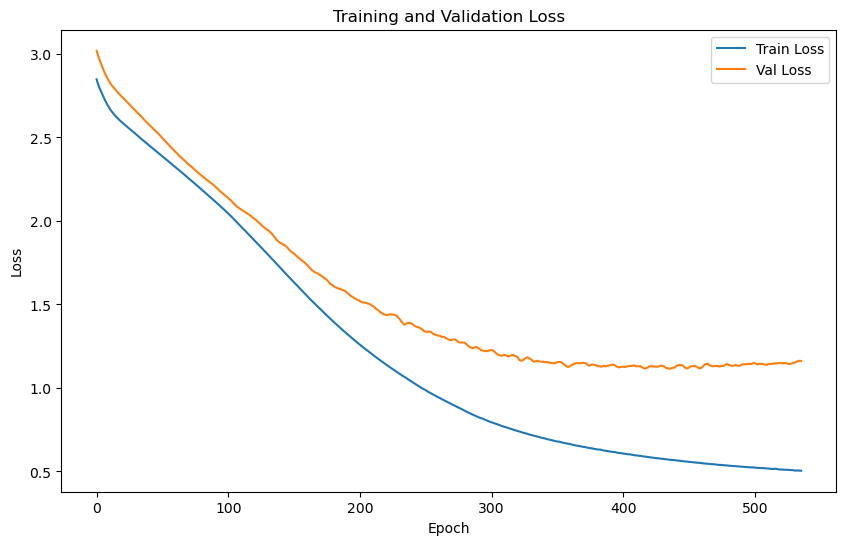

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.7455 | Test Accuracy: 43.83%


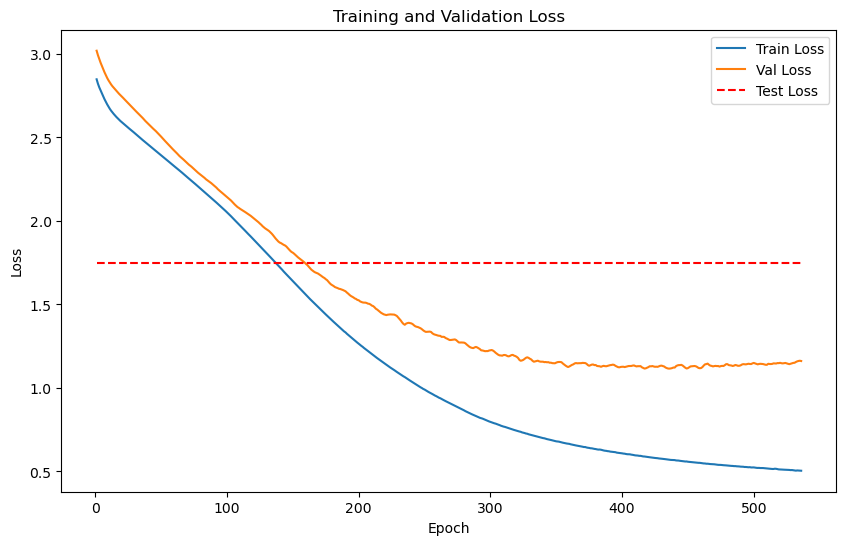

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.3623
Epoch [1/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.4301

Validation loss improved from inf to 0.4301. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.3617
Epoch [2/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.4291

Validation loss improved from 0.4301 to 0.4291. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5088
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.3613
Epoch [3/2000], Avg Train Loss: 0.5088, Avg Val Loss: 0.4282

Validation loss improved from 0.4291 to 0.4282. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5117
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3610
Epoch [4/2000], Avg Train Loss: 0.5117, Avg Val Loss: 0.4275

Validation loss improved from 0.4282 to 0.4275. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.3606
Epoch [5/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.4268

Validation loss improved from 0.4275 to 0.4268. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.3599
Epoch [6/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.4260

Validation loss improved from 0.4268 to 0.4260. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5062
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.3591
Epoch [7/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.4251

Validation loss improved from 0.4260 to 0.4251. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5077
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.3587
Epoch [8/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.4243

Validation loss improved from 0.4251 to 0.4243. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.3584
Epoch [9/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.4236

Validation loss improved from 0.4243 to 0.4236. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5069
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.3582
Epoch [10/2000], Avg Train Loss: 0.5069, Avg Val Loss: 0.4231

Validation loss improved from 0.4236 to 0.4231. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3582
Epoch [11/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.4226

Validation loss improved from 0.4231 to 0.4226. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.3581
Epoch [12/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.4224

Validation loss improved from 0.4226 to 0.4224. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3582
Epoch [13/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3583
Epoch [14/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.4224

Validation loss improved from 0.4224 to 0.4224. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.3585
Epoch [15/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.4223

Validation loss improved from 0.4224 to 0.4223. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.3588
Epoch [16/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.4223

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.3592
Epoch [17/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.4224

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.3597
Epoch [18/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.4224

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.3601
Epoch [19/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3604
Epoch [20/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3605
Epoch [21/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.4223

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3605
Epoch [22/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.4220

Validation loss improved from 0.4223 to 0.4220. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.3603
Epoch [23/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4216

Validation loss improved from 0.4220 to 0.4216. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.3603
Epoch [24/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.4212

Validation loss improved from 0.4216 to 0.4212. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.3604
Epoch [25/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.4209

Validation loss improved from 0.4212 to 0.4209. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.3606
Epoch [26/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.4206

Validation loss improved from 0.4209 to 0.4206. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.3608
Epoch [27/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.4204

Validation loss improved from 0.4206 to 0.4204. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.3609
Epoch [28/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4202

Validation loss improved from 0.4204 to 0.4202. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3610
Epoch [29/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.4200

Validation loss improved from 0.4202 to 0.4200. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3611
Epoch [30/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4198

Validation loss improved from 0.4200 to 0.4198. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3613
Epoch [31/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.4196

Validation loss improved from 0.4198 to 0.4196. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3614
Epoch [32/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.4194

Validation loss improved from 0.4196 to 0.4194. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3614
Epoch [33/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4192

Validation loss improved from 0.4194 to 0.4192. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3614
Epoch [34/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.4190

Validation loss improved from 0.4192 to 0.4190. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3613
Epoch [35/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4189

Validation loss improved from 0.4190 to 0.4189. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.3613
Epoch [36/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4187

Validation loss improved from 0.4189 to 0.4187. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.3611
Epoch [37/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4185

Validation loss improved from 0.4187 to 0.4185. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.3610
Epoch [38/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4183

Validation loss improved from 0.4185 to 0.4183. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.3609
Epoch [39/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4181

Validation loss improved from 0.4183 to 0.4181. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.3607
Epoch [40/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4179

Validation loss improved from 0.4181 to 0.4179. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3606
Epoch [41/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4177

Validation loss improved from 0.4179 to 0.4177. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.3604
Epoch [42/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4175

Validation loss improved from 0.4177 to 0.4175. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.3603
Epoch [43/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4173

Validation loss improved from 0.4175 to 0.4173. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3601
Epoch [44/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4171

Validation loss improved from 0.4173 to 0.4171. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.3600
Epoch [45/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4168

Validation loss improved from 0.4171 to 0.4168. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.3598
Epoch [46/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4166

Validation loss improved from 0.4168 to 0.4166. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.3596
Epoch [47/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4164

Validation loss improved from 0.4166 to 0.4164. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.3594
Epoch [48/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4161

Validation loss improved from 0.4164 to 0.4161. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.3592
Epoch [49/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4159

Validation loss improved from 0.4161 to 0.4159. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.3589
Epoch [50/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4156

Validation loss improved from 0.4159 to 0.4156. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.3586
Epoch [51/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4152

Validation loss improved from 0.4156 to 0.4152. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.3582
Epoch [52/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4149

Validation loss improved from 0.4152 to 0.4149. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3579
Epoch [53/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4146

Validation loss improved from 0.4149 to 0.4146. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3575
Epoch [54/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4143

Validation loss improved from 0.4146 to 0.4143. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3572
Epoch [55/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4140

Validation loss improved from 0.4143 to 0.4140. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3568
Epoch [56/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4137

Validation loss improved from 0.4140 to 0.4137. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3565
Epoch [57/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4133

Validation loss improved from 0.4137 to 0.4133. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3561
Epoch [58/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4130

Validation loss improved from 0.4133 to 0.4130. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3558
Epoch [59/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4127

Validation loss improved from 0.4130 to 0.4127. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3555
Epoch [60/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4124

Validation loss improved from 0.4127 to 0.4124. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.3551
Epoch [61/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4121

Validation loss improved from 0.4124 to 0.4121. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.3548
Epoch [62/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4119

Validation loss improved from 0.4121 to 0.4119. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3545
Epoch [63/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4116

Validation loss improved from 0.4119 to 0.4116. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3543
Epoch [64/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4114

Validation loss improved from 0.4116 to 0.4114. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.3540
Epoch [65/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4111

Validation loss improved from 0.4114 to 0.4111. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.3538
Epoch [66/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4109

Validation loss improved from 0.4111 to 0.4109. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.3535
Epoch [67/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4107

Validation loss improved from 0.4109 to 0.4107. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3532
Epoch [68/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4104

Validation loss improved from 0.4107 to 0.4104. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.3530
Epoch [69/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4102

Validation loss improved from 0.4104 to 0.4102. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.3527
Epoch [70/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4100

Validation loss improved from 0.4102 to 0.4100. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3525
Epoch [71/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4097

Validation loss improved from 0.4100 to 0.4097. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3522
Epoch [72/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4095

Validation loss improved from 0.4097 to 0.4095. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.3520
Epoch [73/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4092

Validation loss improved from 0.4095 to 0.4092. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3518
Epoch [74/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4090

Validation loss improved from 0.4092 to 0.4090. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3516
Epoch [75/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4088

Validation loss improved from 0.4090 to 0.4088. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.3514
Epoch [76/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4086

Validation loss improved from 0.4088 to 0.4086. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.3512
Epoch [77/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4084

Validation loss improved from 0.4086 to 0.4084. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.3510
Epoch [78/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4082

Validation loss improved from 0.4084 to 0.4082. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.3507
Epoch [79/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4080

Validation loss improved from 0.4082 to 0.4080. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3505
Epoch [80/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4078

Validation loss improved from 0.4080 to 0.4078. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.3503
Epoch [81/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4075

Validation loss improved from 0.4078 to 0.4075. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.3501
Epoch [82/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.4073

Validation loss improved from 0.4075 to 0.4073. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.3499
Epoch [83/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4071

Validation loss improved from 0.4073 to 0.4071. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.3497
Epoch [84/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4069

Validation loss improved from 0.4071 to 0.4069. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.3496
Epoch [85/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4067

Validation loss improved from 0.4069 to 0.4067. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3495
Epoch [86/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4065

Validation loss improved from 0.4067 to 0.4065. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.3493
Epoch [87/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4063

Validation loss improved from 0.4065 to 0.4063. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.3492
Epoch [88/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4062

Validation loss improved from 0.4063 to 0.4062. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.3490
Epoch [89/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4060

Validation loss improved from 0.4062 to 0.4060. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.3489
Epoch [90/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4058

Validation loss improved from 0.4060 to 0.4058. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.3486
Epoch [91/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4055

Validation loss improved from 0.4058 to 0.4055. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.3484
Epoch [92/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4053

Validation loss improved from 0.4055 to 0.4053. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.3481
Epoch [93/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4051

Validation loss improved from 0.4053 to 0.4051. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3478
Epoch [94/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4048

Validation loss improved from 0.4051 to 0.4048. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3476
Epoch [95/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4046

Validation loss improved from 0.4048 to 0.4046. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3473
Epoch [96/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4043

Validation loss improved from 0.4046 to 0.4043. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3471
Epoch [97/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4041

Validation loss improved from 0.4043 to 0.4041. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3469
Epoch [98/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4039

Validation loss improved from 0.4041 to 0.4039. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3467
Epoch [99/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4037

Validation loss improved from 0.4039 to 0.4037. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.3465
Epoch [100/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4035

Validation loss improved from 0.4037 to 0.4035. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.3463
Epoch [101/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4033

Validation loss improved from 0.4035 to 0.4033. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.3462
Epoch [102/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4031

Validation loss improved from 0.4033 to 0.4031. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.3460
Epoch [103/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4029

Validation loss improved from 0.4031 to 0.4029. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.3458
Epoch [104/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.3456
Epoch [105/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.3453
Epoch [106/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4023

Validation loss improved from 0.4025 to 0.4023. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.3451
Epoch [107/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4021

Validation loss improved from 0.4023 to 0.4021. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.3449
Epoch [108/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4019

Validation loss improved from 0.4021 to 0.4019. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3448
Epoch [109/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4017

Validation loss improved from 0.4019 to 0.4017. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3447
Epoch [110/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4015

Validation loss improved from 0.4017 to 0.4015. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.3445
Epoch [111/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4013

Validation loss improved from 0.4015 to 0.4013. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.3443
Epoch [112/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4012

Validation loss improved from 0.4013 to 0.4012. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3442
Epoch [113/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4010

Validation loss improved from 0.4012 to 0.4010. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.3440
Epoch [114/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4008

Validation loss improved from 0.4010 to 0.4008. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.3437
Epoch [115/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3435
Epoch [116/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4004

Validation loss improved from 0.4006 to 0.4004. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.3434
Epoch [117/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3432
Epoch [118/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4000

Validation loss improved from 0.4002 to 0.4000. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3429
Epoch [119/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.3998

Validation loss improved from 0.4000 to 0.3998. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.3428
Epoch [120/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.3996

Validation loss improved from 0.3998 to 0.3996. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.3426
Epoch [121/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.3994

Validation loss improved from 0.3996 to 0.3994. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3425
Epoch [122/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3992

Validation loss improved from 0.3994 to 0.3992. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.3423
Epoch [123/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.3989

Validation loss improved from 0.3992 to 0.3989. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.3421
Epoch [124/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.3987

Validation loss improved from 0.3989 to 0.3987. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.3420
Epoch [125/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3985

Validation loss improved from 0.3987 to 0.3985. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.3418
Epoch [126/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3983

Validation loss improved from 0.3985 to 0.3983. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.3417
Epoch [127/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3981

Validation loss improved from 0.3983 to 0.3981. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.3415
Epoch [128/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.3979

Validation loss improved from 0.3981 to 0.3979. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3413
Epoch [129/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3977

Validation loss improved from 0.3979 to 0.3977. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3412
Epoch [130/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3975

Validation loss improved from 0.3977 to 0.3975. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.3411
Epoch [131/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.3973

Validation loss improved from 0.3975 to 0.3973. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.3409
Epoch [132/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3971

Validation loss improved from 0.3973 to 0.3971. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3408
Epoch [133/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.3406
Epoch [134/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.3967

Validation loss improved from 0.3970 to 0.3967. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.3404
Epoch [135/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3965

Validation loss improved from 0.3967 to 0.3965. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.3403
Epoch [136/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3964

Validation loss improved from 0.3965 to 0.3964. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.3402
Epoch [137/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3962

Validation loss improved from 0.3964 to 0.3962. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.3400
Epoch [138/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.3959

Validation loss improved from 0.3962 to 0.3959. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.3398
Epoch [139/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.3957

Validation loss improved from 0.3959 to 0.3957. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.3397
Epoch [140/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.3955

Validation loss improved from 0.3957 to 0.3955. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3396
Epoch [141/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.3953

Validation loss improved from 0.3955 to 0.3953. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3395
Epoch [142/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.3395
Epoch [143/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.3394
Epoch [144/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3949

Validation loss improved from 0.3951 to 0.3949. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.3394
Epoch [145/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.3948

Validation loss improved from 0.3949 to 0.3948. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.3393
Epoch [146/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.3394
Epoch [147/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.3394
Epoch [148/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3394
Epoch [149/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3944

Validation loss improved from 0.3945 to 0.3944. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3394
Epoch [150/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3943

Validation loss improved from 0.3944 to 0.3943. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3395
Epoch [151/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3942

Validation loss improved from 0.3943 to 0.3942. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.3395
Epoch [152/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3941

Validation loss improved from 0.3942 to 0.3941. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3395
Epoch [153/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3939

Validation loss improved from 0.3941 to 0.3939. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3395
Epoch [154/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3938

Validation loss improved from 0.3939 to 0.3938. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3395
Epoch [155/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3937

Validation loss improved from 0.3938 to 0.3937. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.3395
Epoch [156/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3936

Validation loss improved from 0.3937 to 0.3936. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.3395
Epoch [157/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3934

Validation loss improved from 0.3936 to 0.3934. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.3395
Epoch [158/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3933

Validation loss improved from 0.3934 to 0.3933. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.3394
Epoch [159/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.3931

Validation loss improved from 0.3933 to 0.3931. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.3393
Epoch [160/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.3392
Epoch [161/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.3928

Validation loss improved from 0.3930 to 0.3928. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.3391
Epoch [162/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3926

Validation loss improved from 0.3928 to 0.3926. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.3390
Epoch [163/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.3924

Validation loss improved from 0.3926 to 0.3924. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.3389
Epoch [164/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.3922

Validation loss improved from 0.3924 to 0.3922. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.3389
Epoch [165/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.3389
Epoch [166/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.3388
Epoch [167/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3918

Validation loss improved from 0.3919 to 0.3918. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.3388
Epoch [168/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.3916

Validation loss improved from 0.3918 to 0.3916. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.3388
Epoch [169/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3915

Validation loss improved from 0.3916 to 0.3915. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4441
    Batch [2/2], Val Loss: 0.3387
Epoch [170/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3914

Validation loss improved from 0.3915 to 0.3914. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.3387
Epoch [171/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3913

Validation loss improved from 0.3914 to 0.3913. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.3385
Epoch [172/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3911

Validation loss improved from 0.3913 to 0.3911. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.3383
Epoch [173/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3909

Validation loss improved from 0.3911 to 0.3909. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3381
Epoch [174/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3907

Validation loss improved from 0.3909 to 0.3907. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3380
Epoch [175/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3905

Validation loss improved from 0.3907 to 0.3905. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3378
Epoch [176/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3903

Validation loss improved from 0.3905 to 0.3903. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.3377
Epoch [177/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.3375
Epoch [178/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3900

Validation loss improved from 0.3902 to 0.3900. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.3375
Epoch [179/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3899

Validation loss improved from 0.3900 to 0.3899. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.3374
Epoch [180/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3373
Epoch [181/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3373
Epoch [182/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3895

Validation loss improved from 0.3897 to 0.3895. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.3372
Epoch [183/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3370
Epoch [184/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3892

Validation loss improved from 0.3894 to 0.3892. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3369
Epoch [185/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3890

Validation loss improved from 0.3892 to 0.3890. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3368
Epoch [186/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3367
Epoch [187/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3886

Validation loss improved from 0.3888 to 0.3886. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4403
    Batch [2/2], Val Loss: 0.3365
Epoch [188/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3884

Validation loss improved from 0.3886 to 0.3884. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.3365
Epoch [189/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3882

Validation loss improved from 0.3884 to 0.3882. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.3363
Epoch [190/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3880

Validation loss improved from 0.3882 to 0.3880. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.3362
Epoch [191/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3878

Validation loss improved from 0.3880 to 0.3878. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.3361
Epoch [192/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.3359
Epoch [193/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3874

Validation loss improved from 0.3877 to 0.3874. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.3357
Epoch [194/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3872

Validation loss improved from 0.3874 to 0.3872. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.3355
Epoch [195/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3870

Validation loss improved from 0.3872 to 0.3870. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.3352
Epoch [196/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3867

Validation loss improved from 0.3870 to 0.3867. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.3349
Epoch [197/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3865

Validation loss improved from 0.3867 to 0.3865. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.3346
Epoch [198/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3862

Validation loss improved from 0.3865 to 0.3862. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.3344
Epoch [199/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3860

Validation loss improved from 0.3862 to 0.3860. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.3342
Epoch [200/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3858

Validation loss improved from 0.3860 to 0.3858. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.3340
Epoch [201/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3856

Validation loss improved from 0.3858 to 0.3856. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4370
    Batch [2/2], Val Loss: 0.3339
Epoch [202/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3855

Validation loss improved from 0.3856 to 0.3855. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.3337
Epoch [203/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3853

Validation loss improved from 0.3855 to 0.3853. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.3336
Epoch [204/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3851

Validation loss improved from 0.3853 to 0.3851. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.3334
Epoch [205/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.3333
Epoch [206/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3848

Validation loss improved from 0.3850 to 0.3848. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.3332
Epoch [207/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.3332
Epoch [208/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.3333
Epoch [209/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.3335
Epoch [210/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.3335
Epoch [211/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.3335
Epoch [212/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.3336
Epoch [213/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.3336
Epoch [214/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.3335
Epoch [215/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3840

Validation loss improved from 0.3842 to 0.3840. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.3335
Epoch [216/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.3334
Epoch [217/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.3334
Epoch [218/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3836

Validation loss improved from 0.3838 to 0.3836. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.3333
Epoch [219/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.3333
Epoch [220/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3833

Validation loss improved from 0.3835 to 0.3833. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.3332
Epoch [221/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3832

Validation loss improved from 0.3833 to 0.3832. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.3332
Epoch [222/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.3331
Epoch [223/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3829

Validation loss improved from 0.3831 to 0.3829. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.3331
Epoch [224/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3828

Validation loss improved from 0.3829 to 0.3828. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.3332
Epoch [225/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3828

Validation loss improved from 0.3828 to 0.3828. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.3332
Epoch [226/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.3332
Epoch [227/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.3332
Epoch [228/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.3825

Validation loss improved from 0.3826 to 0.3825. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.3331
Epoch [229/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3823

Validation loss improved from 0.3825 to 0.3823. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.3331
Epoch [230/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.3330
Epoch [231/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.3329
Epoch [232/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3819

Validation loss improved from 0.3821 to 0.3819. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.3327
Epoch [233/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3816

Validation loss improved from 0.3819 to 0.3816. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.3325
Epoch [234/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3814

Validation loss improved from 0.3816 to 0.3814. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.3323
Epoch [235/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3812

Validation loss improved from 0.3814 to 0.3812. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.3321
Epoch [236/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3810

Validation loss improved from 0.3812 to 0.3810. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.3320
Epoch [237/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3808

Validation loss improved from 0.3810 to 0.3808. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.3317
Epoch [238/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3806

Validation loss improved from 0.3808 to 0.3806. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.3315
Epoch [239/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3804

Validation loss improved from 0.3806 to 0.3804. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.3314
Epoch [240/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3802

Validation loss improved from 0.3804 to 0.3802. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.3314
Epoch [241/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3800

Validation loss improved from 0.3802 to 0.3800. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.3314
Epoch [242/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3798

Validation loss improved from 0.3800 to 0.3798. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.3313
Epoch [243/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3796

Validation loss improved from 0.3798 to 0.3796. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.3313
Epoch [244/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3795

Validation loss improved from 0.3796 to 0.3795. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.3312
Epoch [245/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3793

Validation loss improved from 0.3795 to 0.3793. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.3310
Epoch [246/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3790

Validation loss improved from 0.3793 to 0.3790. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.3308
Epoch [247/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.3787

Validation loss improved from 0.3790 to 0.3787. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.3307
Epoch [248/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3785

Validation loss improved from 0.3787 to 0.3785. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.3306
Epoch [249/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.3304
Epoch [250/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3782

Validation loss improved from 0.3784 to 0.3782. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.3304
Epoch [251/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3780

Validation loss improved from 0.3782 to 0.3780. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.3304
Epoch [252/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.3304
Epoch [253/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3777

Validation loss improved from 0.3779 to 0.3777. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.3305
Epoch [254/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.3305
Epoch [255/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3774

Validation loss improved from 0.3776 to 0.3774. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.3304
Epoch [256/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3772

Validation loss improved from 0.3774 to 0.3772. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.3303
Epoch [257/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3770

Validation loss improved from 0.3772 to 0.3770. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.3300
Epoch [258/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3767

Validation loss improved from 0.3770 to 0.3767. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.3299
Epoch [259/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.3298
Epoch [260/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.3297
Epoch [261/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.3296
Epoch [262/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.3295
Epoch [263/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3759

Validation loss improved from 0.3761 to 0.3759. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.3295
Epoch [264/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.3295
Epoch [265/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3757

Validation loss improved from 0.3758 to 0.3757. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.3293
Epoch [266/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.3291
Epoch [267/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3754

Validation loss improved from 0.3756 to 0.3754. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4216
    Batch [2/2], Val Loss: 0.3291
Epoch [268/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3754

Validation loss improved from 0.3754 to 0.3754. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.3291
Epoch [269/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3753

Validation loss improved from 0.3754 to 0.3753. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.3291
Epoch [270/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.3291
Epoch [271/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.3291
Epoch [272/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.3291
Epoch [273/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.3292
Epoch [274/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.3292
Epoch [275/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3749

Validation loss improved from 0.3750 to 0.3749. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.3293
Epoch [276/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3749

Validation loss improved from 0.3749 to 0.3749. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.3293
Epoch [277/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3749

Validation loss improved from 0.3749 to 0.3749. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.3293
Epoch [278/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.3748

Validation loss improved from 0.3749 to 0.3748. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.3292
Epoch [279/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3292
Epoch [280/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3292
Epoch [281/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3745

Validation loss improved from 0.3746 to 0.3745. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.3293
Epoch [282/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3744

Validation loss improved from 0.3745 to 0.3744. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.3291
Epoch [283/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3742

Validation loss improved from 0.3744 to 0.3742. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.3290
Epoch [284/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3740

Validation loss improved from 0.3742 to 0.3740. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.3288
Epoch [285/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3738

Validation loss improved from 0.3740 to 0.3738. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.3286
Epoch [286/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3737

Validation loss improved from 0.3738 to 0.3737. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.3285
Epoch [287/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3735

Validation loss improved from 0.3737 to 0.3735. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.3283
Epoch [288/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.3733

Validation loss improved from 0.3735 to 0.3733. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.3280
Epoch [289/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3731

Validation loss improved from 0.3733 to 0.3731. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.3276
Epoch [290/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3728

Validation loss improved from 0.3731 to 0.3728. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.3273
Epoch [291/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3725

Validation loss improved from 0.3728 to 0.3725. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.3271
Epoch [292/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3723

Validation loss improved from 0.3725 to 0.3723. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.3270
Epoch [293/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3722

Validation loss improved from 0.3723 to 0.3722. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.3270
Epoch [294/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3721

Validation loss improved from 0.3722 to 0.3721. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.3268
Epoch [295/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3719

Validation loss improved from 0.3721 to 0.3719. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.3267
Epoch [296/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3718

Validation loss improved from 0.3719 to 0.3718. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.3268
Epoch [297/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3717

Validation loss improved from 0.3718 to 0.3717. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4166
    Batch [2/2], Val Loss: 0.3268
Epoch [298/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3717

Validation loss improved from 0.3717 to 0.3717. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.3269
Epoch [299/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3717

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.3269
Epoch [300/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.3269
Epoch [301/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3716

Validation loss improved from 0.3716 to 0.3716. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.3268
Epoch [302/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3715

Validation loss improved from 0.3716 to 0.3715. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.3268
Epoch [303/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3714

Validation loss improved from 0.3715 to 0.3714. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.3267
Epoch [304/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3712

Validation loss improved from 0.3714 to 0.3712. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.3265
Epoch [305/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.3265
Epoch [306/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.3265
Epoch [307/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.3266
Epoch [308/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.3266
Epoch [309/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.3265
Epoch [310/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3705

Validation loss improved from 0.3707 to 0.3705. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.3265
Epoch [311/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3703

Validation loss improved from 0.3705 to 0.3703. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.3263
Epoch [312/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3700

Validation loss improved from 0.3703 to 0.3700. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.3260
Epoch [313/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.3697

Validation loss improved from 0.3700 to 0.3697. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.3257
Epoch [314/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3694

Validation loss improved from 0.3697 to 0.3694. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.3255
Epoch [315/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3691

Validation loss improved from 0.3694 to 0.3691. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.3253
Epoch [316/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3689

Validation loss improved from 0.3691 to 0.3689. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.3253
Epoch [317/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.3687

Validation loss improved from 0.3689 to 0.3687. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.3254
Epoch [318/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3686

Validation loss improved from 0.3687 to 0.3686. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.3254
Epoch [319/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.3253
Epoch [320/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3683

Validation loss improved from 0.3685 to 0.3683. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.3252
Epoch [321/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.3250
Epoch [322/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3680

Validation loss improved from 0.3682 to 0.3680. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.3249
Epoch [323/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3679

Validation loss improved from 0.3680 to 0.3679. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.3248
Epoch [324/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3677

Validation loss improved from 0.3679 to 0.3677. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.3247
Epoch [325/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.3247
Epoch [326/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3675

Validation loss improved from 0.3676 to 0.3675. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.3248
Epoch [327/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.3249
Epoch [328/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.3250
Epoch [329/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.3248
Epoch [330/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.3247
Epoch [331/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3675

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.3245
Epoch [332/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3675

Validation loss improved from 0.3675 to 0.3675. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.3242
Epoch [333/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3675

Validation loss improved from 0.3675 to 0.3675. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.3241
Epoch [334/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3675

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.3241
Epoch [335/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.3240
Epoch [336/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.3240
Epoch [337/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.3242
Epoch [338/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.3242
Epoch [339/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.3245
Epoch [340/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.3247
Epoch [341/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.3680

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.3249
Epoch [342/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3680

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.3249
Epoch [343/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3680

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.3248
Epoch [344/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.3245
Epoch [345/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.3241
Epoch [346/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.3673

Validation loss improved from 0.3675 to 0.3673. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.3236
Epoch [347/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3670

Validation loss improved from 0.3673 to 0.3670. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.3233
Epoch [348/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3668

Validation loss improved from 0.3670 to 0.3668. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.3231
Epoch [349/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3665

Validation loss improved from 0.3668 to 0.3665. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.3230
Epoch [350/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3664

Validation loss improved from 0.3665 to 0.3664. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.3229
Epoch [351/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3662

Validation loss improved from 0.3664 to 0.3662. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.3229
Epoch [352/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3660

Validation loss improved from 0.3662 to 0.3660. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.3227
Epoch [353/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3658

Validation loss improved from 0.3660 to 0.3658. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.3226
Epoch [354/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3657

Validation loss improved from 0.3658 to 0.3657. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.3225
Epoch [355/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3655

Validation loss improved from 0.3657 to 0.3655. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4082
    Batch [2/2], Val Loss: 0.3223
Epoch [356/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3653

Validation loss improved from 0.3655 to 0.3653. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.3222
Epoch [357/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3651

Validation loss improved from 0.3653 to 0.3651. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.3222
Epoch [358/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3650

Validation loss improved from 0.3651 to 0.3650. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.3222
Epoch [359/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3649

Validation loss improved from 0.3650 to 0.3649. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4072
    Batch [2/2], Val Loss: 0.3224
Epoch [360/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3648

Validation loss improved from 0.3649 to 0.3648. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.3227
Epoch [361/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3649

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.3230
Epoch [362/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.3650

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.3233
Epoch [363/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.3234
Epoch [364/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.3650

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.3233
Epoch [365/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3649

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.3232
Epoch [366/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.3231
Epoch [367/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3648

Validation loss improved from 0.3648 to 0.3648. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.3231
Epoch [368/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.3231
Epoch [369/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3647

Validation loss improved from 0.3647 to 0.3647. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.3231
Epoch [370/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.3232
Epoch [371/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.3234
Epoch [372/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.3235
Epoch [373/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.3235
Epoch [374/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.3237
Epoch [375/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.3238
Epoch [376/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.3241
Epoch [377/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.3242
Epoch [378/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.3243
Epoch [379/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.3243
Epoch [380/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3647

Validation loss improved from 0.3647 to 0.3647. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.3245
Epoch [381/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.3245
Epoch [382/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3646

Validation loss improved from 0.3646 to 0.3646. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.3245
Epoch [383/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.3245
Epoch [384/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.3246
Epoch [385/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.3247
Epoch [386/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.3248
Epoch [387/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.3247
Epoch [388/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.3246
Epoch [389/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.3245
Epoch [390/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3644

Validation loss improved from 0.3644 to 0.3644. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.3242
Epoch [391/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3642

Validation loss improved from 0.3644 to 0.3642. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.3238
Epoch [392/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3639

Validation loss improved from 0.3642 to 0.3639. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.3234
Epoch [393/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3637

Validation loss improved from 0.3639 to 0.3637. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.3231
Epoch [394/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3636

Validation loss improved from 0.3637 to 0.3636. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.3228
Epoch [395/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3634

Validation loss improved from 0.3636 to 0.3634. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.3224
Epoch [396/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3633

Validation loss improved from 0.3634 to 0.3633. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.3222
Epoch [397/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3631

Validation loss improved from 0.3633 to 0.3631. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.3221
Epoch [398/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.3220
Epoch [399/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3630

Validation loss improved from 0.3631 to 0.3630. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.3220
Epoch [400/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3629

Validation loss improved from 0.3630 to 0.3629. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.3219
Epoch [401/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3628

Validation loss improved from 0.3629 to 0.3628. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.3220
Epoch [402/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3628

Validation loss improved from 0.3628 to 0.3628. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.3220
Epoch [403/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3628

Validation loss improved from 0.3628 to 0.3628. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.3220
Epoch [404/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3626

Validation loss improved from 0.3628 to 0.3626. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.3219
Epoch [405/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3625

Validation loss improved from 0.3626 to 0.3625. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.3218
Epoch [406/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3623

Validation loss improved from 0.3625 to 0.3623. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.3217
Epoch [407/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3622

Validation loss improved from 0.3623 to 0.3622. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.3219
Epoch [408/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3622

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.3221
Epoch [409/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3622

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.3221
Epoch [410/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3621

Validation loss improved from 0.3622 to 0.3621. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.3221
Epoch [411/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3620

Validation loss improved from 0.3621 to 0.3620. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.3221
Epoch [412/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3618

Validation loss improved from 0.3620 to 0.3618. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.3221
Epoch [413/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.3616

Validation loss improved from 0.3618 to 0.3616. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4010
    Batch [2/2], Val Loss: 0.3219
Epoch [414/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.3217
Epoch [415/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3612

Validation loss improved from 0.3615 to 0.3612. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4006
    Batch [2/2], Val Loss: 0.3214
Epoch [416/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3610

Validation loss improved from 0.3612 to 0.3610. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.3210
Epoch [417/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3608

Validation loss improved from 0.3610 to 0.3608. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.3210
Epoch [418/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3607

Validation loss improved from 0.3608 to 0.3607. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.3212
Epoch [419/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4003
    Batch [2/2], Val Loss: 0.3215
Epoch [420/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.3217
Epoch [421/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.3219
Epoch [422/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.3221
Epoch [423/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.3222
Epoch [424/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.3222
Epoch [425/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.3221
Epoch [426/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.3219
Epoch [427/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.3219
Epoch [428/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.3218
Epoch [429/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.3218
Epoch [430/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.3217
Epoch [431/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3607

Validation loss improved from 0.3607 to 0.3607. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.3216
Epoch [432/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3606

Validation loss improved from 0.3607 to 0.3606. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.3216
Epoch [433/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3605

Validation loss improved from 0.3606 to 0.3605. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.3215
Epoch [434/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3603

Validation loss improved from 0.3605 to 0.3603. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.3214
Epoch [435/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3602

Validation loss improved from 0.3603 to 0.3602. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.3212
Epoch [436/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3600

Validation loss improved from 0.3602 to 0.3600. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3986
    Batch [2/2], Val Loss: 0.3209
Epoch [437/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3598

Validation loss improved from 0.3600 to 0.3598. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3986
    Batch [2/2], Val Loss: 0.3206
Epoch [438/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3596

Validation loss improved from 0.3598 to 0.3596. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.3206
Epoch [439/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3595

Validation loss improved from 0.3596 to 0.3595. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.3204
Epoch [440/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3594

Validation loss improved from 0.3595 to 0.3594. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.3202
Epoch [441/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.3198
Epoch [442/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3590

Validation loss improved from 0.3593 to 0.3590. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.3196
Epoch [443/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3588

Validation loss improved from 0.3590 to 0.3588. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.3194
Epoch [444/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3587

Validation loss improved from 0.3588 to 0.3587. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.3193
Epoch [445/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3585

Validation loss improved from 0.3587 to 0.3585. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.3192
Epoch [446/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3585

Validation loss improved from 0.3585 to 0.3585. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.3192
Epoch [447/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3584

Validation loss improved from 0.3585 to 0.3584. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.3193
Epoch [448/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3584

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.3197
Epoch [449/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3585

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.3200
Epoch [450/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.3202
Epoch [451/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.3203
Epoch [452/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3588

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.3203
Epoch [453/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3588

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.3202
Epoch [454/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3589

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.3200
Epoch [455/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3588

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.3199
Epoch [456/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.3198
Epoch [457/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3586

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.3195
Epoch [458/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.3584

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.3194
Epoch [459/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.3195
Epoch [460/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3583

Validation loss improved from 0.3583 to 0.3583. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.3196
Epoch [461/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3582

Validation loss improved from 0.3583 to 0.3582. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3966
    Batch [2/2], Val Loss: 0.3197
Epoch [462/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3581

Validation loss improved from 0.3582 to 0.3581. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.3198
Epoch [463/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3581

Validation loss improved from 0.3581 to 0.3581. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3960
    Batch [2/2], Val Loss: 0.3199
Epoch [464/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3580

Validation loss improved from 0.3581 to 0.3580. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.3199
Epoch [465/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3579

Validation loss improved from 0.3580 to 0.3579. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.3199
Epoch [466/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3577

Validation loss improved from 0.3579 to 0.3577. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3952
    Batch [2/2], Val Loss: 0.3201
Epoch [467/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3577

Validation loss improved from 0.3577 to 0.3577. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.3202
Epoch [468/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.3576

Validation loss improved from 0.3577 to 0.3576. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.3202
Epoch [469/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3575

Validation loss improved from 0.3576 to 0.3575. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.3200
Epoch [470/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3572

Validation loss improved from 0.3575 to 0.3572. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.3199
Epoch [471/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3570

Validation loss improved from 0.3572 to 0.3570. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.3197
Epoch [472/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3568

Validation loss improved from 0.3570 to 0.3568. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.3196
Epoch [473/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3567

Validation loss improved from 0.3568 to 0.3567. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.3195
Epoch [474/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.3193
Epoch [475/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3564

Validation loss improved from 0.3566 to 0.3564. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.3191
Epoch [476/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3562

Validation loss improved from 0.3564 to 0.3562. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.3188
Epoch [477/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3560

Validation loss improved from 0.3562 to 0.3560. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.3185
Epoch [478/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.3185
Epoch [479/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.3186
Epoch [480/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.3188
Epoch [481/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.3189
Epoch [482/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.3192
Epoch [483/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.3195
Epoch [484/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3561

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.3197
Epoch [485/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3562

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.3200
Epoch [486/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3563

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.3200
Epoch [487/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3563

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.3200
Epoch [488/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3562

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.3199
Epoch [489/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3561

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.3198
Epoch [490/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.3198
Epoch [491/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.3199
Epoch [492/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.3199
Epoch [493/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3556

Validation loss improved from 0.3557 to 0.3556. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3199
Epoch [494/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.3199
Epoch [495/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3555

Validation loss improved from 0.3556 to 0.3555. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.3199
Epoch [496/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3199
Epoch [497/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3198
Epoch [498/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.3198
Epoch [499/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.3198
Epoch [500/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.3198
Epoch [501/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3553

Validation loss improved from 0.3554 to 0.3553. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.3196
Epoch [502/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3552

Validation loss improved from 0.3553 to 0.3552. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.3196
Epoch [503/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3552

Validation loss improved from 0.3552 to 0.3552. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.3194
Epoch [504/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3551

Validation loss improved from 0.3552 to 0.3551. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.3193
Epoch [505/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.3192
Epoch [506/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.3192
Epoch [507/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.3192
Epoch [508/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3193
Epoch [509/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3195
Epoch [510/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.3195
Epoch [511/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.3196
Epoch [512/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.3197
Epoch [513/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.3199
Epoch [514/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.3200
Epoch [515/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.3201
Epoch [516/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.3200
Epoch [517/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.3202
Epoch [518/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.3204
Epoch [519/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.3207
Epoch [520/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.3209
Epoch [521/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.3209
Epoch [522/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.3210
Epoch [523/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.3212
Epoch [524/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3550

Validation loss improved from 0.3551 to 0.3550. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.3212
Epoch [525/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3549

Validation loss improved from 0.3550 to 0.3549. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.3211
Epoch [526/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3547

Validation loss improved from 0.3549 to 0.3547. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.3210
Epoch [527/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3546

Validation loss improved from 0.3547 to 0.3546. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.3208
Epoch [528/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3544

Validation loss improved from 0.3546 to 0.3544. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.3206
Epoch [529/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3543

Validation loss improved from 0.3544 to 0.3543. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.3204
Epoch [530/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3542

Validation loss improved from 0.3543 to 0.3542. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.3201
Epoch [531/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3541

Validation loss improved from 0.3542 to 0.3541. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.3200
Epoch [532/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3541

Validation loss improved from 0.3541 to 0.3541. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.3200
Epoch [533/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.3201
Epoch [534/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.3201
Epoch [535/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.3201
Epoch [536/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3542

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.3201
Epoch [537/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3542

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.3201
Epoch [538/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3542

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.3201
Epoch [539/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.3203
Epoch [540/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.3204
Epoch [541/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.3205
Epoch [542/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.3206
Epoch [543/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3541

Validation loss improved from 0.3541 to 0.3541. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.3206
Epoch [544/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3540

Validation loss improved from 0.3541 to 0.3540. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.3205
Epoch [545/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3539

Validation loss improved from 0.3540 to 0.3539. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.3202
Epoch [546/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3537

Validation loss improved from 0.3539 to 0.3537. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.3200
Epoch [547/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3535

Validation loss improved from 0.3537 to 0.3535. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.3197
Epoch [548/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3533

Validation loss improved from 0.3535 to 0.3533. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.3195
Epoch [549/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3530

Validation loss improved from 0.3533 to 0.3530. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.3193
Epoch [550/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.3192
Epoch [551/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3526

Validation loss improved from 0.3528 to 0.3526. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.3193
Epoch [552/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3526

Validation loss improved from 0.3526 to 0.3526. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.3193
Epoch [553/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3526

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.3194
Epoch [554/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3526

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.3195
Epoch [555/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.3526

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.3197
Epoch [556/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.3199
Epoch [557/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3528

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.3199
Epoch [558/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3528

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.3197
Epoch [559/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3527

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.3194
Epoch [560/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3525

Validation loss improved from 0.3526 to 0.3525. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.3192
Epoch [561/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3523

Validation loss improved from 0.3525 to 0.3523. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.3189
Epoch [562/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3521

Validation loss improved from 0.3523 to 0.3521. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.3187
Epoch [563/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.3520

Validation loss improved from 0.3521 to 0.3520. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.3186
Epoch [564/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3518

Validation loss improved from 0.3520 to 0.3518. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.3185
Epoch [565/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3516

Validation loss improved from 0.3518 to 0.3516. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.3185
Epoch [566/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3515

Validation loss improved from 0.3516 to 0.3515. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.3185
Epoch [567/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3513

Validation loss improved from 0.3515 to 0.3513. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.3185
Epoch [568/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3512

Validation loss improved from 0.3513 to 0.3512. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.3185
Epoch [569/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3511

Validation loss improved from 0.3512 to 0.3511. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.3184
Epoch [570/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3509

Validation loss improved from 0.3511 to 0.3509. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.3184
Epoch [571/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3508

Validation loss improved from 0.3509 to 0.3508. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.3182
Epoch [572/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3506

Validation loss improved from 0.3508 to 0.3506. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.3181
Epoch [573/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3505

Validation loss improved from 0.3506 to 0.3505. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.3182
Epoch [574/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3505

Validation loss improved from 0.3505 to 0.3505. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.3181
Epoch [575/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.3181
Epoch [576/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3505

Validation loss improved from 0.3505 to 0.3505. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.3179
Epoch [577/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3503

Validation loss improved from 0.3505 to 0.3503. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.3177
Epoch [578/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3502

Validation loss improved from 0.3503 to 0.3502. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.3173
Epoch [579/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3499

Validation loss improved from 0.3502 to 0.3499. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.3169
Epoch [580/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3497

Validation loss improved from 0.3499 to 0.3497. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.3165
Epoch [581/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3495

Validation loss improved from 0.3497 to 0.3495. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.3164
Epoch [582/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3494

Validation loss improved from 0.3495 to 0.3494. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.3164
Epoch [583/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3494

Validation loss improved from 0.3494 to 0.3494. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.3163
Epoch [584/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.3163
Epoch [585/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.3162
Epoch [586/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.3161
Epoch [587/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3494

Validation loss improved from 0.3494 to 0.3494. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.3160
Epoch [588/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3494

Validation loss improved from 0.3494 to 0.3494. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.3158
Epoch [589/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.3159
Epoch [590/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.3163
Epoch [591/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.3167
Epoch [592/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.3169
Epoch [593/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.3172
Epoch [594/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.3176
Epoch [595/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.3180
Epoch [596/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.3185
Epoch [597/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3812
    Batch [2/2], Val Loss: 0.3190
Epoch [598/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3810
    Batch [2/2], Val Loss: 0.3195
Epoch [599/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.3198
Epoch [600/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3503

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.3199
Epoch [601/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.3201
Epoch [602/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.3201
Epoch [603/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3801
    Batch [2/2], Val Loss: 0.3200
Epoch [604/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.3199
Epoch [605/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.3197
Epoch [606/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.3193
Epoch [607/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.3188
Epoch [608/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3492

Validation loss improved from 0.3494 to 0.3492. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3794
    Batch [2/2], Val Loss: 0.3186
Epoch [609/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.3185
Epoch [610/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3489

Validation loss improved from 0.3490 to 0.3489. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.3185
Epoch [611/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3489

Validation loss improved from 0.3489 to 0.3489. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.3183
Epoch [612/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3488

Validation loss improved from 0.3489 to 0.3488. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.3182
Epoch [613/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3489

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.3181
Epoch [614/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3489

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.3181
Epoch [615/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3490

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3801
    Batch [2/2], Val Loss: 0.3181
Epoch [616/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.3180
Epoch [617/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.3179
Epoch [618/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.3180
Epoch [619/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3492

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.3181
Epoch [620/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3492

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.3183
Epoch [621/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.3184
Epoch [622/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.3185
Epoch [623/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3490

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.3185
Epoch [624/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3488

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.3185
Epoch [625/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3486

Validation loss improved from 0.3488 to 0.3486. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.3185
Epoch [626/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3485

Validation loss improved from 0.3486 to 0.3485. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3781
    Batch [2/2], Val Loss: 0.3185
Epoch [627/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.3483

Validation loss improved from 0.3485 to 0.3483. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.3185
Epoch [628/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3481

Validation loss improved from 0.3483 to 0.3481. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.3184
Epoch [629/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3480

Validation loss improved from 0.3481 to 0.3480. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3184
Epoch [630/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3479

Validation loss improved from 0.3480 to 0.3479. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3185
Epoch [631/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3187
Epoch [632/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3188
Epoch [633/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3189
Epoch [634/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.3189
Epoch [635/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.3188
Epoch [636/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.3190
Epoch [637/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.3192
Epoch [638/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.3194
Epoch [639/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.3195
Epoch [640/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.3194
Epoch [641/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.3192
Epoch [642/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.3188
Epoch [643/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.3184
Epoch [644/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.3180
Epoch [645/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.3176
Epoch [646/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.3174
Epoch [647/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.3173
Epoch [648/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3477

Validation loss improved from 0.3479 to 0.3477. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.3173
Epoch [649/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3476

Validation loss improved from 0.3477 to 0.3476. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.3172
Epoch [650/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3474

Validation loss improved from 0.3476 to 0.3474. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.3171
Epoch [651/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3473

Validation loss improved from 0.3474 to 0.3473. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.3170
Epoch [652/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3472

Validation loss improved from 0.3473 to 0.3472. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3772
    Batch [2/2], Val Loss: 0.3170
Epoch [653/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3471

Validation loss improved from 0.3472 to 0.3471. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.3171
Epoch [654/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3471

Validation loss improved from 0.3471 to 0.3471. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.3173
Epoch [655/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3472

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.3173
Epoch [656/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3471

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3768
    Batch [2/2], Val Loss: 0.3173
Epoch [657/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.3470

Validation loss improved from 0.3471 to 0.3470. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3173
Epoch [658/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3470

Validation loss improved from 0.3470 to 0.3470. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.3173
Epoch [659/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3470

Validation loss improved from 0.3470 to 0.3470. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.3170
Epoch [660/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.3170
Epoch [661/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3468

Validation loss improved from 0.3468 to 0.3468. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3173
Epoch [662/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.3470

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3176
Epoch [663/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3472

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.3181
Epoch [664/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3185
Epoch [665/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3476

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3191
Epoch [666/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.3195
Epoch [667/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.3198
Epoch [668/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.3200
Epoch [669/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.3202
Epoch [670/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.3205
Epoch [671/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.3208
Epoch [672/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.3211
Epoch [673/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.3211
Epoch [674/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.3211
Epoch [675/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.3211
Epoch [676/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.3212
Epoch [677/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.3214
Epoch [678/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.3217
Epoch [679/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3488

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.3219
Epoch [680/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.3488

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.3221
Epoch [681/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3488

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.3221
Epoch [682/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3222
Epoch [683/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3222
Epoch [684/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3487

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3221
Epoch [685/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.3486

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.3220
Epoch [686/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3484

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.3219
Epoch [687/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.3484

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.3218
Epoch [688/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.3484

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.3218
Epoch [689/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.3217
Epoch [690/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.3216
Epoch [691/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.3215
Epoch [692/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.3214
Epoch [693/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.3214
Epoch [694/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3213
Epoch [695/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3482

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3212
Epoch [696/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3212
Epoch [697/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [698/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [699/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [700/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [701/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [702/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3211
Epoch [703/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3210
Epoch [704/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3210
Epoch [705/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3210
Epoch [706/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3209
Epoch [707/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3209
Epoch [708/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [709/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [710/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [711/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [712/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [713/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [714/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [715/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [716/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [717/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [718/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3208
Epoch [719/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [720/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [721/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [722/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [723/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [724/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [725/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [726/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [727/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [728/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3208
Epoch [729/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.3207
Epoch [730/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [731/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [732/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [733/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [734/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [735/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [736/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [737/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [738/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [739/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [740/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [741/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [742/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [743/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [744/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [745/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [746/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [747/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [748/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [749/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [750/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [751/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [752/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [753/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [754/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [755/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [756/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [757/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [758/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [759/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [760/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.3207
Epoch [761/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 761!!
No improvement for 100 epochs


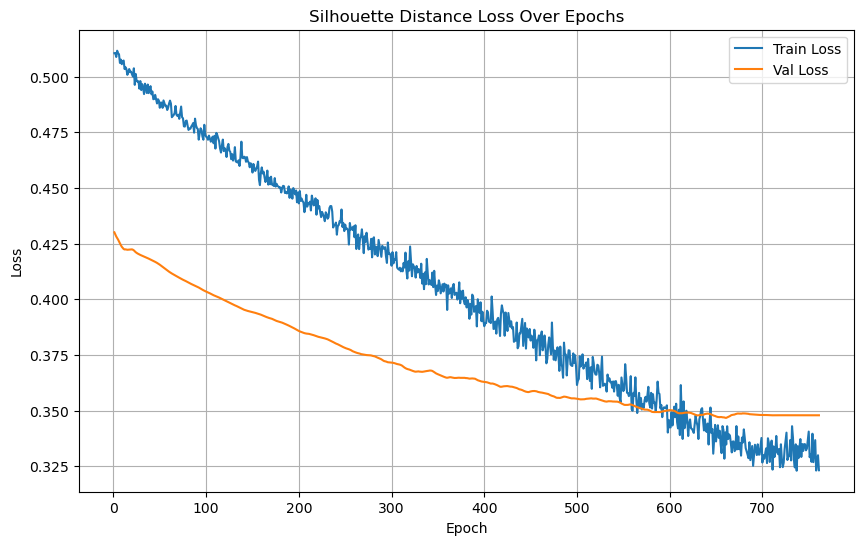

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/157], Loss: 0.3020


Test Batch [20/157], Loss: 0.3603
Test Batch [30/157], Loss: 0.3788


Test Batch [40/157], Loss: 0.3572
Test Batch [50/157], Loss: 0.4491


Test Batch [60/157], Loss: 0.4564


Test Batch [70/157], Loss: 0.2063
Test Batch [80/157], Loss: 0.2305
Test Batch [90/157], Loss: 0.2691
Test Batch [100/157], Loss: 0.2466


Test Batch [110/157], Loss: 0.2267


Test Batch [120/157], Loss: 0.1835
Test Batch [130/157], Loss: 0.1100
Test Batch [140/157], Loss: 0.4411


Test Batch [150/157], Loss: 0.3269

Test Loss: 0.3258


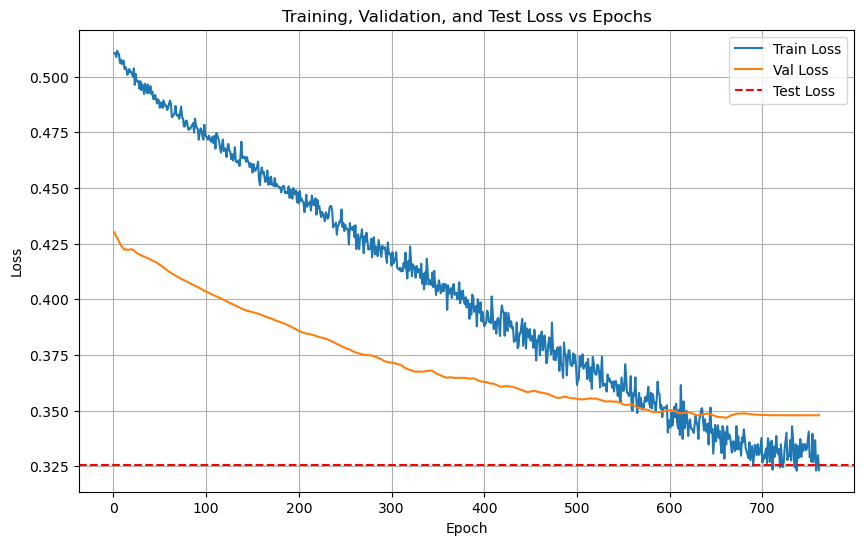

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/157 for test dataset.
  Processed batch 20/157 for test dataset.


  Processed batch 30/157 for test dataset.
  Processed batch 40/157 for test dataset.


  Processed batch 50/157 for test dataset.


  Processed batch 60/157 for test dataset.
  Processed batch 70/157 for test dataset.


  Processed batch 80/157 for test dataset.


  Processed batch 90/157 for test dataset.
  Processed batch 100/157 for test dataset.


  Processed batch 110/157 for test dataset.


  Processed batch 120/157 for test dataset.
  Processed batch 130/157 for test dataset.


  Processed batch 140/157 for test dataset.
  Processed batch 150/157 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 70.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.40      0.40      0.40         5
          10       0.00      0.00      0.00         5
          11       0.50      0.80      0.62         5
          12       0.50      1.00      0.67         5
          13       0.8

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9501  |  Val Loss: 2.9838
Validation loss improved from inf to 2.9838.
[Epoch 2/1000] Train Loss: 2.9220  |  Val Loss: 2.9581
Validation loss improved from 2.9838 to 2.9581.
[Epoch 3/1000] Train Loss: 2.8982  |  Val Loss: 2.9323
Validation loss improved from 2.9581 to 2.9323.
[Epoch 4/1000] Train Loss: 2.8707  |  Val Loss: 2.9075
Validation loss improved from 2.9323 to 2.9075.
[Epoch 5/1000] Train Loss: 2.8485  |  Val Loss: 2.8828
Validation loss improved from 2.9075 to 2.8828.
[Epoch 6/1000] Train Loss: 2.8227  |  Val Loss: 2.8600
Validation loss improved from 2.8828 to 2.8600.
[Epoch 7/1000] Train Loss: 2.7996  |  Val Loss: 2.8380
Validation loss improved from 2.8600 to 2.8380.
[Epoch 8/1000] Train Loss: 2.7772  |  Val Loss: 2.8163
Validation loss improved from 2.8380 to 2.8163.


[Epoch 9/1000] Train Loss: 2.7545  |  Val Loss: 2.7960
Validation loss improved from 2.8163 to 2.7960.
[Epoch 10/1000] Train Loss: 2.7346  |  Val Loss: 2.7763
Validation loss improved from 2.7960 to 2.7763.
[Epoch 11/1000] Train Loss: 2.7152  |  Val Loss: 2.7579
Validation loss improved from 2.7763 to 2.7579.
[Epoch 12/1000] Train Loss: 2.6966  |  Val Loss: 2.7409
Validation loss improved from 2.7579 to 2.7409.
[Epoch 13/1000] Train Loss: 2.6807  |  Val Loss: 2.7242
Validation loss improved from 2.7409 to 2.7242.
[Epoch 14/1000] Train Loss: 2.6646  |  Val Loss: 2.7081
Validation loss improved from 2.7242 to 2.7081.
[Epoch 15/1000] Train Loss: 2.6486  |  Val Loss: 2.6929
Validation loss improved from 2.7081 to 2.6929.
[Epoch 16/1000] Train Loss: 2.6332  |  Val Loss: 2.6784
Validation loss improved from 2.6929 to 2.6784.
[Epoch 17/1000] Train Loss: 2.6175  |  Val Loss: 2.6648
Validation loss improved from 2.6784 to 2.6648.
[Epoch 18/1000] Train Loss: 2.6032  |  Val Loss: 2.6515
Validatio

[Epoch 24/1000] Train Loss: 2.5237  |  Val Loss: 2.5812
Validation loss improved from 2.5920 to 2.5812.
[Epoch 25/1000] Train Loss: 2.5120  |  Val Loss: 2.5708
Validation loss improved from 2.5812 to 2.5708.
[Epoch 26/1000] Train Loss: 2.5005  |  Val Loss: 2.5604
Validation loss improved from 2.5708 to 2.5604.
[Epoch 27/1000] Train Loss: 2.4894  |  Val Loss: 2.5501
Validation loss improved from 2.5604 to 2.5501.
[Epoch 28/1000] Train Loss: 2.4781  |  Val Loss: 2.5401
Validation loss improved from 2.5501 to 2.5401.
[Epoch 29/1000] Train Loss: 2.4675  |  Val Loss: 2.5302
Validation loss improved from 2.5401 to 2.5302.
[Epoch 30/1000] Train Loss: 2.4563  |  Val Loss: 2.5206
Validation loss improved from 2.5302 to 2.5206.
[Epoch 31/1000] Train Loss: 2.4454  |  Val Loss: 2.5109
Validation loss improved from 2.5206 to 2.5109.


[Epoch 32/1000] Train Loss: 2.4349  |  Val Loss: 2.5014
Validation loss improved from 2.5109 to 2.5014.
[Epoch 33/1000] Train Loss: 2.4240  |  Val Loss: 2.4922
Validation loss improved from 2.5014 to 2.4922.
[Epoch 34/1000] Train Loss: 2.4133  |  Val Loss: 2.4831
Validation loss improved from 2.4922 to 2.4831.
[Epoch 35/1000] Train Loss: 2.4025  |  Val Loss: 2.4740
Validation loss improved from 2.4831 to 2.4740.
[Epoch 36/1000] Train Loss: 2.3916  |  Val Loss: 2.4645
Validation loss improved from 2.4740 to 2.4645.
[Epoch 37/1000] Train Loss: 2.3808  |  Val Loss: 2.4552
Validation loss improved from 2.4645 to 2.4552.
[Epoch 38/1000] Train Loss: 2.3698  |  Val Loss: 2.4453
Validation loss improved from 2.4552 to 2.4453.
[Epoch 39/1000] Train Loss: 2.3587  |  Val Loss: 2.4355
Validation loss improved from 2.4453 to 2.4355.


[Epoch 40/1000] Train Loss: 2.3481  |  Val Loss: 2.4253
Validation loss improved from 2.4355 to 2.4253.
[Epoch 41/1000] Train Loss: 2.3365  |  Val Loss: 2.4155
Validation loss improved from 2.4253 to 2.4155.
[Epoch 42/1000] Train Loss: 2.3252  |  Val Loss: 2.4054
Validation loss improved from 2.4155 to 2.4054.
[Epoch 43/1000] Train Loss: 2.3139  |  Val Loss: 2.3950
Validation loss improved from 2.4054 to 2.3950.
[Epoch 44/1000] Train Loss: 2.3026  |  Val Loss: 2.3844
Validation loss improved from 2.3950 to 2.3844.
[Epoch 45/1000] Train Loss: 2.2903  |  Val Loss: 2.3737
Validation loss improved from 2.3844 to 2.3737.
[Epoch 46/1000] Train Loss: 2.2784  |  Val Loss: 2.3635
Validation loss improved from 2.3737 to 2.3635.
[Epoch 47/1000] Train Loss: 2.2667  |  Val Loss: 2.3529
Validation loss improved from 2.3635 to 2.3529.
[Epoch 48/1000] Train Loss: 2.2547  |  Val Loss: 2.3425
Validation loss improved from 2.3529 to 2.3425.
[Epoch 49/1000] Train Loss: 2.2427  |  Val Loss: 2.3322
Validati

[Epoch 54/1000] Train Loss: 2.1802  |  Val Loss: 2.2804
Validation loss improved from 2.2910 to 2.2804.
[Epoch 55/1000] Train Loss: 2.1674  |  Val Loss: 2.2708
Validation loss improved from 2.2804 to 2.2708.
[Epoch 56/1000] Train Loss: 2.1553  |  Val Loss: 2.2617
Validation loss improved from 2.2708 to 2.2617.
[Epoch 57/1000] Train Loss: 2.1423  |  Val Loss: 2.2526
Validation loss improved from 2.2617 to 2.2526.
[Epoch 58/1000] Train Loss: 2.1295  |  Val Loss: 2.2437
Validation loss improved from 2.2526 to 2.2437.
[Epoch 59/1000] Train Loss: 2.1169  |  Val Loss: 2.2348
Validation loss improved from 2.2437 to 2.2348.


[Epoch 60/1000] Train Loss: 2.1042  |  Val Loss: 2.2261
Validation loss improved from 2.2348 to 2.2261.
[Epoch 61/1000] Train Loss: 2.0922  |  Val Loss: 2.2173
Validation loss improved from 2.2261 to 2.2173.
[Epoch 62/1000] Train Loss: 2.0791  |  Val Loss: 2.2088
Validation loss improved from 2.2173 to 2.2088.
[Epoch 63/1000] Train Loss: 2.0665  |  Val Loss: 2.2003
Validation loss improved from 2.2088 to 2.2003.
[Epoch 64/1000] Train Loss: 2.0540  |  Val Loss: 2.1920
Validation loss improved from 2.2003 to 2.1920.
[Epoch 65/1000] Train Loss: 2.0416  |  Val Loss: 2.1834
Validation loss improved from 2.1920 to 2.1834.
[Epoch 66/1000] Train Loss: 2.0289  |  Val Loss: 2.1751
Validation loss improved from 2.1834 to 2.1751.
[Epoch 67/1000] Train Loss: 2.0165  |  Val Loss: 2.1668
Validation loss improved from 2.1751 to 2.1668.


[Epoch 68/1000] Train Loss: 2.0040  |  Val Loss: 2.1582
Validation loss improved from 2.1668 to 2.1582.
[Epoch 69/1000] Train Loss: 1.9913  |  Val Loss: 2.1498
Validation loss improved from 2.1582 to 2.1498.
[Epoch 70/1000] Train Loss: 1.9791  |  Val Loss: 2.1413
Validation loss improved from 2.1498 to 2.1413.
[Epoch 71/1000] Train Loss: 1.9663  |  Val Loss: 2.1328
Validation loss improved from 2.1413 to 2.1328.
[Epoch 72/1000] Train Loss: 1.9539  |  Val Loss: 2.1244
Validation loss improved from 2.1328 to 2.1244.
[Epoch 73/1000] Train Loss: 1.9419  |  Val Loss: 2.1161
Validation loss improved from 2.1244 to 2.1161.
[Epoch 74/1000] Train Loss: 1.9291  |  Val Loss: 2.1084
Validation loss improved from 2.1161 to 2.1084.
[Epoch 75/1000] Train Loss: 1.9168  |  Val Loss: 2.1003
Validation loss improved from 2.1084 to 2.1003.
[Epoch 76/1000] Train Loss: 1.9042  |  Val Loss: 2.0922
Validation loss improved from 2.1003 to 2.0922.
[Epoch 77/1000] Train Loss: 1.8917  |  Val Loss: 2.0843
Validati

[Epoch 84/1000] Train Loss: 1.8037  |  Val Loss: 2.0309
Validation loss improved from 2.0385 to 2.0309.
[Epoch 85/1000] Train Loss: 1.7912  |  Val Loss: 2.0234
Validation loss improved from 2.0309 to 2.0234.
[Epoch 86/1000] Train Loss: 1.7788  |  Val Loss: 2.0158
Validation loss improved from 2.0234 to 2.0158.
[Epoch 87/1000] Train Loss: 1.7661  |  Val Loss: 2.0077
Validation loss improved from 2.0158 to 2.0077.
[Epoch 88/1000] Train Loss: 1.7533  |  Val Loss: 1.9993
Validation loss improved from 2.0077 to 1.9993.


[Epoch 89/1000] Train Loss: 1.7407  |  Val Loss: 1.9913
Validation loss improved from 1.9993 to 1.9913.
[Epoch 90/1000] Train Loss: 1.7282  |  Val Loss: 1.9834
Validation loss improved from 1.9913 to 1.9834.
[Epoch 91/1000] Train Loss: 1.7152  |  Val Loss: 1.9756
Validation loss improved from 1.9834 to 1.9756.
[Epoch 92/1000] Train Loss: 1.7026  |  Val Loss: 1.9680
Validation loss improved from 1.9756 to 1.9680.
[Epoch 93/1000] Train Loss: 1.6898  |  Val Loss: 1.9607
Validation loss improved from 1.9680 to 1.9607.
[Epoch 94/1000] Train Loss: 1.6772  |  Val Loss: 1.9537
Validation loss improved from 1.9607 to 1.9537.
[Epoch 95/1000] Train Loss: 1.6646  |  Val Loss: 1.9459
Validation loss improved from 1.9537 to 1.9459.


[Epoch 96/1000] Train Loss: 1.6518  |  Val Loss: 1.9384
Validation loss improved from 1.9459 to 1.9384.
[Epoch 97/1000] Train Loss: 1.6390  |  Val Loss: 1.9307
Validation loss improved from 1.9384 to 1.9307.
[Epoch 98/1000] Train Loss: 1.6262  |  Val Loss: 1.9228
Validation loss improved from 1.9307 to 1.9228.
[Epoch 99/1000] Train Loss: 1.6134  |  Val Loss: 1.9151
Validation loss improved from 1.9228 to 1.9151.
[Epoch 100/1000] Train Loss: 1.6007  |  Val Loss: 1.9073
Validation loss improved from 1.9151 to 1.9073.
[Epoch 101/1000] Train Loss: 1.5880  |  Val Loss: 1.9004
Validation loss improved from 1.9073 to 1.9004.
[Epoch 102/1000] Train Loss: 1.5754  |  Val Loss: 1.8937
Validation loss improved from 1.9004 to 1.8937.
[Epoch 103/1000] Train Loss: 1.5625  |  Val Loss: 1.8879
Validation loss improved from 1.8937 to 1.8879.
[Epoch 104/1000] Train Loss: 1.5494  |  Val Loss: 1.8815
Validation loss improved from 1.8879 to 1.8815.
[Epoch 105/1000] Train Loss: 1.5372  |  Val Loss: 1.8757
Va

[Epoch 111/1000] Train Loss: 1.4615  |  Val Loss: 1.8428
Validation loss improved from 1.8486 to 1.8428.
[Epoch 112/1000] Train Loss: 1.4486  |  Val Loss: 1.8364
Validation loss improved from 1.8428 to 1.8364.
[Epoch 113/1000] Train Loss: 1.4363  |  Val Loss: 1.8306
Validation loss improved from 1.8364 to 1.8306.
[Epoch 114/1000] Train Loss: 1.4239  |  Val Loss: 1.8254
Validation loss improved from 1.8306 to 1.8254.
[Epoch 115/1000] Train Loss: 1.4118  |  Val Loss: 1.8200
Validation loss improved from 1.8254 to 1.8200.
[Epoch 116/1000] Train Loss: 1.3991  |  Val Loss: 1.8140
Validation loss improved from 1.8200 to 1.8140.
[Epoch 117/1000] Train Loss: 1.3866  |  Val Loss: 1.8075
Validation loss improved from 1.8140 to 1.8075.


[Epoch 118/1000] Train Loss: 1.3744  |  Val Loss: 1.8014
Validation loss improved from 1.8075 to 1.8014.
[Epoch 119/1000] Train Loss: 1.3622  |  Val Loss: 1.7957
Validation loss improved from 1.8014 to 1.7957.
[Epoch 120/1000] Train Loss: 1.3501  |  Val Loss: 1.7890
Validation loss improved from 1.7957 to 1.7890.
[Epoch 121/1000] Train Loss: 1.3379  |  Val Loss: 1.7833
Validation loss improved from 1.7890 to 1.7833.
[Epoch 122/1000] Train Loss: 1.3259  |  Val Loss: 1.7773
Validation loss improved from 1.7833 to 1.7773.
[Epoch 123/1000] Train Loss: 1.3137  |  Val Loss: 1.7716
Validation loss improved from 1.7773 to 1.7716.


[Epoch 124/1000] Train Loss: 1.3016  |  Val Loss: 1.7656
Validation loss improved from 1.7716 to 1.7656.
[Epoch 125/1000] Train Loss: 1.2897  |  Val Loss: 1.7602
Validation loss improved from 1.7656 to 1.7602.
[Epoch 126/1000] Train Loss: 1.2775  |  Val Loss: 1.7558
Validation loss improved from 1.7602 to 1.7558.
[Epoch 127/1000] Train Loss: 1.2657  |  Val Loss: 1.7521
Validation loss improved from 1.7558 to 1.7521.
[Epoch 128/1000] Train Loss: 1.2539  |  Val Loss: 1.7491
Validation loss improved from 1.7521 to 1.7491.
[Epoch 129/1000] Train Loss: 1.2418  |  Val Loss: 1.7457
Validation loss improved from 1.7491 to 1.7457.
[Epoch 130/1000] Train Loss: 1.2300  |  Val Loss: 1.7425
Validation loss improved from 1.7457 to 1.7425.
[Epoch 131/1000] Train Loss: 1.2182  |  Val Loss: 1.7383
Validation loss improved from 1.7425 to 1.7383.
[Epoch 132/1000] Train Loss: 1.2065  |  Val Loss: 1.7338
Validation loss improved from 1.7383 to 1.7338.
[Epoch 133/1000] Train Loss: 1.1949  |  Val Loss: 1.728

[Epoch 140/1000] Train Loss: 1.1146  |  Val Loss: 1.6914
Validation loss improved from 1.6969 to 1.6914.
[Epoch 141/1000] Train Loss: 1.1034  |  Val Loss: 1.6856
Validation loss improved from 1.6914 to 1.6856.
[Epoch 142/1000] Train Loss: 1.0923  |  Val Loss: 1.6799
Validation loss improved from 1.6856 to 1.6799.
[Epoch 143/1000] Train Loss: 1.0811  |  Val Loss: 1.6748
Validation loss improved from 1.6799 to 1.6748.
[Epoch 144/1000] Train Loss: 1.0700  |  Val Loss: 1.6704
Validation loss improved from 1.6748 to 1.6704.


[Epoch 145/1000] Train Loss: 1.0597  |  Val Loss: 1.6665
Validation loss improved from 1.6704 to 1.6665.
[Epoch 146/1000] Train Loss: 1.0491  |  Val Loss: 1.6632
Validation loss improved from 1.6665 to 1.6632.
[Epoch 147/1000] Train Loss: 1.0383  |  Val Loss: 1.6598
Validation loss improved from 1.6632 to 1.6598.
[Epoch 148/1000] Train Loss: 1.0276  |  Val Loss: 1.6563
Validation loss improved from 1.6598 to 1.6563.
[Epoch 149/1000] Train Loss: 1.0172  |  Val Loss: 1.6530
Validation loss improved from 1.6563 to 1.6530.
[Epoch 150/1000] Train Loss: 1.0067  |  Val Loss: 1.6491
Validation loss improved from 1.6530 to 1.6491.


[Epoch 151/1000] Train Loss: 0.9964  |  Val Loss: 1.6442
Validation loss improved from 1.6491 to 1.6442.
[Epoch 152/1000] Train Loss: 0.9859  |  Val Loss: 1.6402
Validation loss improved from 1.6442 to 1.6402.
[Epoch 153/1000] Train Loss: 0.9754  |  Val Loss: 1.6347
Validation loss improved from 1.6402 to 1.6347.
[Epoch 154/1000] Train Loss: 0.9658  |  Val Loss: 1.6285
Validation loss improved from 1.6347 to 1.6285.
[Epoch 155/1000] Train Loss: 0.9553  |  Val Loss: 1.6227
Validation loss improved from 1.6285 to 1.6227.
[Epoch 156/1000] Train Loss: 0.9450  |  Val Loss: 1.6175
Validation loss improved from 1.6227 to 1.6175.
[Epoch 157/1000] Train Loss: 0.9354  |  Val Loss: 1.6129
Validation loss improved from 1.6175 to 1.6129.
[Epoch 158/1000] Train Loss: 0.9256  |  Val Loss: 1.6087
Validation loss improved from 1.6129 to 1.6087.
[Epoch 159/1000] Train Loss: 0.9158  |  Val Loss: 1.6043
Validation loss improved from 1.6087 to 1.6043.
[Epoch 160/1000] Train Loss: 0.9065  |  Val Loss: 1.601

[Epoch 170/1000] Train Loss: 0.8171  |  Val Loss: 1.5696
Validation loss improved from 1.5734 to 1.5696.
[Epoch 171/1000] Train Loss: 0.8088  |  Val Loss: 1.5663
Validation loss improved from 1.5696 to 1.5663.
[Epoch 172/1000] Train Loss: 0.8006  |  Val Loss: 1.5632
Validation loss improved from 1.5663 to 1.5632.
[Epoch 173/1000] Train Loss: 0.7922  |  Val Loss: 1.5595
Validation loss improved from 1.5632 to 1.5595.
[Epoch 174/1000] Train Loss: 0.7847  |  Val Loss: 1.5561
Validation loss improved from 1.5595 to 1.5561.
[Epoch 175/1000] Train Loss: 0.7766  |  Val Loss: 1.5544
Validation loss improved from 1.5561 to 1.5544.


[Epoch 176/1000] Train Loss: 0.7688  |  Val Loss: 1.5535
Validation loss improved from 1.5544 to 1.5535.
[Epoch 177/1000] Train Loss: 0.7612  |  Val Loss: 1.5512
Validation loss improved from 1.5535 to 1.5512.
[Epoch 178/1000] Train Loss: 0.7536  |  Val Loss: 1.5509
Validation loss improved from 1.5512 to 1.5509.
[Epoch 179/1000] Train Loss: 0.7462  |  Val Loss: 1.5486
Validation loss improved from 1.5509 to 1.5486.
[Epoch 180/1000] Train Loss: 0.7389  |  Val Loss: 1.5467
Validation loss improved from 1.5486 to 1.5467.
[Epoch 181/1000] Train Loss: 0.7316  |  Val Loss: 1.5453
Validation loss improved from 1.5467 to 1.5453.
[Epoch 182/1000] Train Loss: 0.7244  |  Val Loss: 1.5460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 0.7178  |  Val Loss: 1.5473
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 0.7111  |  Val Loss: 1.5487
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 185/1000] Train Loss: 0.7045  

[Epoch 198/1000] Train Loss: 0.6248  |  Val Loss: 1.5437
Validation loss improved from 1.5438 to 1.5437.
[Epoch 199/1000] Train Loss: 0.6194  |  Val Loss: 1.5433
Validation loss improved from 1.5437 to 1.5433.
[Epoch 200/1000] Train Loss: 0.6140  |  Val Loss: 1.5436
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 0.6086  |  Val Loss: 1.5438
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 0.6034  |  Val Loss: 1.5435
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 0.5980  |  Val Loss: 1.5435
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/1000] Train Loss: 0.5928  |  Val Loss: 1.5417
Validation loss improved from 1.5433 to 1.5417.


[Epoch 205/1000] Train Loss: 0.5880  |  Val Loss: 1.5417
Validation loss improved from 1.5417 to 1.5417.
[Epoch 206/1000] Train Loss: 0.5828  |  Val Loss: 1.5408
Validation loss improved from 1.5417 to 1.5408.
[Epoch 207/1000] Train Loss: 0.5779  |  Val Loss: 1.5403
Validation loss improved from 1.5408 to 1.5403.
[Epoch 208/1000] Train Loss: 0.5730  |  Val Loss: 1.5403
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 0.5682  |  Val Loss: 1.5412
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 0.5635  |  Val Loss: 1.5432
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 0.5587  |  Val Loss: 1.5454
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 212/1000] Train Loss: 0.5542  |  Val Loss: 1.5461
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 213/1000] Train Loss: 0.5497  |  Val Loss: 1.5459
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 214/1000] Tr

[Epoch 226/1000] Train Loss: 0.4957  |  Val Loss: 1.5705
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 227/1000] Train Loss: 0.4919  |  Val Loss: 1.5715
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 228/1000] Train Loss: 0.4880  |  Val Loss: 1.5727
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 229/1000] Train Loss: 0.4844  |  Val Loss: 1.5722
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 230/1000] Train Loss: 0.4809  |  Val Loss: 1.5717
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 231/1000] Train Loss: 0.4776  |  Val Loss: 1.5717
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 232/1000] Train Loss: 0.4740  |  Val Loss: 1.5729
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 233/1000] Train Loss: 0.4706  |  Val Loss: 1.5754
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 234/1000] Train Loss: 0.4668  |  Val Loss: 1.5773
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 235/1000] Train Loss: 0.4634  |  Val Loss: 1.5793
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 236/1000] Train Loss: 0.4605  |  Val Loss: 1.5798
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 237/1000] Train Loss: 0.4569  |  Val Loss: 1.5802
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 238/1000] Train Loss: 0.4543  |  Val Loss: 1.5795
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 239/1000] Train Loss: 0.4505  |  Val Loss: 1.5783
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 240/1000] Train Loss: 0.4471  |  Val Loss: 1.5775
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 241/1000] Train Loss: 0.4442  |  Val Loss: 1.5759
!! Validation loss did NOT improve !! Patience:

[Epoch 255/1000] Train Loss: 0.4038  |  Val Loss: 1.5936
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 256/1000] Train Loss: 0.4016  |  Val Loss: 1.5959
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 257/1000] Train Loss: 0.3990  |  Val Loss: 1.5963
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 258/1000] Train Loss: 0.3963  |  Val Loss: 1.5982
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 259/1000] Train Loss: 0.3938  |  Val Loss: 1.6007
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 260/1000] Train Loss: 0.3911  |  Val Loss: 1.6020
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 261/1000] Train Loss: 0.3887  |  Val Loss: 1.6044
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 262/1000] Train Loss: 0.3861  |  Val Loss: 1.6057
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 263/1000] Train Loss: 0.3837  |  Val Loss: 1.6080
!! Validation loss did NOT improve !! Patience:

[Epoch 264/1000] Train Loss: 0.3813  |  Val Loss: 1.6106
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 265/1000] Train Loss: 0.3790  |  Val Loss: 1.6134
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 266/1000] Train Loss: 0.3764  |  Val Loss: 1.6159
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 267/1000] Train Loss: 0.3742  |  Val Loss: 1.6148
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 268/1000] Train Loss: 0.3721  |  Val Loss: 1.6146
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 269/1000] Train Loss: 0.3697  |  Val Loss: 1.6161
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 270/1000] Train Loss: 0.3675  |  Val Loss: 1.6163
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 271/1000] Train Loss: 0.3651  |  Val Loss: 1.6171
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 272/1000] Train Loss: 0.3631  |  Val Loss: 1.6176
!! Validation loss did NOT improve !! Patience:

[Epoch 281/1000] Train Loss: 0.3441  |  Val Loss: 1.6356
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 282/1000] Train Loss: 0.3423  |  Val Loss: 1.6379
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 283/1000] Train Loss: 0.3405  |  Val Loss: 1.6388
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 284/1000] Train Loss: 0.3385  |  Val Loss: 1.6413
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 285/1000] Train Loss: 0.3365  |  Val Loss: 1.6435
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 286/1000] Train Loss: 0.3347  |  Val Loss: 1.6454
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 287/1000] Train Loss: 0.3329  |  Val Loss: 1.6482
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 288/1000] Train Loss: 0.3310  |  Val Loss: 1.6502
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 289/1000] Train Loss: 0.3292  |  Val Loss: 1.6533
!! Validation loss did NOT improve !! Patience:

[Epoch 292/1000] Train Loss: 0.3236  |  Val Loss: 1.6610
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 293/1000] Train Loss: 0.3223  |  Val Loss: 1.6638
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 294/1000] Train Loss: 0.3204  |  Val Loss: 1.6656
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 295/1000] Train Loss: 0.3186  |  Val Loss: 1.6683
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 296/1000] Train Loss: 0.3170  |  Val Loss: 1.6725
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 297/1000] Train Loss: 0.3152  |  Val Loss: 1.6747
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 298/1000] Train Loss: 0.3134  |  Val Loss: 1.6785
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 299/1000] Train Loss: 0.3117  |  Val Loss: 1.6794
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 300/1000] Train Loss: 0.3104  |  Val Loss: 1.6821
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 0.2995  |  Val Loss: 1.6994
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 307 !!
No improvement for 100 epochs.


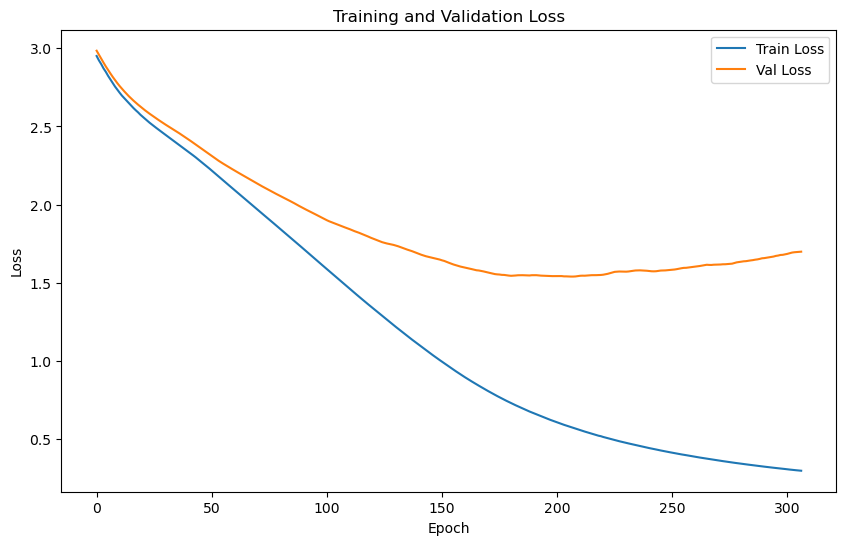

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.9309 | Test Accuracy: 48.89%


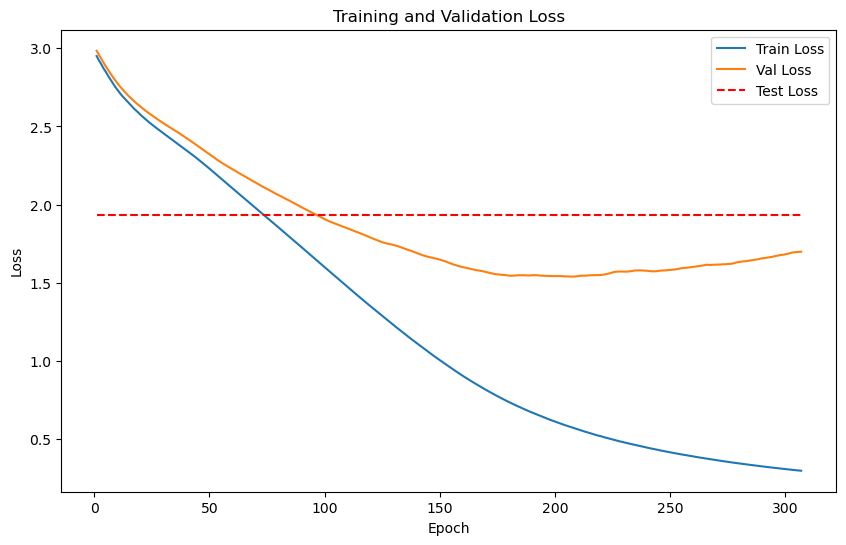

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


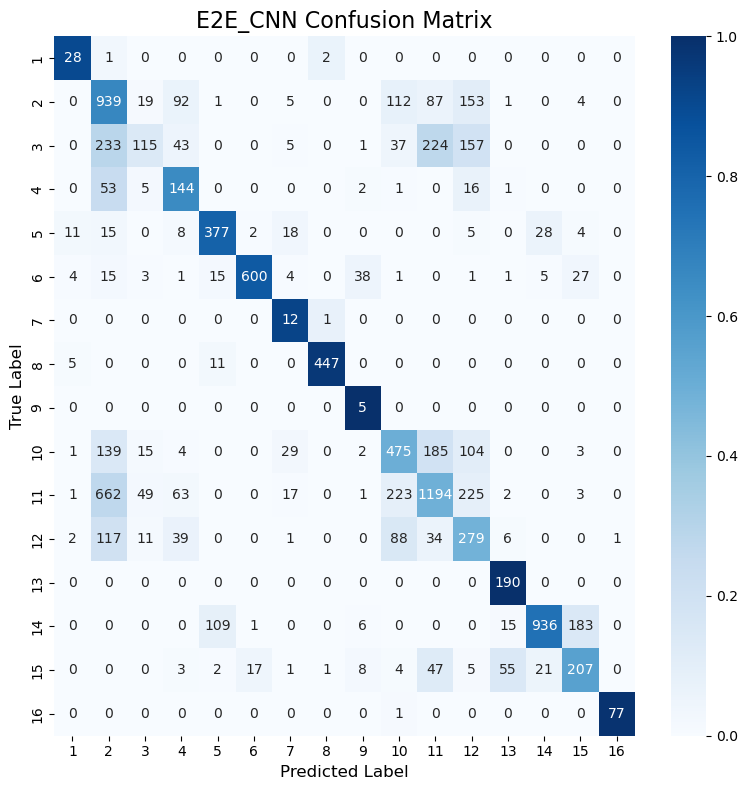

Classification Accuracy: 60.20%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


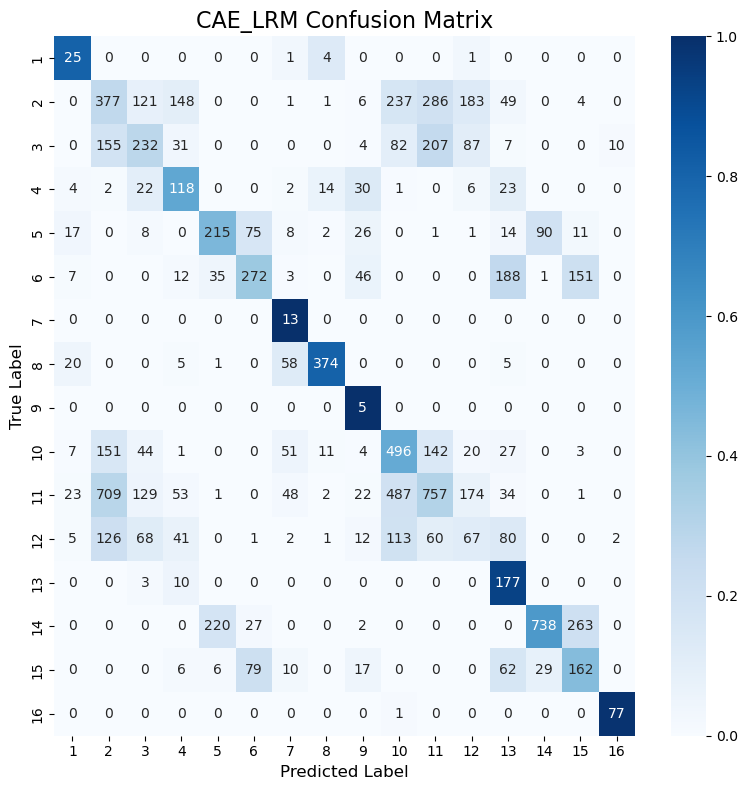

Classification Accuracy: 41.01%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


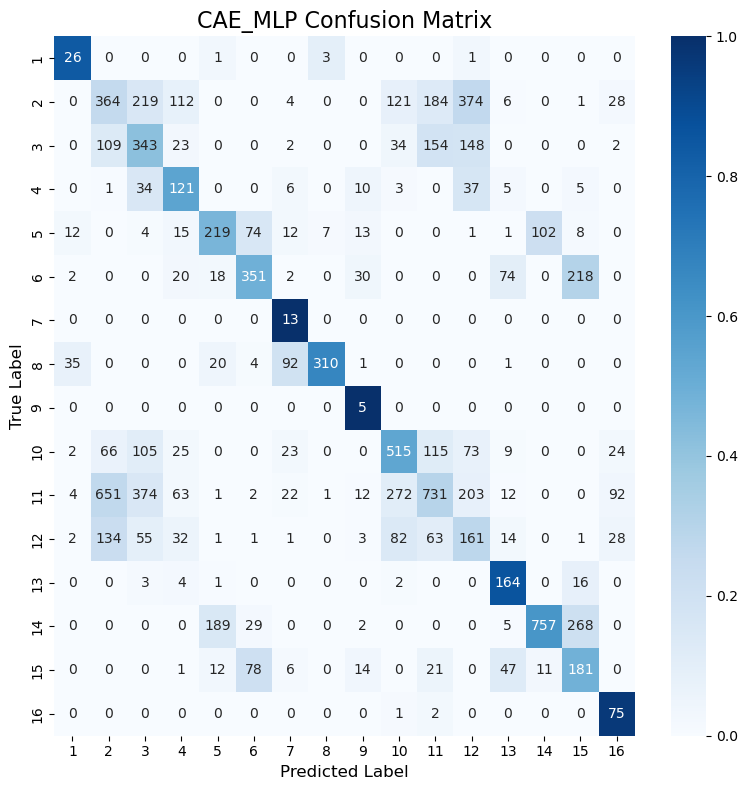

Classification Accuracy: 43.32%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


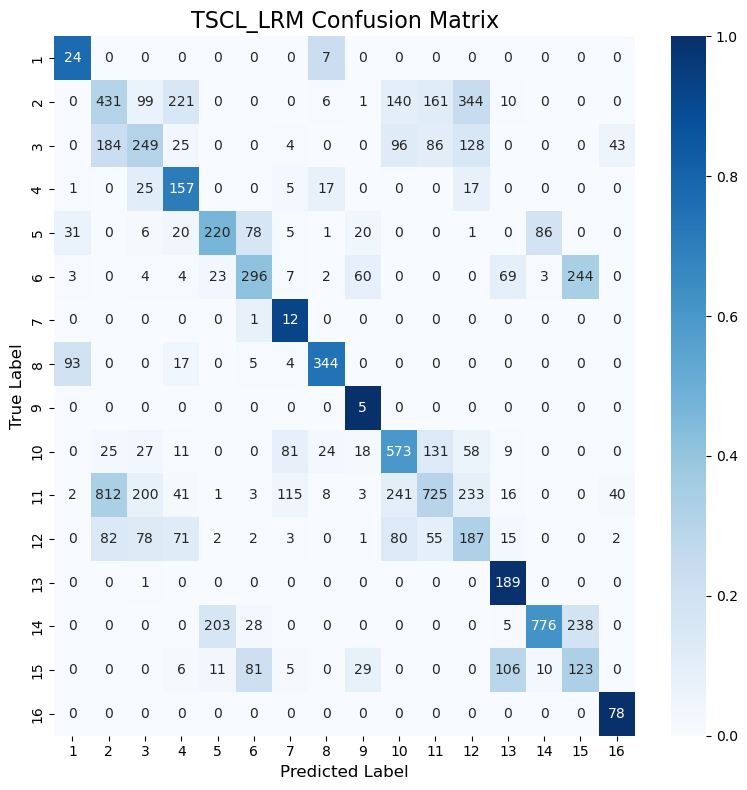

Classification Accuracy: 43.85%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


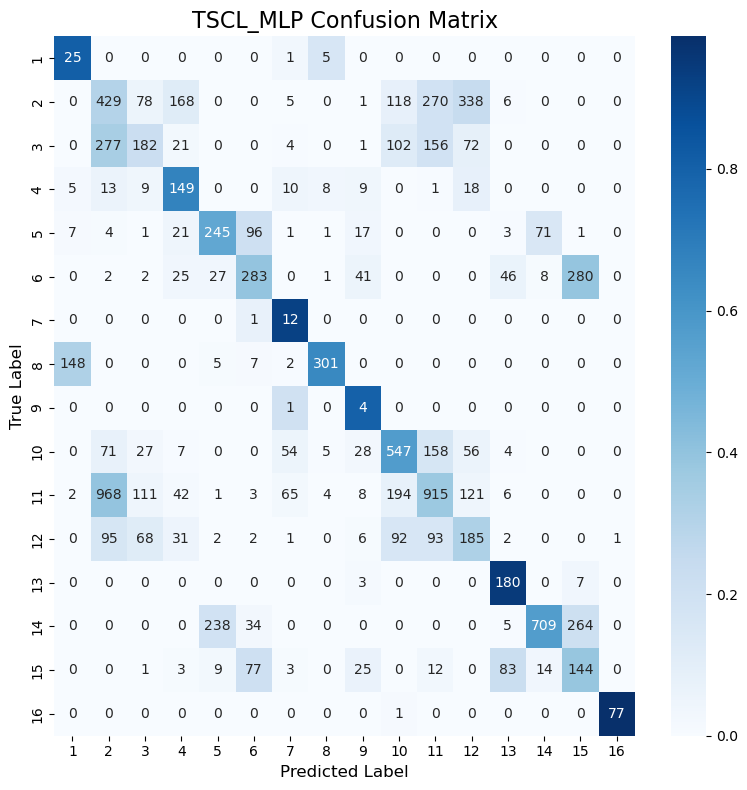

Classification Accuracy: 43.83%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


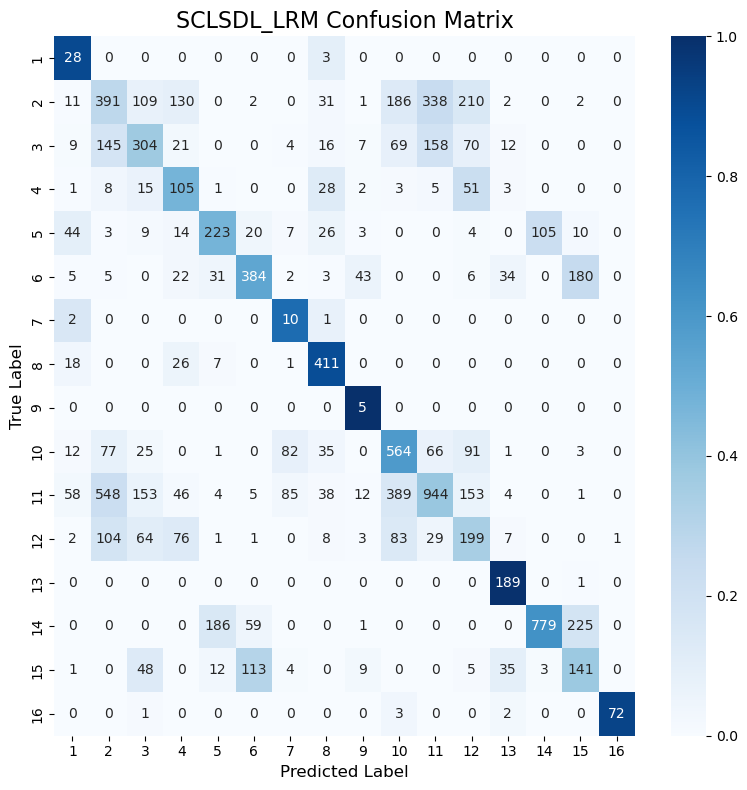

Classification Accuracy: 47.45%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


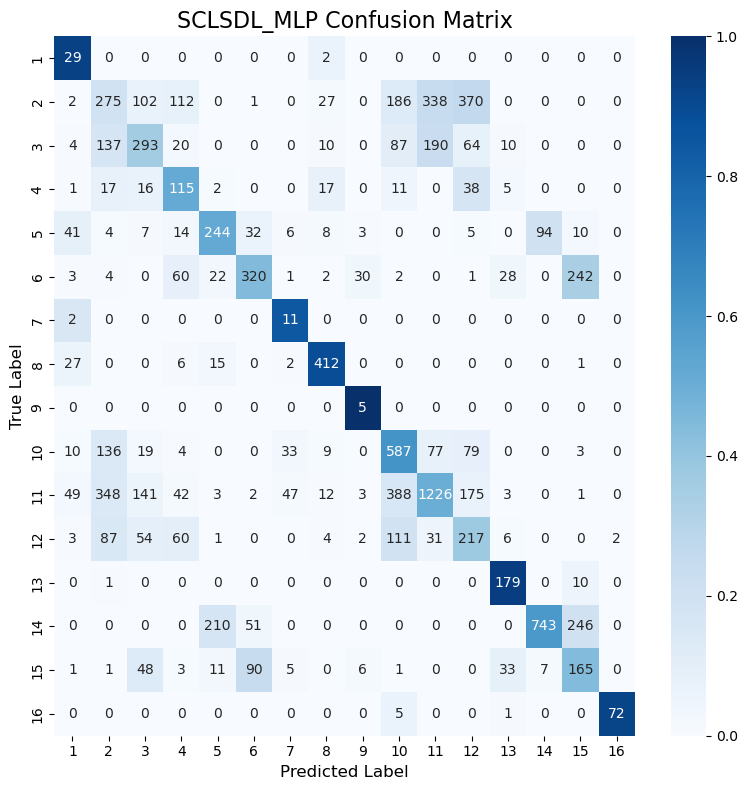

Classification Accuracy: 48.89%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          60.20
1    LRM (CAE)          41.01
2    MLP (CAE)          43.32
3     TSCL LRM          43.85
4     TSCL MLP          43.83
5  SCL_SDL LRM          47.45
6  SCL_SDL MLP          48.89

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          60.20
6  SCL_SDL MLP          48.89
5  SCL_SDL LRM          47.45
3     TSCL LRM          43.85
4     TSCL MLP          43.83
2    MLP (CAE)          43.32
1    LRM (CAE)          41.01
